In [137]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [138]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
from RR_imputer import RRimputer
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

**Load the data**

In [139]:
from sklearn.datasets import load_wine

In [140]:
print(load_wine())

{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]]), 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
 

In [141]:
ground_truth_numpy = scale(load_wine()['data']) #only taking the features
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [142]:
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))

4.371372139554767
-3.6791622340370145
4.66735072755122e-16
-0.08109900443171775
1.0


In [143]:
print(ground_truth_numpy)

[[ 1.51861254 -0.5622498   0.23205254 ...  0.36217728  1.84791957
   1.01300893]
 [ 0.24628963 -0.49941338 -0.82799632 ...  0.40605066  1.1134493
   0.96524152]
 [ 0.19687903  0.02123125  1.10933436 ...  0.31830389  0.78858745
   1.39514818]
 ...
 [ 0.33275817  1.74474449 -0.38935541 ... -1.61212515 -1.48544548
   0.28057537]
 [ 0.20923168  0.22769377  0.01273209 ... -1.56825176 -1.40069891
   0.29649784]
 [ 1.39508604  1.58316512  1.36520822 ... -1.52437837 -1.42894777
  -0.59516041]]


In [144]:
print(ground_truth_numpy.shape)
ground_truth = torch.from_numpy(ground_truth_numpy)
print(ground_truth.isnan().sum())

(178, 13)
tensor(0)


**Creating missing values**

In [145]:

#10% MCAR

np.random.seed(42)

p_macr10 = 0.10


mask_mcar10 = np.random.rand(*ground_truth.shape) < p_macr10  # True for missing values, false for others
data_mcar10 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar10[mask_mcar10] = np.nan

# Convert to a torch tensor
data_mcar10 = torch.from_numpy(data_mcar10)

# Calculate the percentage of missing values
missing_values_mcar10 = torch.isnan(data_mcar10)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar10 = torch.sum(missing_values_mcar10).item() / data_mcar10.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar10:.2f}%")


Percentage of missing values: 10.67%


In [146]:
#15% MCAR

np.random.seed(42)

p_macr15 = 0.15


mask_mcar15 = np.random.rand(*ground_truth.shape) < p_macr15  # True for missing values, false for others
data_mcar15 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar15[mask_mcar15] = np.nan

# Convert to a torch tensor
data_mcar15 = torch.from_numpy(data_mcar15)

# Calculate the percentage of missing values
missing_values_mcar15 = torch.isnan(data_mcar15)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar15 = torch.sum(missing_values_mcar15).item() / data_mcar15.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar15:.2f}%")

Percentage of missing values: 15.99%


In [147]:
#20% MCAR
np.random.seed(42)

p_macr20 = 0.20


mask_mcar20 = np.random.rand(*ground_truth.shape) < p_macr20  # True for missing values, false for others
data_mcar20 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar20[mask_mcar20] = np.nan

# Convert to a torch tensor
data_mcar20 = torch.from_numpy(data_mcar20)

# Calculate the percentage of missing values
missing_values_mcar20 = torch.isnan(data_mcar20)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar20 = torch.sum(missing_values_mcar20).item() / data_mcar20.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar20:.2f}%")

Percentage of missing values: 21.13%


In [148]:
#25% MCAR
np.random.seed(42)

p_macr25 = 0.25


mask_mcar25 = np.random.rand(*ground_truth.shape) < p_macr25  # True for missing values, false for others
data_mcar25 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar25[mask_mcar25] = np.nan

# Convert to a torch tensor
data_mcar25 = torch.from_numpy(data_mcar25)

# Calculate the percentage of missing values
missing_values_mcar25 = torch.isnan(data_mcar25)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar25 = torch.sum(missing_values_mcar25).item() / data_mcar25.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar25:.2f}%")

Percentage of missing values: 26.10%


In [149]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.30


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 30.73%


In [150]:
#35% MCAR
np.random.seed(42)

p_macr35 = 0.35


mask_mcar35 = np.random.rand(*ground_truth.shape) < p_macr35  # True for missing values, false for others
data_mcar35 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar35[mask_mcar35] = np.nan

# Convert to a torch tensor
data_mcar35 = torch.from_numpy(data_mcar35)

# Calculate the percentage of missing values
missing_values_mcar35 = torch.isnan(data_mcar35)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar35 = torch.sum(missing_values_mcar35).item() / data_mcar35.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar35:.2f}%")

Percentage of missing values: 35.31%


In [151]:
#40% MCAR
np.random.seed(42)

p_macr40 = 0.40


mask_mcar40 = np.random.rand(*ground_truth.shape) < p_macr40  # True for missing values, false for others
data_mcar40 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar40[mask_mcar40] = np.nan

# Convert to a torch tensor
data_mcar40 = torch.from_numpy(data_mcar40)

# Calculate the percentage of missing values
missing_values_mcar40 = torch.isnan(data_mcar40)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar40 = torch.sum(missing_values_mcar40).item() / data_mcar40.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar40:.2f}%")

Percentage of missing values: 40.02%


In [152]:
#45% MCAR
np.random.seed(42)

p_macr45 = 0.45


mask_mcar45 = np.random.rand(*ground_truth.shape) < p_macr45  # True for missing values, false for others
data_mcar45 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar45[mask_mcar45] = np.nan

# Convert to a torch tensor
data_mcar45 = torch.from_numpy(data_mcar45)

# Calculate the percentage of missing values
missing_values_mcar45 = torch.isnan(data_mcar45)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar45 = torch.sum(missing_values_mcar45).item() / data_mcar45.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar45:.2f}%")

Percentage of missing values: 44.30%


In [153]:
#50% MCAR
np.random.seed(42)

p_macr50 = 0.50


mask_mcar50 = np.random.rand(*ground_truth.shape) < p_macr50  # True for missing values, false for others
data_mcar50 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar50[mask_mcar50] = np.nan

# Convert to a torch tensor
data_mcar50 = torch.from_numpy(data_mcar50)

# Calculate the percentage of missing values
missing_values_mcar50 = torch.isnan(data_mcar50)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar50 = torch.sum(missing_values_mcar50).item() / data_mcar50.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar50:.2f}%")

Percentage of missing values: 49.22%


In [154]:
#60% MCAR
np.random.seed(42)

p_macr60 = 0.60


mask_mcar60 = np.random.rand(*ground_truth.shape) < p_macr60  # True for missing values, false for others
data_mcar60 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar60[mask_mcar60] = np.nan

# Convert to a torch tensor
data_mcar60 = torch.from_numpy(data_mcar60)

# Calculate the percentage of missing values
missing_values_mcar60 = torch.isnan(data_mcar60)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar60 = torch.sum(missing_values_mcar60).item() / data_mcar60.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar60:.2f}%")

Percentage of missing values: 59.20%


In [155]:
#70 MCAR
np.random.seed(42)

p_macr70 = 0.70


mask_mcar70 = np.random.rand(*ground_truth.shape) < p_macr70  # True for missing values, false for others
data_mcar70 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar70[mask_mcar70] = np.nan

# Convert to a torch tensor
data_mcar70 = torch.from_numpy(data_mcar70)

# Calculate the percentage of missing values
missing_values_mcar70 = torch.isnan(data_mcar70)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar70 = torch.sum(missing_values_mcar70).item() / data_mcar70.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar70:.2f}%")

Percentage of missing values: 70.18%


In [156]:
#80% MCAR
np.random.seed(42)

p_macr80 = 0.80


mask_mcar80 = np.random.rand(*ground_truth.shape) < p_macr80  # True for missing values, false for others
data_mcar80 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar80[mask_mcar80] = np.nan

# Convert to a torch tensor
data_mcar80 = torch.from_numpy(data_mcar80)

# Calculate the percentage of missing values
missing_values_mcar80 = torch.isnan(data_mcar80)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar80 = torch.sum(missing_values_mcar80).item() / data_mcar80.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar80:.2f}%")

Percentage of missing values: 79.73%


In [157]:
#90% MCAR
np.random.seed(42)

p_macr90 = 0.9


mask_mcar90 = np.random.rand(*ground_truth.shape) < p_macr90  # True for missing values, false for others
data_mcar90 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar90[mask_mcar90] = np.nan

# Convert to a torch tensor
data_mcar90 = torch.from_numpy(data_mcar90)

# Calculate the percentage of missing values
missing_values_mcar90 = torch.isnan(data_mcar90)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar90 = torch.sum(missing_values_mcar90).item() / data_mcar90.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar90:.2f}%")

Percentage of missing values: 90.28%


In [158]:
#95% MCAR
np.random.seed(42)

p_macr95 = 0.95


mask_mcar95 = np.random.rand(*ground_truth.shape) < p_macr95  # True for missing values, false for others
data_mcar95 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar95[mask_mcar95] = np.nan

# Convert to a torch tensor
data_mcar95 = torch.from_numpy(data_mcar95)

# Calculate the percentage of missing values
missing_values_mcar95 = torch.isnan(data_mcar95)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar95 = torch.sum(missing_values_mcar95).item() / data_mcar95.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar95:.2f}%")

Percentage of missing values: 94.86%


In [159]:
#%100 MCAR
np.random.seed(42)

p_macr100 = 1


mask_mcar100 = np.random.rand(*ground_truth.shape) < p_macr100  # True for missing values, false for others
data_mcar100 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar100[mask_mcar100] = np.nan

# Convert to a torch tensor
data_mcar100 = torch.from_numpy(data_mcar100)

# Calculate the percentage of missing values
missing_values_mcar100 = torch.isnan(data_mcar100)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar100 = torch.sum(missing_values_mcar100).item() / data_mcar100.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar100:.2f}%")

Percentage of missing values: 100.00%


In [160]:
data_mcar10_numpy = data_mcar10.detach().cpu().numpy()
data_mcar15_numpy = data_mcar15.detach().cpu().numpy()
data_mcar20_numpy = data_mcar20.detach().cpu().numpy()
data_mcar25_numpy = data_mcar25.detach().cpu().numpy()
data_mcar30_numpy = data_mcar30.detach().cpu().numpy()
data_mcar35_numpy = data_mcar35.detach().cpu().numpy()
data_mcar40_numpy = data_mcar40.detach().cpu().numpy()
data_mcar45_numpy = data_mcar45.detach().cpu().numpy()
data_mcar50_numpy = data_mcar50.detach().cpu().numpy()
data_mcar60_numpy = data_mcar60.detach().cpu().numpy()
data_mcar70_numpy = data_mcar70.detach().cpu().numpy()
data_mcar80_numpy = data_mcar80.detach().cpu().numpy()
data_mcar90_numpy = data_mcar90.detach().cpu().numpy()
data_mcar95_numpy = data_mcar95.detach().cpu().numpy()

**10% MCAR**

In [161]:
n_mcar10, d_mcar10 = data_mcar10.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar10 = pick_epsilon(data_mcar10)
print(epsilon_mcar10)

0.5396111155787111


In [162]:
sk_imputer_mcar10 = SinkhornImputation(eps=epsilon_mcar10, batchsize=batchsize, lr=lr, niter=2000)

In [163]:
sk_imp_mcar10, sk_maes10mcar, sk_rmses10mcar = sk_imputer_mcar10.fit_transform(data_mcar10, verbose=True, report_interval=500, X_true=ground_truth)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.5396
INFO:root:Iteration 0:	 Loss: 2.3676	 Validation MAE: 0.8928	RMSE: 1.0745
INFO:root:Iteration 500:	 Loss: 2.0987	 Validation MAE: 0.5577	RMSE: 0.7651
INFO:root:Iteration 1000:	 Loss: 2.1531	 Validation MAE: 0.5563	RMSE: 0.7623
INFO:root:Iteration 1500:	 Loss: 1.8736	 Validation MAE: 0.5532	RMSE: 0.7553


In [164]:
#using numpy version of data
sk_imp_mcar10_numpy = sk_imp_mcar10.detach().cpu().numpy()

In [165]:
sk_mae_mcar10 = MAE(sk_imp_mcar10_numpy,ground_truth_numpy ,mask_mcar10)
sk_rmse_mcar10 = RMSE(sk_imp_mcar10_numpy, ground_truth_numpy,mask_mcar10)
print(sk_mae_mcar10,sk_rmse_mcar10)

0.5569016041443097 0.7599522382832292


In [166]:
#linear Round Robin
dmcar10_ = d_mcar10 - 1
models_liner_mcar10 = {}

for i in range(d_mcar10):
    models_liner_mcar10[i] = nn.Linear(dmcar10_, 1)

#Create the imputer
lin_rr_imputer_mcar10 = RRimputer(models_liner_mcar10, eps=epsilon_mcar10, lr=lr)
lin_rr_mcar10, lin_maesmcar10, lin_rmsesmcar10 = lin_rr_imputer_mcar10.fit_transform(data_mcar10, verbose=True, X_true=ground_truth)
lin_rr_mcar10_numpy = lin_rr_mcar10.detach().cpu().numpy()

lin_rr_mae_mcar10 = MAE(lin_rr_mcar10_numpy,ground_truth_numpy ,mask_mcar10)
lin_rr_rmse_mcar10 = RMSE(lin_rr_mcar10_numpy, ground_truth_numpy,mask_mcar10)
print(lin_rr_mae_mcar10,lin_rr_rmse_mcar10)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 2.2988	Validation MAE: 0.7429	RMSE:  0.9627
INFO:root:Iteration 1:	 Loss: 2.1474	Validation MAE: 0.6617	RMSE:  0.8777
INFO:root:Iteration 2:	 Loss: 2.1784	Validation MAE: 0.6227	RMSE:  0.8296
INFO:root:Iteration 3:	 Loss: 2.0167	Validation MAE: 0.6114	RMSE:  0.8044
INFO:root:Iteration 4:	 Loss: 2.0066	Validation MAE: 0.6085	RMSE:  0.7954
INFO:root:Iteration 5:	 Loss: 2.2918	Validation MAE: 0.6042	RMSE:  0.7867
INFO:root:Iteration 6:	 Loss: 2.1489	Validation MAE: 0.5946	RMSE:  0.7798
INFO:root:Iteration 7:	 Loss: 2.2998	Validation MAE: 0.5932	RMSE:  0.7807
INFO:root:Iteration 8:	 Loss: 2.0625	Validation MAE: 0.5950	RMSE:  0.7866
INFO:root:Iteration 9:	 Loss: 2.0944	Validation MAE: 0.5846	RMSE:  0.7712
INFO:root:Early stopping criterion not reached


0.5846220124871554 0.7712115515892818


In [167]:
#MLP Round Robin
dmcar10_ = d_mcar10 - 1
models_mlp_mcar10 = {}


for i in range(d_mcar10):
   models_mlp_mcar10[i] = nn.Sequential(nn.Linear(dmcar10_, 2 * dmcar10_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar10_, dmcar10_),
                              nn.ReLU(),
                              nn.Linear(dmcar10_, 1))

#Create the imputer
mlp_rr_imputer_mcar10 = RRimputer(models_mlp_mcar10, eps=epsilon_mcar10, lr=lr)

mlp_rr_mcar10, mlp_rr_maesmcar10, mlp_rr_rmsesmcar10 = mlp_rr_imputer_mcar10.fit_transform(data_mcar10, verbose=True, X_true=ground_truth)

mlp_rr_mcar10_numpy = mlp_rr_mcar10.detach().cpu().numpy()

mlp_rr_mae_mcar10 = MAE(mlp_rr_mcar10_numpy,ground_truth_numpy ,mask_mcar10)
mlp_rr_rmse_mcar10 = RMSE(mlp_rr_mcar10_numpy, ground_truth_numpy,mask_mcar10)
print(mlp_rr_mae_mcar10,mlp_rr_rmse_mcar10)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 2.1068	Validation MAE: 0.5892	RMSE:  0.8112
INFO:root:Iteration 1:	 Loss: 2.0220	Validation MAE: 0.5641	RMSE:  0.7555
INFO:root:Iteration 2:	 Loss: 2.0867	Validation MAE: 0.5573	RMSE:  0.7629
INFO:root:Iteration 3:	 Loss: 1.9185	Validation MAE: 0.5553	RMSE:  0.7522
INFO:root:Iteration 4:	 Loss: 2.0854	Validation MAE: 0.5684	RMSE:  0.7502
INFO:root:Iteration 5:	 Loss: 2.0336	Validation MAE: 0.5596	RMSE:  0.7477
INFO:root:Iteration 6:	 Loss: 2.1134	Validation MAE: 0.5581	RMSE:  0.7625
INFO:root:Iteration 7:	 Loss: 2.2003	Validation MAE: 0.5713	RMSE:  0.7838
INFO:root:Iteration 8:	 Loss: 2.2168	Validation MAE: 0.5640	RMSE:  0.7771
INFO:root:Iteration 9:	 Loss: 2.2211	Validation MAE: 0.5533	RMSE:  0.7553
INFO:root:Early stopping criterion not reached


0.5533243155908305 0.7552523276526799


In [168]:
#mean
#using numpy version of data
mean_imp_mcar10 = SimpleImputer().fit_transform(data_mcar10_numpy)
mean_mae_mcar10 = MAE(mean_imp_mcar10, ground_truth_numpy, mask_mcar10)
mean_rmse_mcar10= RMSE(mean_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(mean_mae_mcar10, mean_rmse_mcar10)

0.8832041436304651 1.0695028214345976


In [169]:
ice_imp_mcar10 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar10_numpy)
ice_mae_mcar10 = MAE(ice_imp_mcar10, ground_truth_numpy, mask_mcar10)
ice_rmse_mcar10 = RMSE(ice_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(ice_mae_mcar10,ice_rmse_mcar10)

0.600651605442842 0.7654525822455341


In [170]:
cv_error_mcar10, grid_lambda_mcar10 = cv_softimpute(data_mcar10_numpy, grid_len=15)
lbda_mcar10 = grid_lambda_mcar10[np.argmin(cv_error_mcar10)]
soft_imp_mcar10 = softimpute((data_mcar10_numpy), lbda_mcar10)[1]

soft_mae_mcar10 = MAE(soft_imp_mcar10, ground_truth_numpy, mask_mcar10)
soft_rmse_mcar10 = RMSE(soft_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(soft_mae_mcar10,soft_rmse_mcar10)

0.6200625574355908 0.8010876070604417


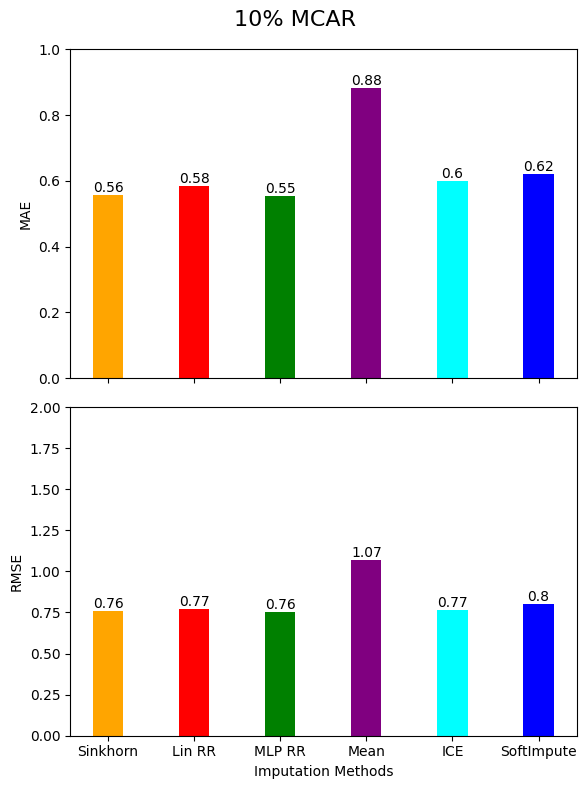

In [171]:

# Define values and categories
values_mae_mcar10 = [sk_mae_mcar10, lin_rr_mae_mcar10, mlp_rr_mae_mcar10, mean_mae_mcar10, ice_mae_mcar10, soft_mae_mcar10]
values_rmse_mcar10 = [sk_rmse_mcar10,lin_rr_rmse_mcar10, mlp_rr_rmse_mcar10, mean_rmse_mcar10, ice_rmse_mcar10, soft_rmse_mcar10]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('10% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar10, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar10, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


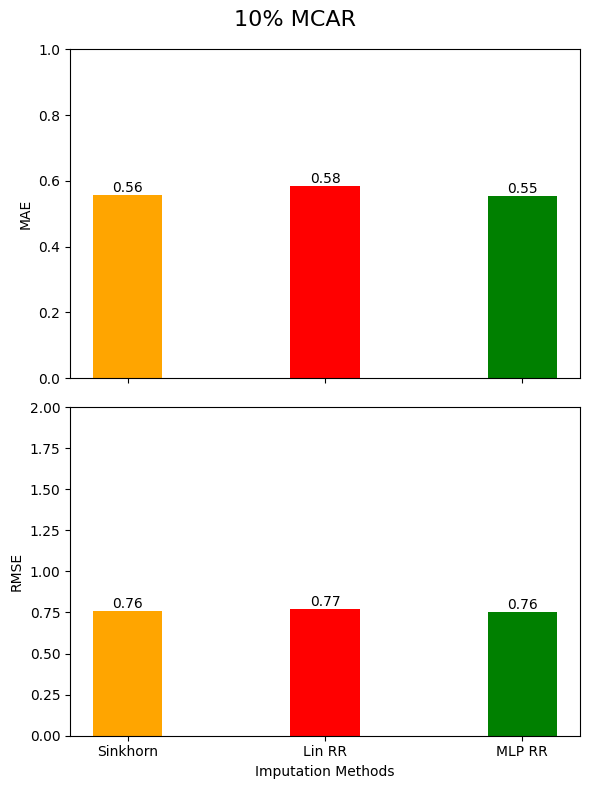

In [172]:

# Define values and categories
valuesOT_mae_mcar10 = [sk_mae_mcar10, lin_rr_mae_mcar10, mlp_rr_mae_mcar10]
valuesOT_rmse_mcar10 = [sk_rmse_mcar10,lin_rr_rmse_mcar10, mlp_rr_rmse_mcar10]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('10% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar10, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar10, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**15% MCAR**

In [173]:
#sinkhorn
n_mcar15, d_mcar15 = data_mcar15.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar15 = pick_epsilon(data_mcar15)

print(epsilon_mcar15)

sk_imputer_mcar15 = SinkhornImputation(eps=epsilon_mcar15, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar15, sk_maes15mcar, sk_rmses15mcar = sk_imputer_mcar15.fit_transform(data_mcar15, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar15_numpy = sk_imp_mcar15.detach().cpu().numpy()

sk_mae_mcar15 = MAE(sk_imp_mcar15_numpy,ground_truth_numpy ,mask_mcar15)
sk_rmse_mcar15 = RMSE(sk_imp_mcar15_numpy, ground_truth_numpy,mask_mcar15)
print(sk_mae_mcar15,sk_rmse_mcar15)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.5008
INFO:root:Iteration 0:	 Loss: 2.5466	 Validation MAE: 0.8654	RMSE: 1.0540


0.5008328716803875


INFO:root:Iteration 500:	 Loss: 2.1470	 Validation MAE: 0.5603	RMSE: 0.7728
INFO:root:Iteration 1000:	 Loss: 1.9331	 Validation MAE: 0.5540	RMSE: 0.7616
INFO:root:Iteration 1500:	 Loss: 1.5585	 Validation MAE: 0.5498	RMSE: 0.7563


0.5501877338179378 0.7555825379570089


In [174]:
#linear Round Robin
dmcar15_ = d_mcar15 - 1
models_liner_mcar15 = {}

for i in range(d_mcar15):
    models_liner_mcar15[i] = nn.Linear(dmcar15_, 1)

#Create the imputer
lin_rr_imputer_mcar15 = RRimputer(models_liner_mcar15, eps=epsilon_mcar15, lr=lr)
lin_rr_mcar15, lin_maesmcar15, lin_rmsesmcar15 = lin_rr_imputer_mcar15.fit_transform(data_mcar15, verbose=True, X_true=ground_truth)
lin_rr_mcar15_numpy = lin_rr_mcar15.detach().cpu().numpy()

lin_rr_mae_mcar15 = MAE(lin_rr_mcar15_numpy,ground_truth_numpy ,mask_mcar15)
lin_rr_rmse_mcar15 = RMSE(lin_rr_mcar15_numpy, ground_truth_numpy,mask_mcar15)
print(lin_rr_mae_mcar15,lin_rr_rmse_mcar15)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 2.1755	Validation MAE: 0.7115	RMSE:  0.9151
INFO:root:Iteration 1:	 Loss: 2.0387	Validation MAE: 0.6480	RMSE:  0.8509
INFO:root:Iteration 2:	 Loss: 2.0736	Validation MAE: 0.6257	RMSE:  0.8264
INFO:root:Iteration 3:	 Loss: 2.0503	Validation MAE: 0.6117	RMSE:  0.8103
INFO:root:Iteration 4:	 Loss: 1.9974	Validation MAE: 0.6052	RMSE:  0.7985
INFO:root:Iteration 5:	 Loss: 1.9289	Validation MAE: 0.6049	RMSE:  0.8015
INFO:root:Iteration 6:	 Loss: 2.0157	Validation MAE: 0.5929	RMSE:  0.7896
INFO:root:Iteration 7:	 Loss: 2.0243	Validation MAE: 0.5886	RMSE:  0.7857
INFO:root:Iteration 8:	 Loss: 1.9946	Validation MAE: 0.5918	RMSE:  0.7873
INFO:root:Iteration 9:	 Loss: 2.1658	Validation MAE: 0.5946	RMSE:  0.7916
INFO:root:Early stopping criterion not reached


0.5946027855557728 0.7916335718830229


In [175]:
#MLP Round Robin
dmcar15_ = d_mcar15 - 1
models_mlp_mcar15 = {}


for i in range(d_mcar15):
   models_mlp_mcar15[i] = nn.Sequential(nn.Linear(dmcar15_, 2 * dmcar15_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar15_, dmcar15_),
                              nn.ReLU(),
                              nn.Linear(dmcar15_, 1))

#Create the imputer
mlp_rr_imputer_mcar15 = RRimputer(models_mlp_mcar15, eps=epsilon_mcar15, lr=lr)

mlp_rr_mcar15, mlp_rr_maesmcar15, mlp_rr_rmsesmcar15 = mlp_rr_imputer_mcar15.fit_transform(data_mcar15, verbose=True, X_true=ground_truth)

mlp_rr_mcar15_numpy = mlp_rr_mcar15.detach().cpu().numpy()

mlp_rr_mae_mcar15 = MAE(mlp_rr_mcar15_numpy,ground_truth_numpy ,mask_mcar15)
mlp_rr_rmse_mcar15 = RMSE(mlp_rr_mcar15_numpy, ground_truth_numpy,mask_mcar15)
print(mlp_rr_mae_mcar15,mlp_rr_rmse_mcar15)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 2.0051	Validation MAE: 0.6199	RMSE:  0.8352
INFO:root:Iteration 1:	 Loss: 1.9871	Validation MAE: 0.5846	RMSE:  0.7925
INFO:root:Iteration 2:	 Loss: 2.0292	Validation MAE: 0.5690	RMSE:  0.7785
INFO:root:Iteration 3:	 Loss: 2.0142	Validation MAE: 0.5618	RMSE:  0.7608
INFO:root:Iteration 4:	 Loss: 2.1077	Validation MAE: 0.5700	RMSE:  0.7739
INFO:root:Iteration 5:	 Loss: 1.9693	Validation MAE: 0.5686	RMSE:  0.7692
INFO:root:Iteration 6:	 Loss: 1.9733	Validation MAE: 0.5632	RMSE:  0.7714
INFO:root:Iteration 7:	 Loss: 1.9381	Validation MAE: 0.5685	RMSE:  0.7808
INFO:root:Iteration 8:	 Loss: 1.8820	Validation MAE: 0.5569	RMSE:  0.7643
INFO:root:Iteration 9:	 Loss: 1.9773	Validation MAE: 0.5677	RMSE:  0.7849
INFO:root:Early stopping criterion not reached


0.5676716726861973 0.7849062373046215


In [176]:
#mean
#using numpy version of data
mean_imp_mcar15 = SimpleImputer().fit_transform(data_mcar15_numpy)
mean_mae_mcar15 = MAE(mean_imp_mcar15, ground_truth_numpy, mask_mcar15)
mean_rmse_mcar15= RMSE(mean_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(mean_mae_mcar15, mean_rmse_mcar15)

#ICE
ice_imp_mcar15 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar15_numpy)
ice_mae_mcar15 = MAE(ice_imp_mcar15, ground_truth_numpy, mask_mcar15)
ice_rmse_mcar15 = RMSE(ice_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(ice_mae_mcar15,ice_rmse_mcar15)

#SoftImpute
cv_error_mcar15, grid_lambda_mcar15 = cv_softimpute(data_mcar15_numpy, grid_len=15)
lbda_mcar15 = grid_lambda_mcar15[np.argmin(cv_error_mcar15)]
soft_imp_mcar15 = softimpute((data_mcar15_numpy), lbda_mcar15)[1]

soft_mae_mcar15 = MAE(soft_imp_mcar15, ground_truth_numpy, mask_mcar15)
soft_rmse_mcar15 = RMSE(soft_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(soft_mae_mcar15,soft_rmse_mcar15)



0.8620050840645891 1.0503788852986544
0.6016562019899981 0.7673245130234843
0.6317177134614647 0.8113810886573795


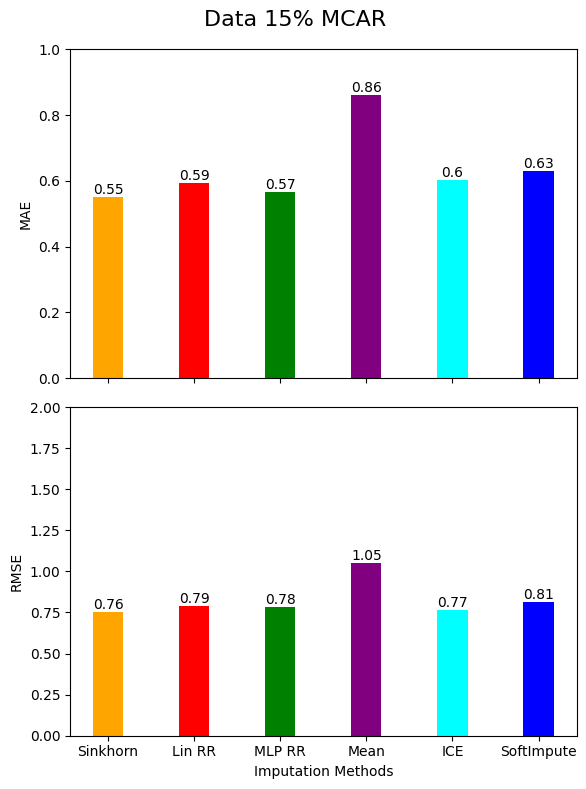

In [177]:

# Define values and categories
values_mae_mcar15 = [sk_mae_mcar15,lin_rr_mae_mcar15,mlp_rr_mae_mcar15, mean_mae_mcar15, ice_mae_mcar15, soft_mae_mcar15]
values_rmse_mcar15 = [sk_rmse_mcar15,lin_rr_rmse_mcar15,mlp_rr_rmse_mcar15, mean_rmse_mcar15, ice_rmse_mcar15, soft_rmse_mcar15]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 15% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar15, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar15, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


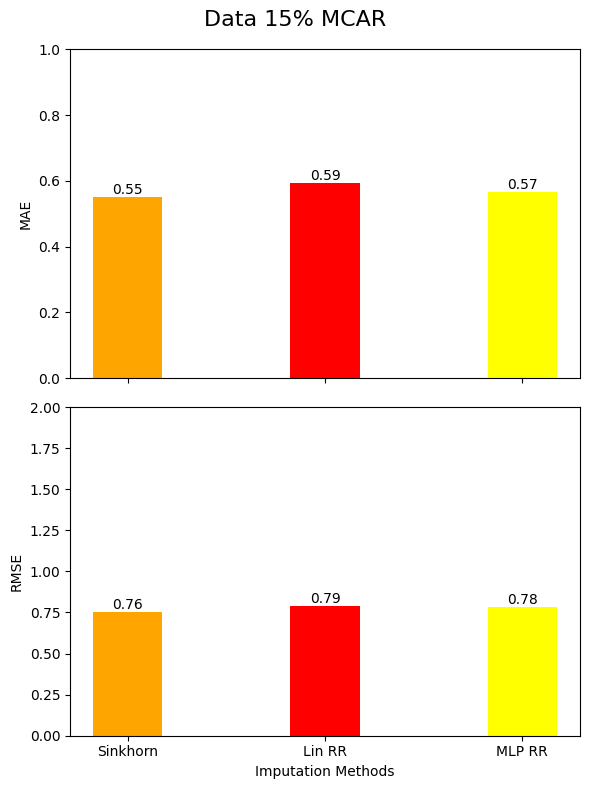

In [178]:

# Define values and categories
valuesOT_mae_mcar15 = [sk_mae_mcar15,lin_rr_mae_mcar15,mlp_rr_mae_mcar15]
valuesOT_rmse_mcar15 = [sk_rmse_mcar15,lin_rr_rmse_mcar15,mlp_rr_rmse_mcar15]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','yellow']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 15% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar15, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar15, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**20% MCAR**

In [179]:
#sinkhorn
n_mcar20, d_mcar20 = data_mcar20.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar20 = pick_epsilon(data_mcar20)

print(epsilon_mcar20)

sk_imputer_mcar20 = SinkhornImputation(eps=epsilon_mcar20, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar20, sk_maes20mcar, sk_rmses20mcar = sk_imputer_mcar20.fit_transform(data_mcar20, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar20_numpy = sk_imp_mcar20.detach().cpu().numpy()

sk_mae_mcar20 = MAE(sk_imp_mcar20_numpy,ground_truth_numpy ,mask_mcar20)
sk_rmse_mcar20 = RMSE(sk_imp_mcar20_numpy, ground_truth_numpy,mask_mcar20)
print(sk_mae_mcar20,sk_rmse_mcar20)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.4573
INFO:root:Iteration 0:	 Loss: 2.0273	 Validation MAE: 0.8666	RMSE: 1.0669


0.4573112351005496


INFO:root:Iteration 500:	 Loss: 1.5738	 Validation MAE: 0.5918	RMSE: 0.8360
INFO:root:Iteration 1000:	 Loss: 1.6667	 Validation MAE: 0.5951	RMSE: 0.8308
INFO:root:Iteration 1500:	 Loss: 1.8932	 Validation MAE: 0.5980	RMSE: 0.8240


0.5949971949259407 0.8218953566791392


In [180]:
#linear Round Robin
dmcar20_ = d_mcar20 - 1
models_liner_mcar20 = {}

for i in range(d_mcar20):
    models_liner_mcar20[i] = nn.Linear(dmcar20_, 1)

#Create the imputer
lin_rr_imputer_mcar20 = RRimputer(models_liner_mcar20, eps=epsilon_mcar20, lr=lr)
lin_rr_mcar20, lin_maesmcar20, lin_rmsesmcar20 = lin_rr_imputer_mcar20.fit_transform(data_mcar20, verbose=True, X_true=ground_truth)
lin_rr_mcar20_numpy = lin_rr_mcar20.detach().cpu().numpy()

lin_rr_mae_mcar20 = MAE(lin_rr_mcar20_numpy,ground_truth_numpy ,mask_mcar20)
lin_rr_rmse_mcar20 = RMSE(lin_rr_mcar20_numpy, ground_truth_numpy,mask_mcar20)
print(lin_rr_mae_mcar20,lin_rr_rmse_mcar20)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.9835	Validation MAE: 0.7283	RMSE:  0.9572
INFO:root:Iteration 1:	 Loss: 1.8608	Validation MAE: 0.6638	RMSE:  0.8915
INFO:root:Iteration 2:	 Loss: 1.9194	Validation MAE: 0.6482	RMSE:  0.8726
INFO:root:Iteration 3:	 Loss: 1.8466	Validation MAE: 0.6383	RMSE:  0.8572
INFO:root:Iteration 4:	 Loss: 1.9384	Validation MAE: 0.6286	RMSE:  0.8459
INFO:root:Iteration 5:	 Loss: 1.9339	Validation MAE: 0.6251	RMSE:  0.8455
INFO:root:Iteration 6:	 Loss: 1.8248	Validation MAE: 0.6203	RMSE:  0.8391
INFO:root:Iteration 7:	 Loss: 1.9280	Validation MAE: 0.6231	RMSE:  0.8416
INFO:root:Iteration 8:	 Loss: 1.7613	Validation MAE: 0.6146	RMSE:  0.8353
INFO:root:Iteration 9:	 Loss: 1.9828	Validation MAE: 0.6146	RMSE:  0.8338
INFO:root:Early stopping criterion not reached


0.6146147132951759 0.8337636474313764


In [181]:
#MLP Round Robin
dmcar20_ = d_mcar20 - 1
models_mlp_mcar20 = {}


for i in range(d_mcar20):
   models_mlp_mcar20[i] = nn.Sequential(nn.Linear(dmcar20_, 2 * dmcar20_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar20_, dmcar20_),
                              nn.ReLU(),
                              nn.Linear(dmcar20_, 1))

#Create the imputer
mlp_rr_imputer_mcar20 = RRimputer(models_mlp_mcar20, eps=epsilon_mcar20, lr=lr)

mlp_rr_mcar20, mlp_rr_maesmcar20, mlp_rr_rmsesmcar20 = mlp_rr_imputer_mcar20.fit_transform(data_mcar20, verbose=True, X_true=ground_truth)

mlp_rr_mcar20_numpy = mlp_rr_mcar20.detach().cpu().numpy()

mlp_rr_mae_mcar20 = MAE(mlp_rr_mcar20_numpy,ground_truth_numpy ,mask_mcar20)
mlp_rr_rmse_mcar20 = RMSE(mlp_rr_mcar20_numpy, ground_truth_numpy,mask_mcar20)
print(mlp_rr_mae_mcar20,mlp_rr_rmse_mcar20)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.


INFO:root:Iteration 0:	 Loss: 2.0566	Validation MAE: 0.6317	RMSE:  0.8759
INFO:root:Iteration 1:	 Loss: 1.9494	Validation MAE: 0.6023	RMSE:  0.8340
INFO:root:Iteration 2:	 Loss: 1.6830	Validation MAE: 0.5916	RMSE:  0.8194
INFO:root:Iteration 3:	 Loss: 1.7833	Validation MAE: 0.5941	RMSE:  0.8243
INFO:root:Iteration 4:	 Loss: 1.9314	Validation MAE: 0.6026	RMSE:  0.8392
INFO:root:Iteration 5:	 Loss: 1.8720	Validation MAE: 0.6031	RMSE:  0.8369
INFO:root:Iteration 6:	 Loss: 1.8365	Validation MAE: 0.5988	RMSE:  0.8384
INFO:root:Iteration 7:	 Loss: 1.8716	Validation MAE: 0.5929	RMSE:  0.8390
INFO:root:Iteration 8:	 Loss: 1.9453	Validation MAE: 0.5914	RMSE:  0.8229
INFO:root:Iteration 9:	 Loss: 2.0948	Validation MAE: 0.5996	RMSE:  0.8391
INFO:root:Early stopping criterion not reached


0.599583202957092 0.8391043148230116


In [182]:
#mean
#using numpy version of data
mean_imp_mcar20 = SimpleImputer().fit_transform(data_mcar20_numpy)
mean_mae_mcar20 = MAE(mean_imp_mcar20, ground_truth_numpy, mask_mcar20)
mean_rmse_mcar20= RMSE(mean_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(mean_mae_mcar20, mean_rmse_mcar20)

#ICE
ice_imp_mcar20 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar20_numpy)
ice_mae_mcar20 = MAE(ice_imp_mcar20, ground_truth_numpy, mask_mcar20)
ice_rmse_mcar20 = RMSE(ice_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(ice_mae_mcar20,ice_rmse_mcar20)

#SoftImpute
cv_error_mcar20, grid_lambda_mcar20 = cv_softimpute(data_mcar20_numpy, grid_len=15)
lbda_mcar20 = grid_lambda_mcar20[np.argmin(cv_error_mcar20)]
soft_imp_mcar20 = softimpute((data_mcar20_numpy), lbda_mcar20)[1]

soft_mae_mcar20 = MAE(soft_imp_mcar20, ground_truth_numpy, mask_mcar20)
soft_rmse_mcar20 = RMSE(soft_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(soft_mae_mcar20,soft_rmse_mcar20)

0.8650779613328174 1.063643033076626
0.7804614007736548 1.0634141555629082
0.6274176296801445 0.8282953689458554


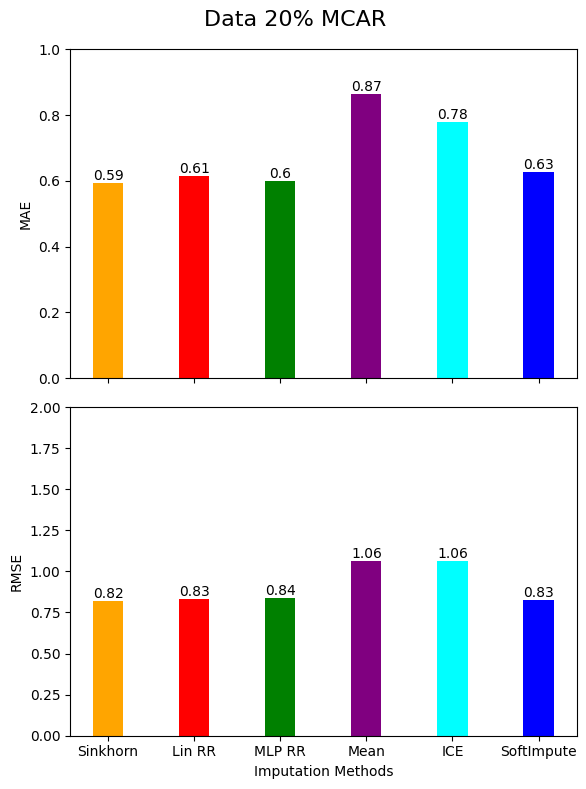

In [183]:

# Define values and categories
values_mae_mcar20 = [sk_mae_mcar20,lin_rr_mae_mcar20,mlp_rr_mae_mcar20, mean_mae_mcar20, ice_mae_mcar20, soft_mae_mcar20]
values_rmse_mcar20 = [sk_rmse_mcar20,lin_rr_rmse_mcar20,mlp_rr_rmse_mcar20, mean_rmse_mcar20, ice_rmse_mcar20, soft_rmse_mcar20]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 20% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar20, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar20, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


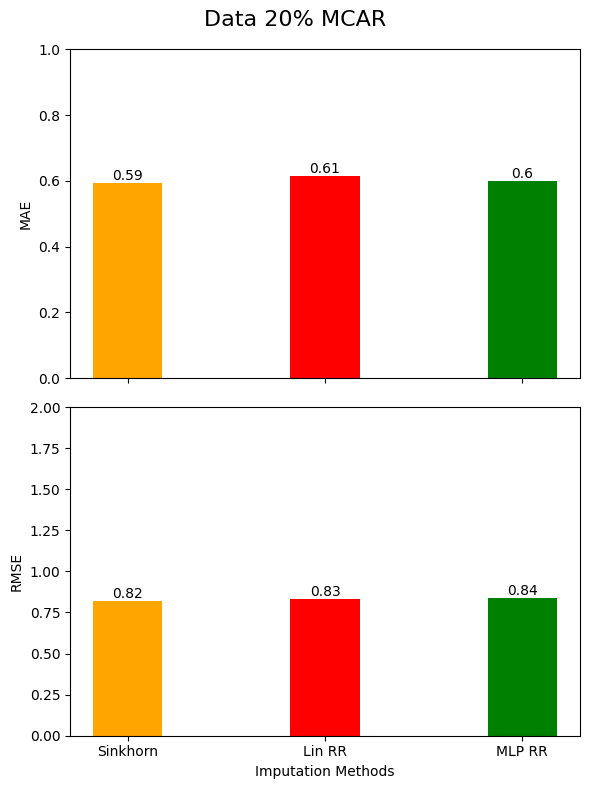

In [264]:

# Define values and categories
valuesOT_mae_mcar20 = [sk_mae_mcar20,lin_rr_mae_mcar20,mlp_rr_mae_mcar20]
valuesOT_rmse_mcar20 = [sk_rmse_mcar20,lin_rr_rmse_mcar20,mlp_rr_rmse_mcar20]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 20% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar20, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar20, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**25% MCAR**

In [185]:
#sinkhorn
n_mcar25, d_mcar25 = data_mcar25.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar25 = pick_epsilon(data_mcar25)

print(epsilon_mcar25)

sk_imputer_mcar25 = SinkhornImputation(eps=epsilon_mcar25, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar25, sk_maes25mcar, sk_rmses25mcar = sk_imputer_mcar25.fit_transform(data_mcar25, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar25_numpy = sk_imp_mcar25.detach().cpu().numpy()

sk_mae_mcar25 = MAE(sk_imp_mcar25_numpy,ground_truth_numpy,mask_mcar25)
sk_rmse_mcar25 = RMSE(sk_imp_mcar25_numpy, ground_truth_numpy,mask_mcar25)
print(sk_mae_mcar25,sk_rmse_mcar25)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.4274
INFO:root:Iteration 0:	 Loss: 2.1752	 Validation MAE: 0.8411	RMSE: 1.0429


0.42741291915987206


INFO:root:Iteration 500:	 Loss: 1.5453	 Validation MAE: 0.5839	RMSE: 0.8119
INFO:root:Iteration 1000:	 Loss: 1.6670	 Validation MAE: 0.5947	RMSE: 0.8217
INFO:root:Iteration 1500:	 Loss: 1.2492	 Validation MAE: 0.5978	RMSE: 0.8262


0.592637160795712 0.8280297463489802


In [186]:
#linear Round Robin
dmcar25_ = d_mcar25 - 1
models_liner_mcar25 = {}

for i in range(d_mcar25):
    models_liner_mcar25[i] = nn.Linear(dmcar25_, 1)

#Create the imputer
lin_rr_imputer_mcar25 = RRimputer(models_liner_mcar25, eps=epsilon_mcar25, lr=lr)
lin_rr_mcar25, lin_maesmcar25, lin_rmsesmcar25 = lin_rr_imputer_mcar25.fit_transform(data_mcar25, verbose=True, X_true=ground_truth)
lin_rr_mcar25_numpy = lin_rr_mcar25.detach().cpu().numpy()

lin_rr_mae_mcar25 = MAE(lin_rr_mcar25_numpy,ground_truth_numpy,mask_mcar25)
lin_rr_rmse_mcar25 = RMSE(lin_rr_mcar25_numpy, ground_truth_numpy,mask_mcar25)
print(lin_rr_mae_mcar25,lin_rr_rmse_mcar25)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.9966	Validation MAE: 0.6719	RMSE:  0.9067
INFO:root:Iteration 1:	 Loss: 2.0337	Validation MAE: 0.6449	RMSE:  0.8734
INFO:root:Iteration 2:	 Loss: 1.8319	Validation MAE: 0.6297	RMSE:  0.8430
INFO:root:Iteration 3:	 Loss: 1.6524	Validation MAE: 0.6210	RMSE:  0.8297
INFO:root:Iteration 4:	 Loss: 1.7514	Validation MAE: 0.6162	RMSE:  0.8221
INFO:root:Iteration 5:	 Loss: 1.8214	Validation MAE: 0.6123	RMSE:  0.8241
INFO:root:Iteration 6:	 Loss: 1.8499	Validation MAE: 0.6089	RMSE:  0.8189
INFO:root:Iteration 7:	 Loss: 1.6857	Validation MAE: 0.6093	RMSE:  0.8230
INFO:root:Iteration 8:	 Loss: 1.7881	Validation MAE: 0.6088	RMSE:  0.8251
INFO:root:Iteration 9:	 Loss: 1.7644	Validation MAE: 0.6119	RMSE:  0.8247
INFO:root:Early stopping criterion not reached


0.6118631340567414 0.8247285904992309


In [187]:
#MLP Round Robin
dmcar25_ = d_mcar25 - 1
models_mlp_mcar25 = {}


for i in range(d_mcar25):
   models_mlp_mcar25[i] = nn.Sequential(nn.Linear(dmcar25_, 2 * dmcar25_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar25_, dmcar25_),
                              nn.ReLU(),
                              nn.Linear(dmcar25_, 1))

#Create the imputer
mlp_rr_imputer_mcar25 = RRimputer(models_mlp_mcar25, eps=epsilon_mcar25, lr=lr)

mlp_rr_mcar25, mlp_rr_maesmcar25, mlp_rr_rmsesmcar25 = mlp_rr_imputer_mcar25.fit_transform(data_mcar25, verbose=True, X_true=ground_truth)

mlp_rr_mcar25_numpy = mlp_rr_mcar25.detach().cpu().numpy()

mlp_rr_mae_mcar25 = MAE(mlp_rr_mcar25_numpy,ground_truth_numpy,mask_mcar25)
mlp_rr_rmse_mcar25 = RMSE(mlp_rr_mcar25_numpy, ground_truth_numpy,mask_mcar25)
print(mlp_rr_mae_mcar25,mlp_rr_rmse_mcar25)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.


INFO:root:Iteration 0:	 Loss: 1.8538	Validation MAE: 0.6274	RMSE:  0.8709
INFO:root:Iteration 1:	 Loss: 1.8320	Validation MAE: 0.6160	RMSE:  0.8451
INFO:root:Iteration 2:	 Loss: 1.9331	Validation MAE: 0.6059	RMSE:  0.8371
INFO:root:Iteration 3:	 Loss: 1.8386	Validation MAE: 0.5948	RMSE:  0.8280
INFO:root:Iteration 4:	 Loss: 1.6563	Validation MAE: 0.6018	RMSE:  0.8269
INFO:root:Iteration 5:	 Loss: 1.7105	Validation MAE: 0.6088	RMSE:  0.8322
INFO:root:Iteration 6:	 Loss: 1.7222	Validation MAE: 0.6138	RMSE:  0.8394
INFO:root:Iteration 7:	 Loss: 1.7703	Validation MAE: 0.6240	RMSE:  0.8479
INFO:root:Iteration 8:	 Loss: 1.7563	Validation MAE: 0.6180	RMSE:  0.8448
INFO:root:Iteration 9:	 Loss: 1.9556	Validation MAE: 0.6196	RMSE:  0.8472
INFO:root:Early stopping criterion not reached


0.6195974976607591 0.8471960336897614


In [188]:
#mean
#using numpy version of data
mean_imp_mcar25 = SimpleImputer().fit_transform(data_mcar25_numpy)
mean_mae_mcar25 = MAE(mean_imp_mcar25, ground_truth_numpy, mask_mcar25)
mean_rmse_mcar25= RMSE(mean_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(mean_mae_mcar25, mean_rmse_mcar25)

#ICE
ice_imp_mcar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar25_numpy)
ice_mae_mcar25 = MAE(ice_imp_mcar25, ground_truth_numpy, mask_mcar25)
ice_rmse_mcar25 = RMSE(ice_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(ice_mae_mcar25,ice_rmse_mcar25)

#SoftImpute
cv_error_mcar25, grid_lambda_mcar25 = cv_softimpute(data_mcar25_numpy, grid_len=15)
lbda_mcar25 = grid_lambda_mcar25[np.argmin(cv_error_mcar25)]
soft_imp_mcar25 = softimpute((data_mcar25_numpy), lbda_mcar25)[1]

soft_mae_mcar25 = MAE(soft_imp_mcar25, ground_truth_numpy, mask_mcar25)
soft_rmse_mcar25 = RMSE(soft_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(soft_mae_mcar25,soft_rmse_mcar25)

0.8380681332032784 1.0407542330179316
0.757916902487786 1.0196437356256995
0.6250309293217298 0.8270085139510432


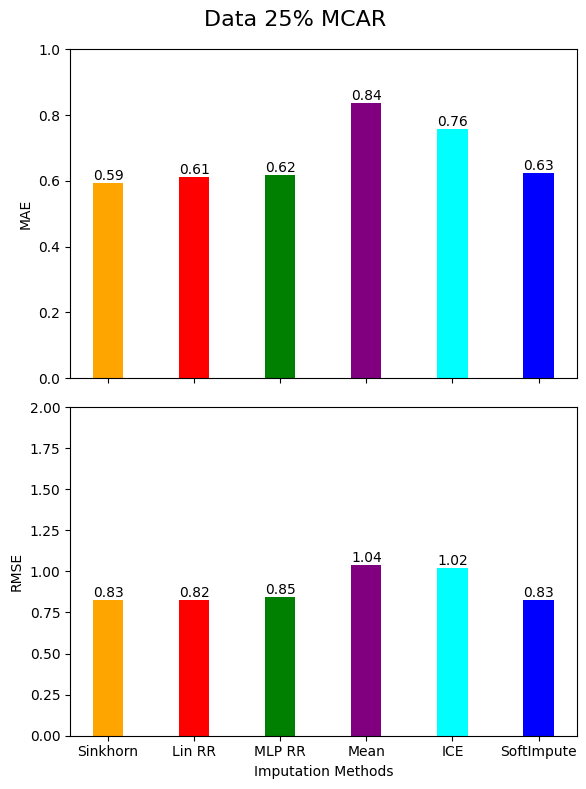

In [189]:

# Define values and categories
values_mae_mcar25 = [sk_mae_mcar25,lin_rr_mae_mcar25,mlp_rr_mae_mcar25, mean_mae_mcar25, ice_mae_mcar25, soft_mae_mcar25]
values_rmse_mcar25 = [sk_rmse_mcar25,lin_rr_rmse_mcar25,mlp_rr_rmse_mcar25, mean_rmse_mcar25, ice_rmse_mcar25, soft_rmse_mcar25]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar25, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar25, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


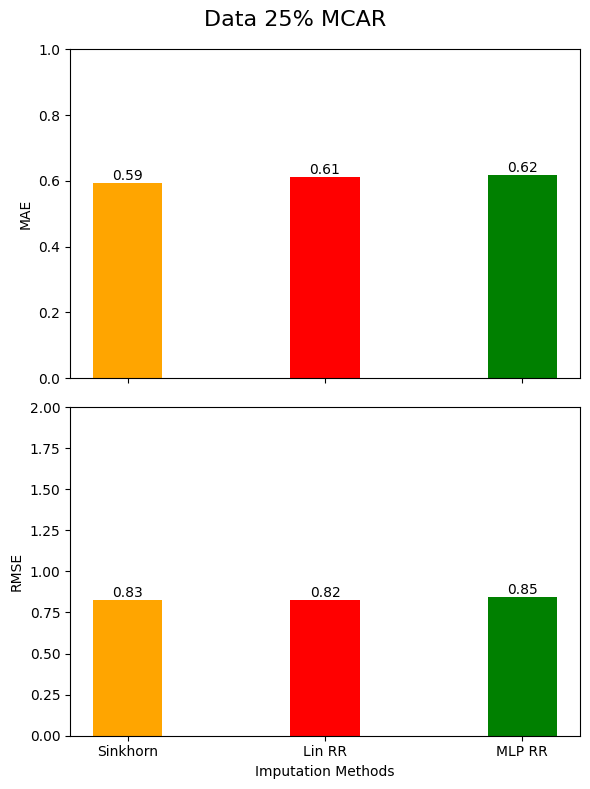

In [190]:

# Define values and categories
valuesOT_mae_mcar25 = [sk_mae_mcar25,lin_rr_mae_mcar25,mlp_rr_mae_mcar25]
valuesOT_rmse_mcar25 = [sk_rmse_mcar25,lin_rr_rmse_mcar25,mlp_rr_rmse_mcar25]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar25, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar25, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**30% MCAR**

In [191]:
#sinkhorn
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(data_mcar30)
print(epsilon_mcar30)

sk_imputer_mcar30 = SinkhornImputation(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar = sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.3997
INFO:root:Iteration 0:	 Loss: 2.0040	 Validation MAE: 0.8425	RMSE: 1.0430


0.39971389591590073


INFO:root:Iteration 500:	 Loss: 2.0514	 Validation MAE: 0.5749	RMSE: 0.7944
INFO:root:Iteration 1000:	 Loss: 1.5557	 Validation MAE: 0.5715	RMSE: 0.7949
INFO:root:Iteration 1500:	 Loss: 1.6769	 Validation MAE: 0.5852	RMSE: 0.8072


0.5837110963782504 0.8060424497907205


In [192]:
#linear Round Robin
dmcar30_ = d_mcar30 - 1
models_liner_mcar30 = {}

for i in range(d_mcar30):
    models_liner_mcar30[i] = nn.Linear(dmcar30_, 1)

#Create the imputer
lin_rr_imputer_mcar30 = RRimputer(models_liner_mcar30, eps=epsilon_mcar30, lr=lr)
lin_rr_mcar30, lin_maesmcar30, lin_rmsesmcar30 = lin_rr_imputer_mcar30.fit_transform(data_mcar30, verbose=True, X_true=ground_truth)
lin_rr_mcar30_numpy = lin_rr_mcar30.detach().cpu().numpy()

lin_rr_mae_mcar30 = MAE(lin_rr_mcar30_numpy,ground_truth_numpy,mask_mcar30)
lin_rr_rmse_mcar30 = RMSE(lin_rr_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(lin_rr_mae_mcar30,lin_rr_rmse_mcar30)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.9623	Validation MAE: 0.6895	RMSE:  0.9164
INFO:root:Iteration 1:	 Loss: 1.7677	Validation MAE: 0.6487	RMSE:  0.8755
INFO:root:Iteration 2:	 Loss: 1.6993	Validation MAE: 0.6317	RMSE:  0.8475
INFO:root:Iteration 3:	 Loss: 1.7638	Validation MAE: 0.6286	RMSE:  0.8495
INFO:root:Iteration 4:	 Loss: 1.6901	Validation MAE: 0.6173	RMSE:  0.8306
INFO:root:Iteration 5:	 Loss: 1.6516	Validation MAE: 0.6143	RMSE:  0.8324
INFO:root:Iteration 6:	 Loss: 1.6885	Validation MAE: 0.6156	RMSE:  0.8296
INFO:root:Iteration 7:	 Loss: 1.6431	Validation MAE: 0.6153	RMSE:  0.8314
INFO:root:Iteration 8:	 Loss: 1.7202	Validation MAE: 0.6141	RMSE:  0.8291
INFO:root:Iteration 9:	 Loss: 1.7710	Validation MAE: 0.6113	RMSE:  0.8290
INFO:root:Early stopping criterion not reached


0.6112631344767447 0.8289756321742308


In [193]:
#MLP Round Robin
dmcar30_ = d_mcar30 - 1
models_mlp_mcar30 = {}


for i in range(d_mcar30):
   models_mlp_mcar30[i] = nn.Sequential(nn.Linear(dmcar30_, 2 * dmcar30_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar30_, dmcar30_),
                              nn.ReLU(),
                              nn.Linear(dmcar30_, 1))

#Create the imputer
mlp_rr_imputer_mcar30 = RRimputer(models_mlp_mcar30, eps=epsilon_mcar30, lr=lr)

mlp_rr_mcar30, mlp_rr_maesmcar30, mlp_rr_rmsesmcar30 = mlp_rr_imputer_mcar30.fit_transform(data_mcar30, verbose=True, X_true=ground_truth)

mlp_rr_mcar30_numpy = mlp_rr_mcar30.detach().cpu().numpy()

mlp_rr_mae_mcar30 = MAE(mlp_rr_mcar30_numpy,ground_truth_numpy,mask_mcar30)
mlp_rr_rmse_mcar30 = RMSE(mlp_rr_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(mlp_rr_mae_mcar30, mlp_rr_rmse_mcar30)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.8285	Validation MAE: 0.6452	RMSE:  0.8719
INFO:root:Iteration 1:	 Loss: 1.6961	Validation MAE: 0.5954	RMSE:  0.8100
INFO:root:Iteration 2:	 Loss: 1.7190	Validation MAE: 0.5852	RMSE:  0.8043
INFO:root:Iteration 3:	 Loss: 1.6149	Validation MAE: 0.5901	RMSE:  0.8043
INFO:root:Iteration 4:	 Loss: 1.6186	Validation MAE: 0.5839	RMSE:  0.7942
INFO:root:Iteration 5:	 Loss: 1.7205	Validation MAE: 0.5981	RMSE:  0.8168
INFO:root:Iteration 6:	 Loss: 1.9416	Validation MAE: 0.5969	RMSE:  0.8172
INFO:root:Iteration 7:	 Loss: 1.6484	Validation MAE: 0.5941	RMSE:  0.8142
INFO:root:Iteration 8:	 Loss: 1.6119	Validation MAE: 0.5949	RMSE:  0.8143
INFO:root:Iteration 9:	 Loss: 1.8056	Validation MAE: 0.5997	RMSE:  0.8269
INFO:root:Early stopping criterion not reached


0.599733335041335 0.8268905962638251


In [194]:
#mean
#using numpy version of data
mean_imp_mcar30 = SimpleImputer().fit_transform(data_mcar30_numpy)
mean_mae_mcar30 = MAE(mean_imp_mcar30, ground_truth_numpy, mask_mcar30)
mean_rmse_mcar30= RMSE(mean_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(mean_mae_mcar30, mean_rmse_mcar30)

#ICE
ice_imp_mcar30 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar30_numpy)
ice_mae_mcar30 = MAE(ice_imp_mcar30, ground_truth_numpy, mask_mcar30)
ice_rmse_mcar30 = RMSE(ice_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(ice_mae_mcar30,ice_rmse_mcar30)

#SoftImpute
cv_error_mcar30, grid_lambda_mcar30 = cv_softimpute(data_mcar30_numpy, grid_len=15)
lbda_mcar30 = grid_lambda_mcar30[np.argmin(cv_error_mcar30)]
soft_imp_mcar30 = softimpute((data_mcar30_numpy), lbda_mcar30)[1]

soft_mae_mcar30 = MAE(soft_imp_mcar30, ground_truth_numpy, mask_mcar30)
soft_rmse_mcar30 = RMSE(soft_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(soft_mae_mcar30,soft_rmse_mcar30)

0.8355054414126526 1.0340881947267617
0.730146156061971 0.9823398349392125
0.621637229175994 0.816931987094378


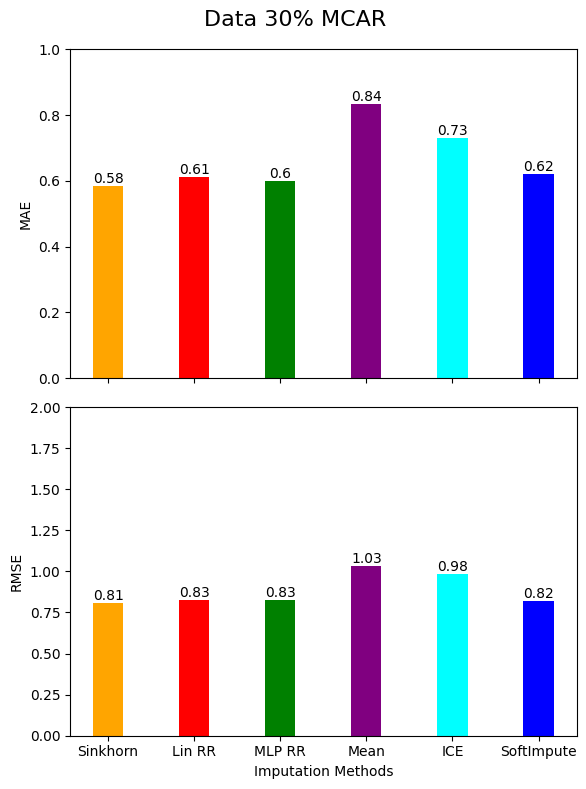

In [195]:

# Define values and categories
values_mae_mcar30 = [sk_mae_mcar30,lin_rr_mae_mcar30,mlp_rr_mae_mcar30, mean_mae_mcar30, ice_mae_mcar30, soft_mae_mcar30]
values_rmse_mcar30 = [sk_rmse_mcar30,lin_rr_rmse_mcar30,mlp_rr_rmse_mcar30, mean_rmse_mcar30, ice_rmse_mcar30, soft_rmse_mcar30]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 30% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar30, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar30, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


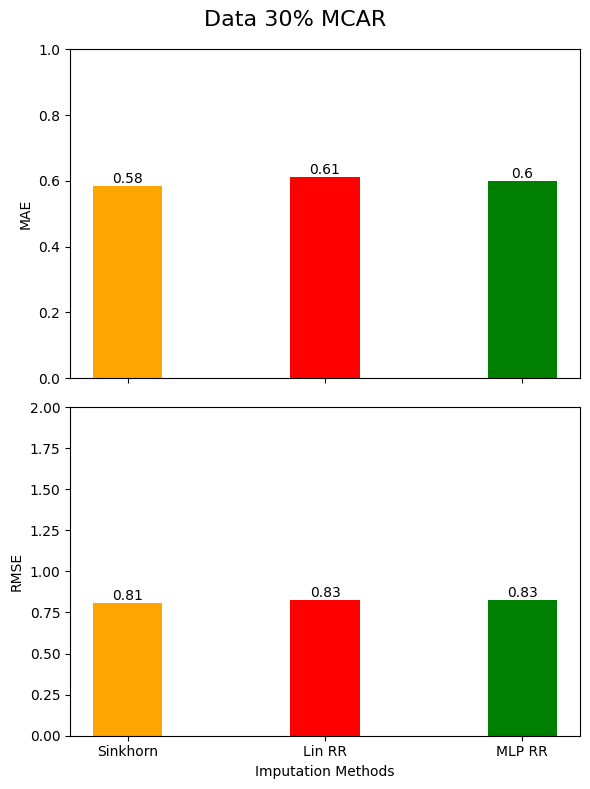

In [196]:

# Define values and categories
valuesOT_mae_mcar30 = [sk_mae_mcar30,lin_rr_mae_mcar30,mlp_rr_mae_mcar30]
valuesOT_rmse_mcar30 = [sk_rmse_mcar30,lin_rr_rmse_mcar30,mlp_rr_rmse_mcar30]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 30% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar30, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar30, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**35% MCAR**

In [197]:
#sinkhorn
n_mcar35, d_mcar35 = data_mcar35.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar35 = pick_epsilon(data_mcar35)

print(epsilon_mcar35)

sk_imputer_mcar35 = SinkhornImputation(eps=epsilon_mcar35, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar35, sk_maes35mcar, sk_rmses35mcar = sk_imputer_mcar35.fit_transform(data_mcar35, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar35_numpy = sk_imp_mcar35.detach().cpu().numpy()

sk_mae_mcar35 = MAE(sk_imp_mcar35_numpy,ground_truth_numpy,mask_mcar35)
sk_rmse_mcar35 = RMSE(sk_imp_mcar35_numpy, ground_truth_numpy,mask_mcar35)
print(sk_mae_mcar35,sk_rmse_mcar35)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.3678
INFO:root:Iteration 0:	 Loss: 1.9632	 Validation MAE: 0.8437	RMSE: 1.0411


0.36782423673366615


INFO:root:Iteration 500:	 Loss: 1.6572	 Validation MAE: 0.5849	RMSE: 0.8127
INFO:root:Iteration 1000:	 Loss: 1.4808	 Validation MAE: 0.5805	RMSE: 0.8026
INFO:root:Iteration 1500:	 Loss: 1.4889	 Validation MAE: 0.5756	RMSE: 0.7995


0.5751773528613403 0.7952982510497327


In [198]:
#linear Round Robin
dmcar35_ = d_mcar35 - 1
models_liner_mcar35 = {}

for i in range(d_mcar35):
    models_liner_mcar35[i] = nn.Linear(dmcar35_, 1)

#Create the imputer
lin_rr_imputer_mcar35 = RRimputer(models_liner_mcar35, eps=epsilon_mcar35, lr=lr)
lin_rr_mcar35, lin_maesmcar35, lin_rmsesmcar35 = lin_rr_imputer_mcar35.fit_transform(data_mcar35, verbose=True, X_true=ground_truth)
lin_rr_mcar35_numpy = lin_rr_mcar35.detach().cpu().numpy()

lin_rr_mae_mcar35 = MAE(lin_rr_mcar35_numpy,ground_truth_numpy ,mask_mcar35)
lin_rr_rmse_mcar35 = RMSE(lin_rr_mcar35_numpy,ground_truth_numpy,mask_mcar35)
print(lin_rr_mae_mcar35,lin_rr_rmse_mcar35)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.8837	Validation MAE: 0.6813	RMSE:  0.9060
INFO:root:Iteration 1:	 Loss: 1.5976	Validation MAE: 0.6384	RMSE:  0.8647
INFO:root:Iteration 2:	 Loss: 1.5802	Validation MAE: 0.6343	RMSE:  0.8610
INFO:root:Iteration 3:	 Loss: 1.6246	Validation MAE: 0.6229	RMSE:  0.8489
INFO:root:Iteration 4:	 Loss: 1.7072	Validation MAE: 0.6199	RMSE:  0.8432
INFO:root:Iteration 5:	 Loss: 1.7285	Validation MAE: 0.6157	RMSE:  0.8387
INFO:root:Iteration 6:	 Loss: 1.5236	Validation MAE: 0.6165	RMSE:  0.8426
INFO:root:Iteration 7:	 Loss: 1.7296	Validation MAE: 0.6169	RMSE:  0.8395
INFO:root:Iteration 8:	 Loss: 1.7083	Validation MAE: 0.6213	RMSE:  0.8474
INFO:root:Iteration 9:	 Loss: 1.5886	Validation MAE: 0.6168	RMSE:  0.8432
INFO:root:Early stopping criterion not reached


0.6168361851983482 0.8431995744008245


In [199]:
#MLP Round Robin
dmcar35_ = d_mcar35 - 1
models_mlp_mcar35 = {}


for i in range(d_mcar35):
   models_mlp_mcar35[i] = nn.Sequential(nn.Linear(dmcar35_, 2 * dmcar35_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar35_, dmcar35_),
                              nn.ReLU(),
                              nn.Linear(dmcar35_, 1))

#Create the imputer
mlp_rr_imputer_mcar35 = RRimputer(models_mlp_mcar35, eps=epsilon_mcar35, lr=lr)

mlp_rr_mcar35, mlp_rr_maesmcar35, mlp_rr_rmsesmcar35 = mlp_rr_imputer_mcar35.fit_transform(data_mcar35, verbose=True, X_true=ground_truth)

mlp_rr_mcar35_numpy = mlp_rr_mcar35.detach().cpu().numpy()

mlp_rr_mae_mcar35 = MAE(mlp_rr_mcar35_numpy,ground_truth_numpy ,mask_mcar35)
mlp_rr_rmse_mcar35 = RMSE(mlp_rr_mcar35_numpy, ground_truth_numpy,mask_mcar35)
print(mlp_rr_mae_mcar35, mlp_rr_rmse_mcar35)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.


INFO:root:Iteration 0:	 Loss: 1.8002	Validation MAE: 0.6318	RMSE:  0.8667
INFO:root:Iteration 1:	 Loss: 1.5491	Validation MAE: 0.6182	RMSE:  0.8463
INFO:root:Iteration 2:	 Loss: 1.7520	Validation MAE: 0.6052	RMSE:  0.8479
INFO:root:Iteration 3:	 Loss: 1.5529	Validation MAE: 0.6049	RMSE:  0.8441
INFO:root:Iteration 4:	 Loss: 1.4943	Validation MAE: 0.6008	RMSE:  0.8451
INFO:root:Iteration 5:	 Loss: 1.6120	Validation MAE: 0.6134	RMSE:  0.8580
INFO:root:Iteration 6:	 Loss: 1.5479	Validation MAE: 0.6128	RMSE:  0.8613
INFO:root:Iteration 7:	 Loss: 1.5678	Validation MAE: 0.6033	RMSE:  0.8495
INFO:root:Iteration 8:	 Loss: 1.7277	Validation MAE: 0.6030	RMSE:  0.8548
INFO:root:Iteration 9:	 Loss: 1.6264	Validation MAE: 0.5995	RMSE:  0.8442
INFO:root:Early stopping criterion not reached


0.5995356668629318 0.8442386828022633


In [200]:
#mean
#using numpy version of data
mean_imp_mcar35 = SimpleImputer().fit_transform(data_mcar35_numpy)
mean_mae_mcar35 = MAE(mean_imp_mcar35, ground_truth_numpy, mask_mcar35)
mean_rmse_mcar35 = RMSE(mean_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(mean_mae_mcar35, mean_rmse_mcar35)

#ICE
ice_imp_mcar35 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar35_numpy)
ice_mae_mcar35 = MAE(ice_imp_mcar35, ground_truth_numpy, mask_mcar35)
ice_rmse_mcar35 = RMSE(ice_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(ice_mae_mcar35,ice_rmse_mcar35)

#SoftImpute
cv_error_mcar35, grid_lambda_mcar35 = cv_softimpute(data_mcar35_numpy, grid_len=15)
lbda_mcar35 = grid_lambda_mcar35[np.argmin(cv_error_mcar35)]
soft_imp_mcar35 = softimpute((data_mcar35_numpy), lbda_mcar35)[1]

soft_mae_mcar35 = MAE(soft_imp_mcar35, ground_truth_numpy, mask_mcar35)
soft_rmse_mcar35 = RMSE(soft_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(soft_mae_mcar35,soft_rmse_mcar35)

0.8425161737064246 1.0378023549111859
0.712859196767655 0.9530281117411474
0.637045852351681 0.8335496572111154


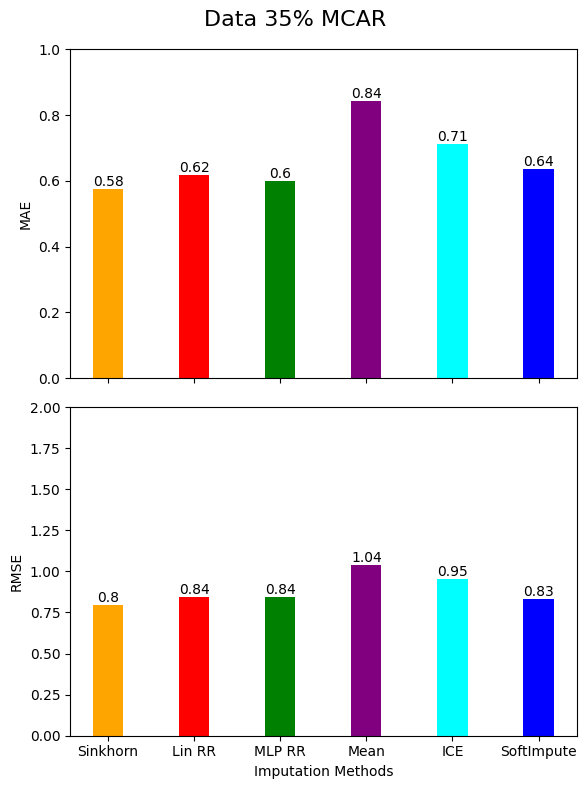

In [201]:

# Define values and categories
values_mae_mcar35 = [sk_mae_mcar35,lin_rr_mae_mcar35,mlp_rr_mae_mcar35, mean_mae_mcar35, ice_mae_mcar35, soft_mae_mcar35]
values_rmse_mcar35 = [sk_rmse_mcar35, lin_rr_rmse_mcar35, mlp_rr_rmse_mcar35, mean_rmse_mcar35, ice_rmse_mcar35, soft_rmse_mcar35]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 35% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar35, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar35, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


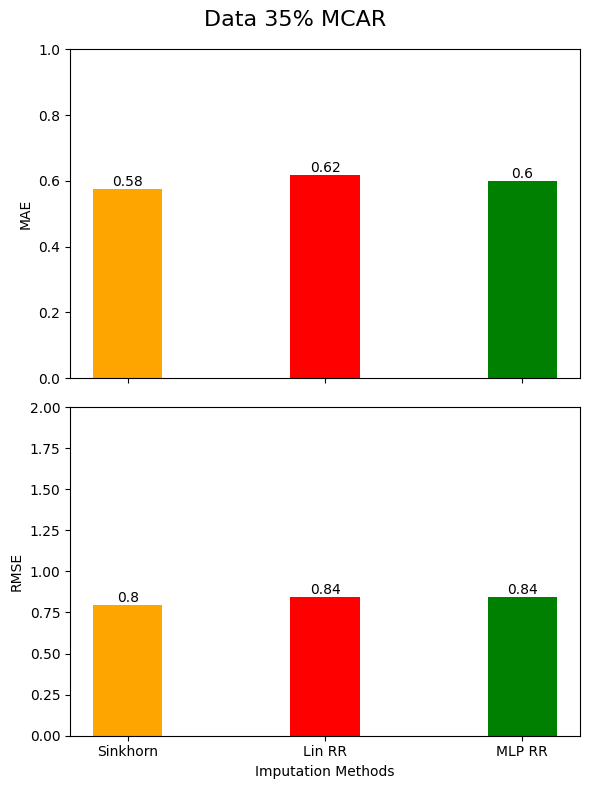

In [202]:

# Define values and categories
valuesOT_mae_mcar35 = [sk_mae_mcar35,lin_rr_mae_mcar35,mlp_rr_mae_mcar35]
valuesOT_rmse_mcar35 = [sk_rmse_mcar35,lin_rr_rmse_mcar35,mlp_rr_rmse_mcar35]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 35% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar35, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar35, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**40% MCAR**

In [203]:
#sinkhorn
n_mcar40, d_mcar40 = data_mcar40.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar40 = pick_epsilon(data_mcar40)

print(epsilon_mcar40)

sk_imputer_mcar40 = SinkhornImputation(eps=epsilon_mcar40, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar40, sk_maes40mcar, sk_rmses40mcar = sk_imputer_mcar40.fit_transform(data_mcar40, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar40_numpy = sk_imp_mcar40.detach().cpu().numpy()

sk_mae_mcar40 = MAE(sk_imp_mcar40_numpy,ground_truth_numpy ,mask_mcar40)
sk_rmse_mcar40 = RMSE(sk_imp_mcar40_numpy, ground_truth_numpy,mask_mcar40)
print(sk_mae_mcar40,sk_rmse_mcar40)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.3405
INFO:root:Iteration 0:	 Loss: 2.1543	 Validation MAE: 0.8454	RMSE: 1.0391


0.3404503318822011


INFO:root:Iteration 500:	 Loss: 1.2268	 Validation MAE: 0.5928	RMSE: 0.8209
INFO:root:Iteration 1000:	 Loss: 1.3983	 Validation MAE: 0.5931	RMSE: 0.8206
INFO:root:Iteration 1500:	 Loss: 1.8330	 Validation MAE: 0.6026	RMSE: 0.8348


0.6033838731336393 0.8328575832459458


In [204]:
#linear Round Robin
dmcar40_ = d_mcar40 - 1
models_liner_mcar40 = {}

for i in range(d_mcar40):
    models_liner_mcar40[i] = nn.Linear(dmcar40_, 1)

#Create the imputer
lin_rr_imputer_mcar40 = RRimputer(models_liner_mcar40, eps=epsilon_mcar40, lr=lr)
lin_rr_mcar40, lin_maesmcar40, lin_rmsesmcar40 = lin_rr_imputer_mcar40.fit_transform(data_mcar40, verbose=True, X_true=ground_truth)
lin_rr_mcar40_numpy = lin_rr_mcar40.detach().cpu().numpy()

lin_rr_mae_mcar40 = MAE(lin_rr_mcar40_numpy,ground_truth_numpy ,mask_mcar40)
lin_rr_rmse_mcar40 = RMSE(lin_rr_mcar40_numpy, ground_truth_numpy,mask_mcar40)
print(lin_rr_mae_mcar40,lin_rr_rmse_mcar40)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.6703	Validation MAE: 0.7351	RMSE:  0.9504
INFO:root:Iteration 1:	 Loss: 1.7763	Validation MAE: 0.6670	RMSE:  0.8919
INFO:root:Iteration 2:	 Loss: 1.7217	Validation MAE: 0.6505	RMSE:  0.8756
INFO:root:Iteration 3:	 Loss: 1.5726	Validation MAE: 0.6471	RMSE:  0.8684
INFO:root:Iteration 4:	 Loss: 1.5890	Validation MAE: 0.6387	RMSE:  0.8632
INFO:root:Iteration 5:	 Loss: 1.5439	Validation MAE: 0.6336	RMSE:  0.8559
INFO:root:Iteration 6:	 Loss: 1.5249	Validation MAE: 0.6320	RMSE:  0.8553
INFO:root:Iteration 7:	 Loss: 1.4791	Validation MAE: 0.6272	RMSE:  0.8519
INFO:root:Iteration 8:	 Loss: 1.6632	Validation MAE: 0.6285	RMSE:  0.8540
INFO:root:Iteration 9:	 Loss: 1.5160	Validation MAE: 0.6321	RMSE:  0.8582
INFO:root:Early stopping criterion not reached


0.6320915259456964 0.8582367447470273


In [205]:
#MLP Round Robin
dmcar40_ = d_mcar40 - 1
models_mlp_mcar40 = {}


for i in range(d_mcar40):
   models_mlp_mcar40[i] = nn.Sequential(nn.Linear(dmcar40_, 2 * dmcar40_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar40_, dmcar40_),
                              nn.ReLU(),
                              nn.Linear(dmcar40_, 1))

#Create the imputer
mlp_rr_imputer_mcar40 = RRimputer(models_mlp_mcar40, eps=epsilon_mcar40, lr=lr)

mlp_rr_mcar40, mlp_rr_maesmcar40, mlp_rr_rmsesmcar40 = mlp_rr_imputer_mcar40.fit_transform(data_mcar40, verbose=True, X_true=ground_truth)

mlp_rr_mcar40_numpy = mlp_rr_mcar40.detach().cpu().numpy()

mlp_rr_mae_mcar40 = MAE(mlp_rr_mcar40_numpy,ground_truth_numpy ,mask_mcar40)
mlp_rr_rmse_mcar40 = RMSE(mlp_rr_mcar40_numpy, ground_truth_numpy,mask_mcar40)
print(mlp_rr_mae_mcar40, mlp_rr_rmse_mcar40)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.6257	Validation MAE: 0.6379	RMSE:  0.8549
INFO:root:Iteration 1:	 Loss: 1.6798	Validation MAE: 0.6137	RMSE:  0.8412
INFO:root:Iteration 2:	 Loss: 1.6842	Validation MAE: 0.6072	RMSE:  0.8397
INFO:root:Iteration 3:	 Loss: 1.4760	Validation MAE: 0.6009	RMSE:  0.8294
INFO:root:Iteration 4:	 Loss: 1.7169	Validation MAE: 0.6034	RMSE:  0.8315
INFO:root:Iteration 5:	 Loss: 1.5587	Validation MAE: 0.6054	RMSE:  0.8372
INFO:root:Iteration 6:	 Loss: 1.5235	Validation MAE: 0.6018	RMSE:  0.8403
INFO:root:Iteration 7:	 Loss: 1.4885	Validation MAE: 0.6075	RMSE:  0.8487
INFO:root:Iteration 8:	 Loss: 1.3791	Validation MAE: 0.6152	RMSE:  0.8593
INFO:root:Iteration 9:	 Loss: 1.6058	Validation MAE: 0.6203	RMSE:  0.8667
INFO:root:Early stopping criterion not reached


0.6203047456137032 0.8667333245682919


In [206]:
#mean
#using numpy version of data
mean_imp_mcar40 = SimpleImputer().fit_transform(data_mcar40_numpy)
mean_mae_mcar40 = MAE(mean_imp_mcar40, ground_truth_numpy, mask_mcar40)
mean_rmse_mcar40= RMSE(mean_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(mean_mae_mcar40, mean_rmse_mcar40)

#ICE
ice_imp_mcar40 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar40_numpy)
ice_mae_mcar40 = MAE(ice_imp_mcar40, ground_truth_numpy, mask_mcar40)
ice_rmse_mcar40 = RMSE(ice_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(ice_mae_mcar40,ice_rmse_mcar40)

#SoftImpute
cv_error_mcar40, grid_lambda_mcar40 = cv_softimpute(data_mcar40_numpy, grid_len=15)
lbda_mcar40 = grid_lambda_mcar40[np.argmin(cv_error_mcar40)]
soft_imp_mcar40 = softimpute((data_mcar40_numpy), lbda_mcar40)[1]

soft_mae_mcar40 = MAE(soft_imp_mcar40, ground_truth_numpy, mask_mcar40)
soft_rmse_mcar40 = RMSE(soft_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(soft_mae_mcar40,soft_rmse_mcar40)

0.8395472564955967 1.0324029208694951
0.6825227361630083 0.9064261482586231
0.638350907161685 0.8387585940749349


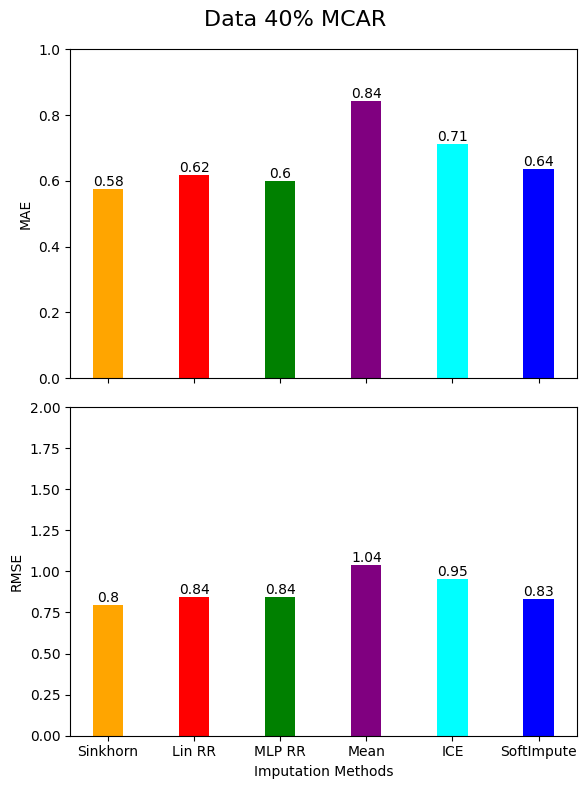

In [207]:

# Define values and categories
values_mae_mcar40 = [sk_mae_mcar40,lin_rr_mae_mcar40,mlp_rr_mae_mcar40, mean_mae_mcar40, ice_mae_mcar40, soft_mae_mcar40]
values_rmse_mcar40 = [sk_rmse_mcar40, lin_rr_rmse_mcar40, mlp_rr_rmse_mcar40, mean_rmse_mcar40, ice_rmse_mcar40, soft_rmse_mcar40]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 40% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar35, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar35, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


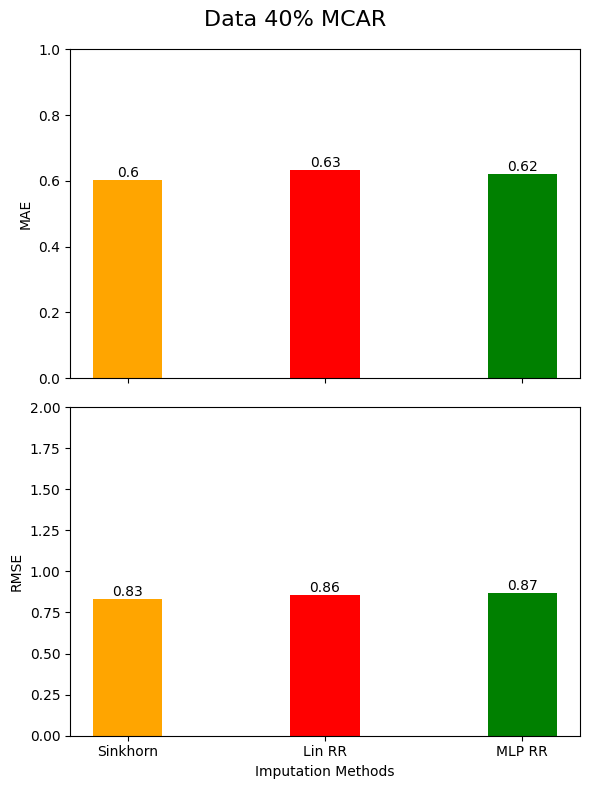

In [208]:

# Define values and categories
valuesOT_mae_mcar40 = [sk_mae_mcar40,lin_rr_mae_mcar40,mlp_rr_mae_mcar40]
valuesOT_rmse_mcar40 = [sk_rmse_mcar40,lin_rr_rmse_mcar40,mlp_rr_rmse_mcar40]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 40% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar40, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar40, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**45% MCAR**

In [209]:
#sinkhorn
n_mcar45, d_mcar45 = data_mcar45.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar45 = pick_epsilon(data_mcar45)

print(epsilon_mcar45)

sk_imputer_mcar45 = SinkhornImputation(eps=epsilon_mcar45, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar45, sk_maes45mcar, sk_rmses45mcar = sk_imputer_mcar45.fit_transform(data_mcar45, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar45_numpy = sk_imp_mcar45.detach().cpu().numpy()

sk_mae_mcar45 = MAE(sk_imp_mcar45_numpy,ground_truth_numpy ,mask_mcar45)
sk_rmse_mcar45 = RMSE(sk_imp_mcar45_numpy, ground_truth_numpy,mask_mcar45)
print(sk_mae_mcar45,sk_rmse_mcar45)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.3053
INFO:root:Iteration 0:	 Loss: 1.7423	 Validation MAE: 0.8559	RMSE: 1.0461


0.30531311342976486


INFO:root:Iteration 500:	 Loss: 1.4751	 Validation MAE: 0.6284	RMSE: 0.8616
INFO:root:Iteration 1000:	 Loss: 1.2297	 Validation MAE: 0.6255	RMSE: 0.8608
INFO:root:Iteration 1500:	 Loss: 1.1424	 Validation MAE: 0.6297	RMSE: 0.8672


0.626277330555017 0.8693239856088435


In [210]:
#linear Round Robin
dmcar45_ = d_mcar45 - 1
models_liner_mcar45 = {}

for i in range(d_mcar45):
    models_liner_mcar45[i] = nn.Linear(dmcar45_, 1)

#Create the imputer
lin_rr_imputer_mcar45 = RRimputer(models_liner_mcar45, eps=epsilon_mcar45, lr=lr)
lin_rr_mcar45, lin_maesmcar45, lin_rmsesmcar45 = lin_rr_imputer_mcar45.fit_transform(data_mcar45, verbose=True, X_true=ground_truth)
lin_rr_mcar45_numpy = lin_rr_mcar45.detach().cpu().numpy()

lin_rr_mae_mcar45 = MAE(lin_rr_mcar45_numpy,ground_truth_numpy ,mask_mcar45)
lin_rr_rmse_mcar45 = RMSE(lin_rr_mcar45_numpy, ground_truth_numpy,mask_mcar45)
print(lin_rr_mae_mcar45,lin_rr_rmse_mcar45)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.8638	Validation MAE: 0.7254	RMSE:  0.9420
INFO:root:Iteration 1:	 Loss: 1.4820	Validation MAE: 0.6716	RMSE:  0.8978
INFO:root:Iteration 2:	 Loss: 1.5704	Validation MAE: 0.6610	RMSE:  0.8928
INFO:root:Iteration 3:	 Loss: 1.8495	Validation MAE: 0.6484	RMSE:  0.8783
INFO:root:Iteration 4:	 Loss: 1.5550	Validation MAE: 0.6452	RMSE:  0.8747
INFO:root:Iteration 5:	 Loss: 1.4249	Validation MAE: 0.6426	RMSE:  0.8725
INFO:root:Iteration 6:	 Loss: 1.3732	Validation MAE: 0.6424	RMSE:  0.8723
INFO:root:Iteration 7:	 Loss: 1.5746	Validation MAE: 0.6441	RMSE:  0.8762
INFO:root:Iteration 8:	 Loss: 1.3494	Validation MAE: 0.6396	RMSE:  0.8707
INFO:root:Iteration 9:	 Loss: 1.4357	Validation MAE: 0.6425	RMSE:  0.8759
INFO:root:Early stopping criterion not reached


0.6425485026685352 0.8758617427928658


In [211]:
#MLP Round Robin
dmcar45_ = d_mcar45 - 1
models_mlp_mcar45 = {}


for i in range(d_mcar45):
   models_mlp_mcar45[i] = nn.Sequential(nn.Linear(dmcar45_, 2 * dmcar45_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar45_, dmcar45_),
                              nn.ReLU(),
                              nn.Linear(dmcar45_, 1))

#Create the imputer
mlp_rr_imputer_mcar45 = RRimputer(models_mlp_mcar45, eps=epsilon_mcar45, lr=lr)

mlp_rr_mcar45, mlp_rr_maesmcar45, mlp_rr_rmsesmcar45 = mlp_rr_imputer_mcar45.fit_transform(data_mcar45, verbose=True, X_true=ground_truth)

mlp_rr_mcar45_numpy = mlp_rr_mcar45.detach().cpu().numpy()

mlp_rr_mae_mcar45 = MAE(mlp_rr_mcar45_numpy,ground_truth_numpy ,mask_mcar45)
mlp_rr_rmse_mcar45 = RMSE(mlp_rr_mcar45_numpy, ground_truth_numpy,mask_mcar45)
print(mlp_rr_mae_mcar45, mlp_rr_rmse_mcar45)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.4531	Validation MAE: 0.6657	RMSE:  0.8960
INFO:root:Iteration 1:	 Loss: 1.3480	Validation MAE: 0.6352	RMSE:  0.8552
INFO:root:Iteration 2:	 Loss: 1.2803	Validation MAE: 0.6274	RMSE:  0.8594
INFO:root:Iteration 3:	 Loss: 1.3808	Validation MAE: 0.6293	RMSE:  0.8715
INFO:root:Iteration 4:	 Loss: 1.2842	Validation MAE: 0.6335	RMSE:  0.8727
INFO:root:Iteration 5:	 Loss: 1.3248	Validation MAE: 0.6305	RMSE:  0.8750
INFO:root:Iteration 6:	 Loss: 1.4294	Validation MAE: 0.6333	RMSE:  0.8848
INFO:root:Iteration 7:	 Loss: 1.3257	Validation MAE: 0.6370	RMSE:  0.8885
INFO:root:Iteration 8:	 Loss: 1.3974	Validation MAE: 0.6345	RMSE:  0.8822
INFO:root:Iteration 9:	 Loss: 1.6278	Validation MAE: 0.6358	RMSE:  0.8838
INFO:root:Early stopping criterion not reached


0.635793876909329 0.8837898521002309


In [212]:
#mean
#using numpy version of data
mean_imp_mcar45 = SimpleImputer().fit_transform(data_mcar45_numpy)
mean_mae_mcar45 = MAE(mean_imp_mcar45, ground_truth_numpy, mask_mcar45)
mean_rmse_mcar45= RMSE(mean_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(mean_mae_mcar45, mean_rmse_mcar45)

#ICE
ice_imp_mcar45 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar45_numpy)
ice_mae_mcar45 = MAE(ice_imp_mcar45, ground_truth_numpy, mask_mcar45)
ice_rmse_mcar45 = RMSE(ice_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(ice_mae_mcar45,ice_rmse_mcar45)

#SoftImpute
cv_error_mcar45, grid_lambda_mcar45 = cv_softimpute(data_mcar45_numpy, grid_len=15)
lbda_mcar45 = grid_lambda_mcar45[np.argmin(cv_error_mcar45)]
soft_imp_mcar45 = softimpute((data_mcar45_numpy), lbda_mcar45)[1]

soft_mae_mcar45 = MAE(soft_imp_mcar45, ground_truth_numpy, mask_mcar45)
soft_rmse_mcar45 = RMSE(soft_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(soft_mae_mcar45,soft_rmse_mcar45)

0.8518129262321886 1.043633882738897
0.6981708373069222 0.9102727448946625
0.653255964126088 0.8564712570588483


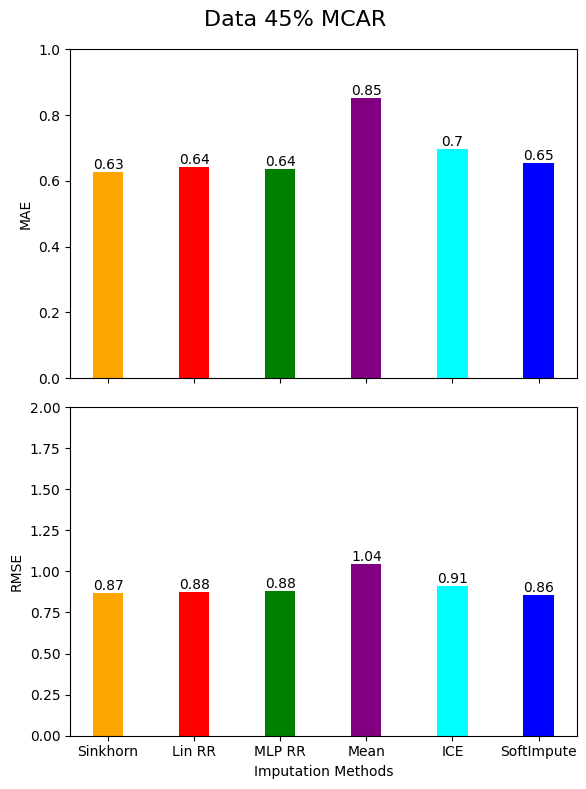

In [213]:

# Define values and categories
values_mae_mcar45 = [sk_mae_mcar45,lin_rr_mae_mcar45,mlp_rr_mae_mcar45, mean_mae_mcar45, ice_mae_mcar45, soft_mae_mcar45]
values_rmse_mcar45 = [sk_rmse_mcar45, lin_rr_rmse_mcar45, mlp_rr_rmse_mcar45, mean_rmse_mcar45, ice_rmse_mcar45, soft_rmse_mcar45]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 45% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar45, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar45, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


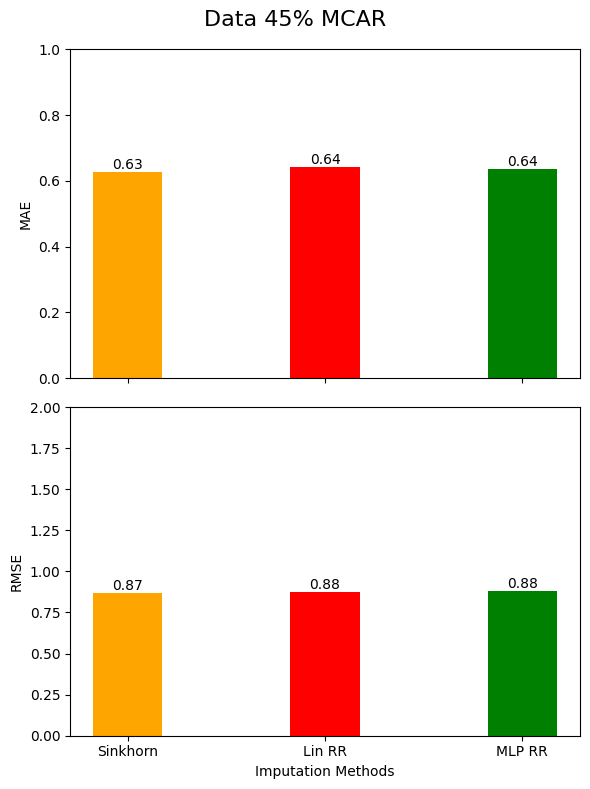

In [214]:

# Define values and categories
valuesOT_mae_mcar45 = [sk_mae_mcar45,lin_rr_mae_mcar45,mlp_rr_mae_mcar45]
valuesOT_rmse_mcar45 = [sk_rmse_mcar45,lin_rr_rmse_mcar45,mlp_rr_rmse_mcar45]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 45% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar45, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar45, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**50% MCAR**

In [215]:
#sinkhorn
n_mcar50, d_mcar50 = data_mcar50.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar50 = pick_epsilon(data_mcar50)

print(epsilon_mcar50)

sk_imputer_mcar50 = SinkhornImputation(eps=epsilon_mcar50, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar50, sk_maes50mcar, sk_rmses50mcar = sk_imputer_mcar50.fit_transform(data_mcar50, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar50_numpy = sk_imp_mcar50.detach().cpu().numpy()

sk_mae_mcar50 = MAE(sk_imp_mcar50_numpy,ground_truth_numpy ,mask_mcar50)
sk_rmse_mcar50 = RMSE(sk_imp_mcar50_numpy, ground_truth_numpy,mask_mcar50)
print(sk_mae_mcar50,sk_rmse_mcar50)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.2697
INFO:root:Iteration 0:	 Loss: 1.6171	 Validation MAE: 0.8604	RMSE: 1.0536


0.26968206468630135


INFO:root:Iteration 500:	 Loss: 1.3291	 Validation MAE: 0.6413	RMSE: 0.8743
INFO:root:Iteration 1000:	 Loss: 0.9777	 Validation MAE: 0.6357	RMSE: 0.8766
INFO:root:Iteration 1500:	 Loss: 1.0180	 Validation MAE: 0.6449	RMSE: 0.8897


0.6494309431599918 0.8923193202535389


In [216]:
#linear Round Robin
dmcar50_ = d_mcar50 - 1
models_liner_mcar50 = {}

for i in range(d_mcar50):
    models_liner_mcar50[i] = nn.Linear(dmcar50_, 1)

#Create the imputer
lin_rr_imputer_mcar50 = RRimputer(models_liner_mcar50, eps=epsilon_mcar50, lr=lr)
lin_rr_mcar50, lin_maesmcar50, lin_rmsesmcar50 = lin_rr_imputer_mcar50.fit_transform(data_mcar50, verbose=True, X_true=ground_truth)
lin_rr_mcar50_numpy = lin_rr_mcar50.detach().cpu().numpy()

lin_rr_mae_mcar50 = MAE(lin_rr_mcar50_numpy,ground_truth_numpy ,mask_mcar50)
lin_rr_rmse_mcar50 = RMSE(lin_rr_mcar50_numpy, ground_truth_numpy,mask_mcar50)
print(lin_rr_mae_mcar50,lin_rr_rmse_mcar50)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.4214	Validation MAE: 0.6918	RMSE:  0.9140
INFO:root:Iteration 1:	 Loss: 1.3513	Validation MAE: 0.6652	RMSE:  0.8903
INFO:root:Iteration 2:	 Loss: 1.7437	Validation MAE: 0.6606	RMSE:  0.8858
INFO:root:Iteration 3:	 Loss: 1.3116	Validation MAE: 0.6539	RMSE:  0.8816
INFO:root:Iteration 4:	 Loss: 1.3424	Validation MAE: 0.6562	RMSE:  0.8859
INFO:root:Iteration 5:	 Loss: 1.5746	Validation MAE: 0.6586	RMSE:  0.8882
INFO:root:Iteration 6:	 Loss: 1.2819	Validation MAE: 0.6633	RMSE:  0.8933
INFO:root:Iteration 7:	 Loss: 1.3512	Validation MAE: 0.6593	RMSE:  0.8873
INFO:root:Iteration 8:	 Loss: 1.2464	Validation MAE: 0.6628	RMSE:  0.8905
INFO:root:Iteration 9:	 Loss: 1.3593	Validation MAE: 0.6639	RMSE:  0.8900
INFO:root:Early stopping criterion not reached


0.663945387337663 0.8899977678440617


In [217]:
#MLP Round Robin
dmcar50_ = d_mcar50 - 1
models_mlp_mcar50 = {}


for i in range(d_mcar50):
   models_mlp_mcar50[i] = nn.Sequential(nn.Linear(dmcar50_, 2 * dmcar50_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar50_, dmcar50_),
                              nn.ReLU(),
                              nn.Linear(dmcar50_, 1))

#Create the imputer
mlp_rr_imputer_mcar50 = RRimputer(models_mlp_mcar50, eps=epsilon_mcar50, lr=lr)

mlp_rr_mcar50, mlp_rr_maesmcar50, mlp_rr_rmsesmcar50 = mlp_rr_imputer_mcar50.fit_transform(data_mcar50, verbose=True, X_true=ground_truth)

mlp_rr_mcar50_numpy = mlp_rr_mcar50.detach().cpu().numpy()

mlp_rr_mae_mcar50 = MAE(mlp_rr_mcar50_numpy,ground_truth_numpy ,mask_mcar50)
mlp_rr_rmse_mcar50 = RMSE(mlp_rr_mcar50_numpy, ground_truth_numpy,mask_mcar50)
print(mlp_rr_mae_mcar50, mlp_rr_rmse_mcar50)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.3048	Validation MAE: 0.6765	RMSE:  0.8997
INFO:root:Iteration 1:	 Loss: 1.3542	Validation MAE: 0.6380	RMSE:  0.8717
INFO:root:Iteration 2:	 Loss: 1.3579	Validation MAE: 0.6541	RMSE:  0.8849
INFO:root:Iteration 3:	 Loss: 1.2912	Validation MAE: 0.6479	RMSE:  0.8903
INFO:root:Iteration 4:	 Loss: 1.2017	Validation MAE: 0.6548	RMSE:  0.8982
INFO:root:Iteration 5:	 Loss: 1.2514	Validation MAE: 0.6636	RMSE:  0.9104
INFO:root:Iteration 6:	 Loss: 1.1809	Validation MAE: 0.6689	RMSE:  0.9132
INFO:root:Iteration 7:	 Loss: 1.3477	Validation MAE: 0.6819	RMSE:  0.9257
INFO:root:Iteration 8:	 Loss: 1.2822	Validation MAE: 0.6841	RMSE:  0.9245
INFO:root:Iteration 9:	 Loss: 1.5973	Validation MAE: 0.6853	RMSE:  0.9240
INFO:root:Early stopping criterion not reached


0.6853205217418414 0.9240334615848252


In [218]:
#mean
#using numpy version of data
mean_imp_mcar50 = SimpleImputer().fit_transform(data_mcar50_numpy)
mean_mae_mcar50 = MAE(mean_imp_mcar50, ground_truth_numpy, mask_mcar50)
mean_rmse_mcar50= RMSE(mean_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(mean_mae_mcar50, mean_rmse_mcar50)

#ICE
ice_imp_mcar50 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar50_numpy)
ice_mae_mcar50 = MAE(ice_imp_mcar50, ground_truth_numpy, mask_mcar50)
ice_rmse_mcar50 = RMSE(ice_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(ice_mae_mcar50,ice_rmse_mcar50)

#SoftImpute
cv_error_mcar50, grid_lambda_mcar50 = cv_softimpute(data_mcar50_numpy, grid_len=15)
lbda_mcar50 = grid_lambda_mcar50[np.argmin(cv_error_mcar50)]
soft_imp_mcar50 = softimpute((data_mcar50_numpy), lbda_mcar50)[1]

soft_mae_mcar50 = MAE(soft_imp_mcar50, ground_truth_numpy, mask_mcar50)
soft_rmse_mcar50 = RMSE(soft_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(soft_mae_mcar50,soft_rmse_mcar50)

0.8576462061308137 1.0508945620340129
0.7182849234578299 0.9322036866830374
0.6678373907742787 0.8678216947653806


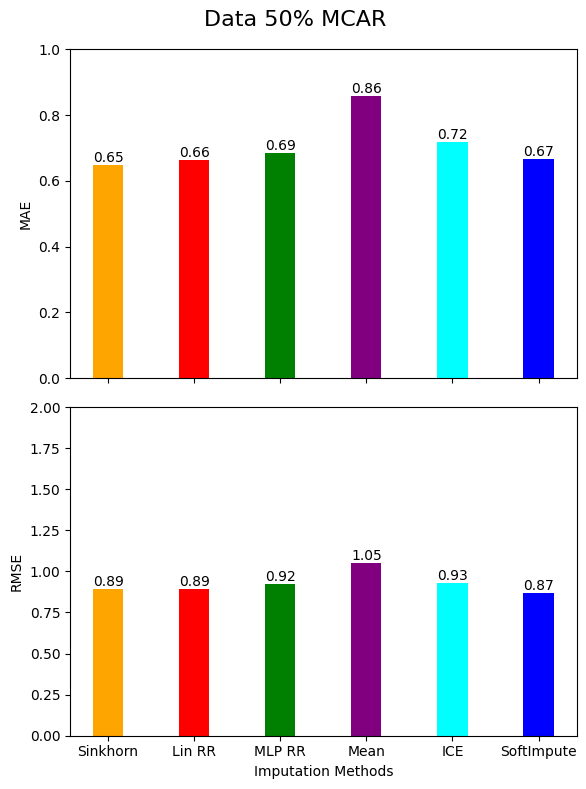

In [219]:

# Define values and categories
values_mae_mcar50 = [sk_mae_mcar50,lin_rr_mae_mcar50,mlp_rr_mae_mcar50, mean_mae_mcar50, ice_mae_mcar50, soft_mae_mcar50]
values_rmse_mcar50 = [sk_rmse_mcar50, lin_rr_rmse_mcar50, mlp_rr_rmse_mcar50, mean_rmse_mcar50, ice_rmse_mcar50, soft_rmse_mcar50]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 50% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar50, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar50, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


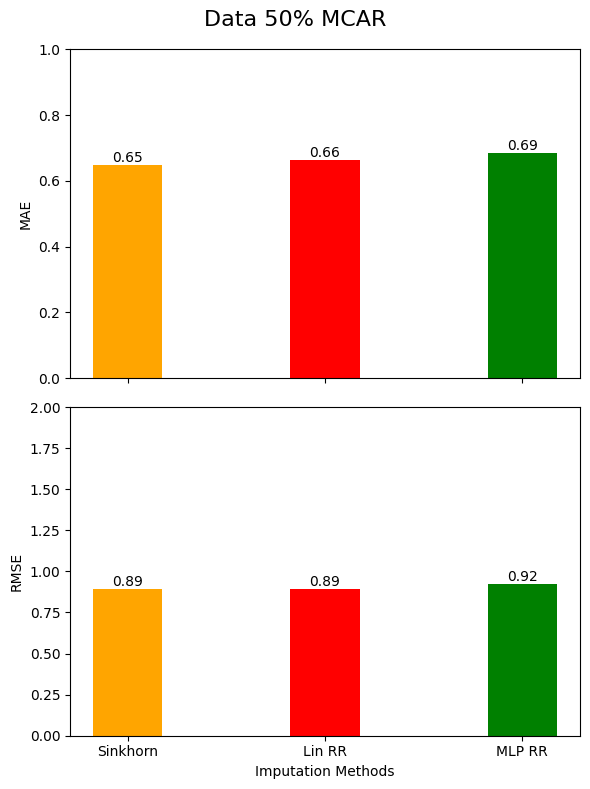

In [220]:

# Define values and categories
valuesOT_mae_mcar50 = [sk_mae_mcar50,lin_rr_mae_mcar50,mlp_rr_mae_mcar50]
valuesOT_rmse_mcar50 = [sk_rmse_mcar50,lin_rr_rmse_mcar50,mlp_rr_rmse_mcar50]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 50% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar50, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar50, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


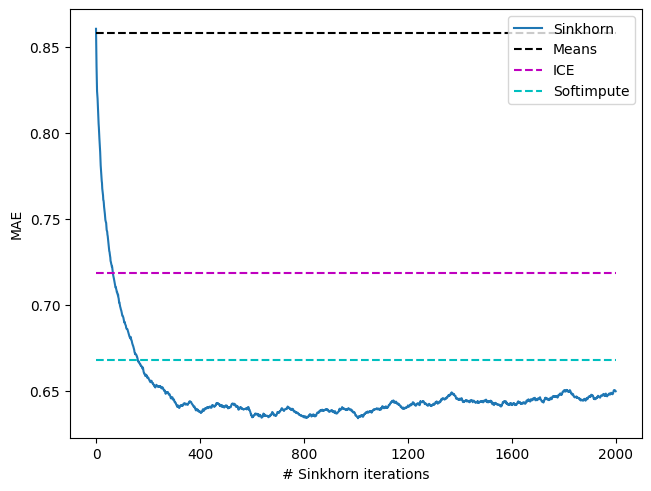

In [221]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes50mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes50mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar50, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar50, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar50, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

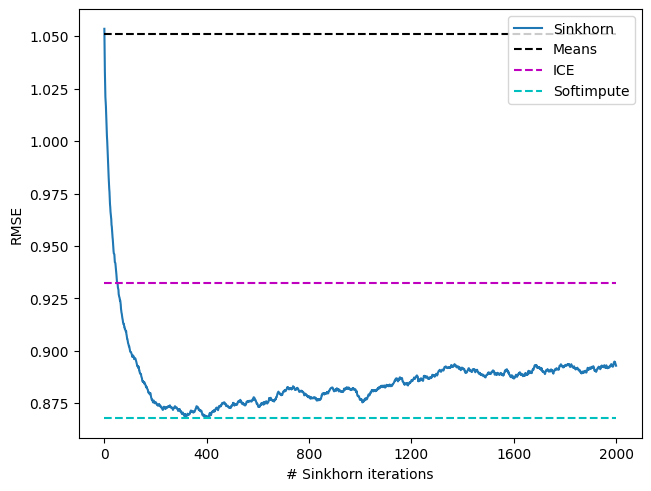

In [222]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses50mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses50mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar50, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar50, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar50, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

60% MCAR

In [223]:
#sinkhorn
n_mcar60, d_mcar60 = data_mcar60.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar60 = pick_epsilon(data_mcar60)

print(epsilon_mcar60)

sk_imputer_mcar60 = SinkhornImputation(eps=epsilon_mcar60, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar60, sk_maes60mcar, sk_rmses60mcar = sk_imputer_mcar60.fit_transform(data_mcar60, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar60_numpy = sk_imp_mcar60.detach().cpu().numpy()

sk_mae_mcar60 = MAE(sk_imp_mcar60_numpy,ground_truth_numpy ,mask_mcar60)
sk_rmse_mcar60 = RMSE(sk_imp_mcar60_numpy, ground_truth_numpy,mask_mcar60)
print(sk_mae_mcar60,sk_rmse_mcar60)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.2113
INFO:root:Iteration 0:	 Loss: 1.3058	 Validation MAE: 0.8615	RMSE: 1.0536


0.21132574129756435


INFO:root:Iteration 500:	 Loss: 0.7993	 Validation MAE: 0.6756	RMSE: 0.8974
INFO:root:Iteration 1000:	 Loss: 0.7300	 Validation MAE: 0.6741	RMSE: 0.9063
INFO:root:Iteration 1500:	 Loss: 0.7269	 Validation MAE: 0.6747	RMSE: 0.9065


0.6773649994421617 0.9067828600790085


In [224]:
#linear Round Robin
dmcar60_ = d_mcar60 - 1
models_liner_mcar60 = {}

for i in range(d_mcar60):
    models_liner_mcar60[i] = nn.Linear(dmcar60_, 1)

#Create the imputer
lin_rr_imputer_mcar60 = RRimputer(models_liner_mcar60, eps=epsilon_mcar60, lr=lr)
lin_rr_mcar60, lin_maesmcar60, lin_rmsesmcar60 = lin_rr_imputer_mcar60.fit_transform(data_mcar60, verbose=True, X_true=ground_truth)
lin_rr_mcar60_numpy = lin_rr_mcar60.detach().cpu().numpy()

lin_rr_mae_mcar60 = MAE(lin_rr_mcar60_numpy,ground_truth_numpy ,mask_mcar60)
lin_rr_rmse_mcar60 = RMSE(lin_rr_mcar60_numpy, ground_truth_numpy,mask_mcar60)
print(lin_rr_mae_mcar60,lin_rr_rmse_mcar60)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.3607	Validation MAE: 0.7288	RMSE:  0.9348
INFO:root:Iteration 1:	 Loss: 1.2433	Validation MAE: 0.6883	RMSE:  0.9051
INFO:root:Iteration 2:	 Loss: 1.1512	Validation MAE: 0.6813	RMSE:  0.9014
INFO:root:Iteration 3:	 Loss: 1.1293	Validation MAE: 0.6765	RMSE:  0.8965
INFO:root:Iteration 4:	 Loss: 1.1375	Validation MAE: 0.6796	RMSE:  0.9039
INFO:root:Iteration 5:	 Loss: 1.1172	Validation MAE: 0.6823	RMSE:  0.9085
INFO:root:Iteration 6:	 Loss: 1.2028	Validation MAE: 0.6814	RMSE:  0.9066
INFO:root:Iteration 7:	 Loss: 1.5218	Validation MAE: 0.6841	RMSE:  0.9108
INFO:root:Iteration 8:	 Loss: 1.2387	Validation MAE: 0.6880	RMSE:  0.9147
INFO:root:Iteration 9:	 Loss: 1.1233	Validation MAE: 0.6868	RMSE:  0.9131
INFO:root:Early stopping criterion not reached


0.6868378684170438 0.913146941474758


In [225]:
#MLP Round Robin
dmcar60_ = d_mcar60 - 1
models_mlp_mcar60 = {}


for i in range(d_mcar60):
   models_mlp_mcar60[i] = nn.Sequential(nn.Linear(dmcar60_, 2 * dmcar60_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar60_, dmcar60_),
                              nn.ReLU(),
                              nn.Linear(dmcar60_, 1))

#Create the imputer
mlp_rr_imputer_mcar60 = RRimputer(models_mlp_mcar60, eps=epsilon_mcar60, lr=lr)

mlp_rr_mcar60, mlp_rr_maesmcar60, mlp_rr_rmsesmcar60 = mlp_rr_imputer_mcar60.fit_transform(data_mcar60, verbose=True, X_true=ground_truth)

mlp_rr_mcar60_numpy = mlp_rr_mcar60.detach().cpu().numpy()

mlp_rr_mae_mcar60 = MAE(mlp_rr_mcar60_numpy,ground_truth_numpy ,mask_mcar60)
mlp_rr_rmse_mcar60 = RMSE(mlp_rr_mcar60_numpy, ground_truth_numpy,mask_mcar60)
print(mlp_rr_mae_mcar60, mlp_rr_rmse_mcar60)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.


INFO:root:Iteration 0:	 Loss: 1.1795	Validation MAE: 0.6958	RMSE:  0.9322
INFO:root:Iteration 1:	 Loss: 1.0529	Validation MAE: 0.6525	RMSE:  0.8862
INFO:root:Iteration 2:	 Loss: 1.0614	Validation MAE: 0.6684	RMSE:  0.9042
INFO:root:Iteration 3:	 Loss: 0.9895	Validation MAE: 0.6711	RMSE:  0.9042
INFO:root:Iteration 4:	 Loss: 1.0345	Validation MAE: 0.6797	RMSE:  0.9144
INFO:root:Iteration 5:	 Loss: 1.0588	Validation MAE: 0.6727	RMSE:  0.9067
INFO:root:Iteration 6:	 Loss: 1.0172	Validation MAE: 0.6822	RMSE:  0.9159
INFO:root:Iteration 7:	 Loss: 1.0804	Validation MAE: 0.6787	RMSE:  0.9173
INFO:root:Iteration 8:	 Loss: 1.0140	Validation MAE: 0.6802	RMSE:  0.9196
INFO:root:Iteration 9:	 Loss: 1.0032	Validation MAE: 0.6830	RMSE:  0.9221
INFO:root:Early stopping criterion not reached


0.6830412541046226 0.9221202846419284


In [226]:
#mean
#using numpy version of data
mean_imp_mcar60 = SimpleImputer().fit_transform(data_mcar60_numpy)
mean_mae_mcar60 = MAE(mean_imp_mcar60, ground_truth_numpy, mask_mcar60)
mean_rmse_mcar60= RMSE(mean_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(mean_mae_mcar60, mean_rmse_mcar60)

#ICE
ice_imp_mcar60 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar60_numpy)
ice_mae_mcar60 = MAE(ice_imp_mcar60, ground_truth_numpy, mask_mcar60)
ice_rmse_mcar60 = RMSE(ice_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(ice_mae_mcar60,ice_rmse_mcar60)

#SoftImpute
cv_error_mcar60, grid_lambda_mcar60 = cv_softimpute(data_mcar60_numpy, grid_len=15)
lbda_mcar60 = grid_lambda_mcar60[np.argmin(cv_error_mcar60)]
soft_imp_mcar60 = softimpute((data_mcar60_numpy), lbda_mcar60)[1]

soft_mae_mcar60 = MAE(soft_imp_mcar60, ground_truth_numpy, mask_mcar60)
soft_rmse_mcar60 = RMSE(soft_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(soft_mae_mcar60,soft_rmse_mcar60)

0.8534856405887116 1.0445645060236497
0.7088288790312616 0.9199657312449192
0.6829769915582787 0.8747976424505858


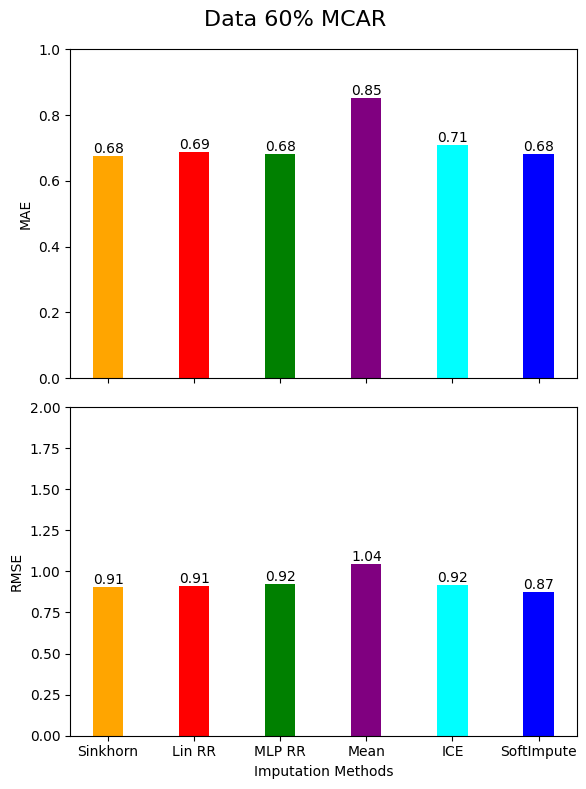

In [227]:

# Define values and categories
values_mae_mcar60 = [sk_mae_mcar60,lin_rr_mae_mcar60,mlp_rr_mae_mcar60, mean_mae_mcar60, ice_mae_mcar60, soft_mae_mcar60]
values_rmse_mcar60 = [sk_rmse_mcar60, lin_rr_rmse_mcar60, mlp_rr_rmse_mcar60, mean_rmse_mcar60, ice_rmse_mcar60, soft_rmse_mcar60]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 60% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar60, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar60, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


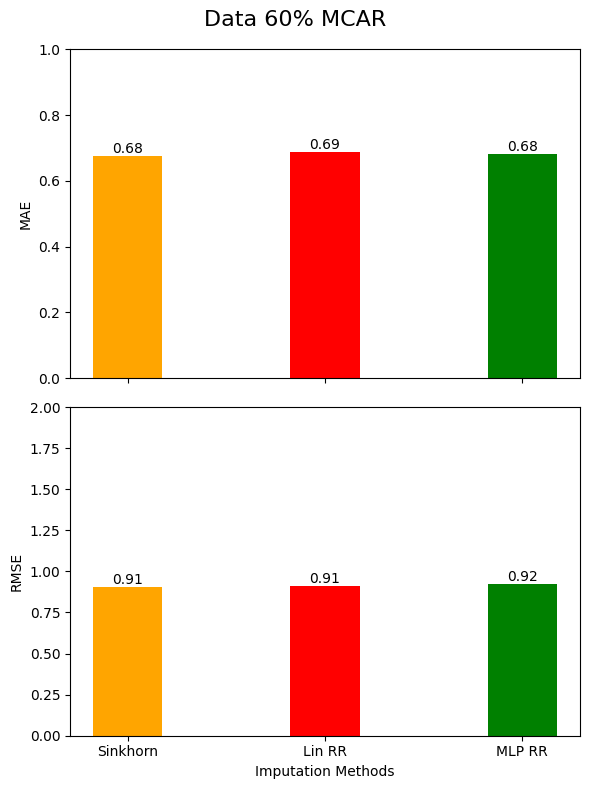

In [228]:

# Define values and categories
valuesOT_mae_mcar60 = [sk_mae_mcar60,lin_rr_mae_mcar60,mlp_rr_mae_mcar60]
valuesOT_rmse_mcar60 = [sk_rmse_mcar60,lin_rr_rmse_mcar60,mlp_rr_rmse_mcar60]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 60% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar60, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar60, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


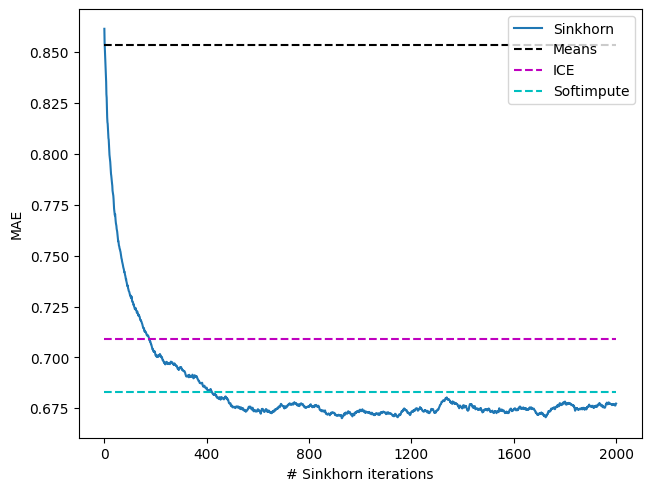

In [229]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes60mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes60mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar60, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar60, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar60, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

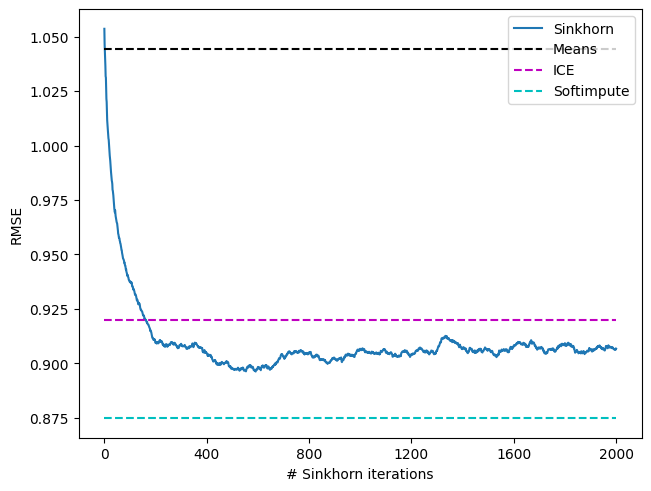

In [230]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses60mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses60mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar60, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar60, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar60, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

70% MCAR

In [231]:
#sinkhorn
n_mcar70, d_mcar70 = data_mcar70.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar70 = pick_epsilon(data_mcar70)

print(epsilon_mcar70)

sk_imputer_mcar70 = SinkhornImputation(eps=epsilon_mcar70, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar70, sk_maes70mcar, sk_rmses70mcar = sk_imputer_mcar70.fit_transform(data_mcar70, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar70_numpy = sk_imp_mcar70.detach().cpu().numpy()

sk_mae_mcar70 = MAE(sk_imp_mcar70_numpy,ground_truth_numpy ,mask_mcar70)
sk_rmse_mcar70 = RMSE(sk_imp_mcar70_numpy, ground_truth_numpy,mask_mcar70)
print(sk_mae_mcar70,sk_rmse_mcar70)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.1537
INFO:root:Iteration 0:	 Loss: 1.0187	 Validation MAE: 0.8414	RMSE: 1.0310


0.15371426516812714


INFO:root:Iteration 500:	 Loss: 0.6693	 Validation MAE: 0.6954	RMSE: 0.9096
INFO:root:Iteration 1000:	 Loss: 0.7798	 Validation MAE: 0.6935	RMSE: 0.9184
INFO:root:Iteration 1500:	 Loss: 0.8228	 Validation MAE: 0.6978	RMSE: 0.9267


0.6970824806072132 0.9276434415184448


In [232]:
#linear Round Robin
dmcar70_ = d_mcar70 - 1
models_liner_mcar70 = {}

for i in range(d_mcar70):
    models_liner_mcar70[i] = nn.Linear(dmcar70_, 1)

#Create the imputer
lin_rr_imputer_mcar70 = RRimputer(models_liner_mcar70, eps=epsilon_mcar70, lr=lr)
lin_rr_mcar70, lin_maesmcar70, lin_rmsesmcar70 = lin_rr_imputer_mcar70.fit_transform(data_mcar70, verbose=True, X_true=ground_truth)
lin_rr_mcar70_numpy = lin_rr_mcar70.detach().cpu().numpy()

lin_rr_mae_mcar70 = MAE(lin_rr_mcar70_numpy,ground_truth_numpy,mask_mcar70)
lin_rr_rmse_mcar70 = RMSE(lin_rr_mcar70_numpy, ground_truth_numpy,mask_mcar70)
print(lin_rr_mae_mcar70,lin_rr_rmse_mcar70)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.5160	Validation MAE: 0.7802	RMSE:  0.9842
INFO:root:Iteration 1:	 Loss: 1.5027	Validation MAE: 0.7402	RMSE:  0.9554
INFO:root:Iteration 2:	 Loss: 1.5484	Validation MAE: 0.7331	RMSE:  0.9578
INFO:root:Iteration 3:	 Loss: 1.5973	Validation MAE: 0.7317	RMSE:  0.9587
INFO:root:Iteration 4:	 Loss: 1.4310	Validation MAE: 0.7323	RMSE:  0.9566
INFO:root:Iteration 5:	 Loss: 1.4705	Validation MAE: 0.7318	RMSE:  0.9611
INFO:root:Iteration 6:	 Loss: 1.3740	Validation MAE: 0.7324	RMSE:  0.9617
INFO:root:Iteration 7:	 Loss: 1.3941	Validation MAE: 0.7332	RMSE:  0.9629
INFO:root:Iteration 8:	 Loss: 1.6237	Validation MAE: 0.7343	RMSE:  0.9649
INFO:root:Iteration 9:	 Loss: 1.3759	Validation MAE: 0.7346	RMSE:  0.9679
INFO:root:Early stopping criterion not reached


0.7345591634969478 0.9678650738639557


In [233]:
#MLP Round Robin
dmcar70_ = d_mcar70 - 1
models_mlp_mcar70 = {}


for i in range(d_mcar70):
   models_mlp_mcar70[i] = nn.Sequential(nn.Linear(dmcar70_, 2 * dmcar70_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar70_, dmcar70_),
                              nn.ReLU(),
                              nn.Linear(dmcar70_, 1))

#Create the imputer
mlp_rr_imputer_mcar70 = RRimputer(models_mlp_mcar70, eps=epsilon_mcar70, lr=lr)

mlp_rr_mcar70, mlp_rr_maesmcar70, mlp_rr_rmsesmcar70 = mlp_rr_imputer_mcar70.fit_transform(data_mcar70, verbose=True, X_true=ground_truth)

mlp_rr_mcar70_numpy = mlp_rr_mcar70.detach().cpu().numpy()

mlp_rr_mae_mcar70 = MAE(mlp_rr_mcar70_numpy,ground_truth_numpy ,mask_mcar70)
mlp_rr_rmse_mcar70 = RMSE(mlp_rr_mcar70_numpy, ground_truth_numpy,mask_mcar70)
print(mlp_rr_mae_mcar70, mlp_rr_rmse_mcar70)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.3766	Validation MAE: 0.7153	RMSE:  0.9377
INFO:root:Iteration 1:	 Loss: 1.5341	Validation MAE: 0.7249	RMSE:  0.9615
INFO:root:Iteration 2:	 Loss: 1.4868	Validation MAE: 0.7325	RMSE:  0.9850
INFO:root:Iteration 3:	 Loss: 1.1762	Validation MAE: 0.7499	RMSE:  1.0068
INFO:root:Iteration 4:	 Loss: 1.5693	Validation MAE: 0.7466	RMSE:  1.0004
INFO:root:Iteration 5:	 Loss: 1.3652	Validation MAE: 0.7553	RMSE:  1.0133
INFO:root:Iteration 6:	 Loss: 1.5985	Validation MAE: 0.7553	RMSE:  1.0171
INFO:root:Iteration 7:	 Loss: 1.3659	Validation MAE: 0.7558	RMSE:  1.0175
INFO:root:Iteration 8:	 Loss: 1.2591	Validation MAE: 0.7603	RMSE:  1.0240
INFO:root:Iteration 9:	 Loss: 1.5265	Validation MAE: 0.7644	RMSE:  1.0307
INFO:root:Early stopping criterion not reached


0.7644166335781448 1.030653755165246


In [234]:
#mean
#using numpy version of data
mean_imp_mcar70 = SimpleImputer().fit_transform(data_mcar70_numpy)
mean_mae_mcar70 = MAE(mean_imp_mcar70, ground_truth_numpy, mask_mcar70)
mean_rmse_mcar70= RMSE(mean_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(mean_mae_mcar70, mean_rmse_mcar70)

#ICE
ice_imp_mcar70 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar70_numpy)
ice_mae_mcar70 = MAE(ice_imp_mcar70, ground_truth_numpy, mask_mcar70)
ice_rmse_mcar70 = RMSE(ice_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(ice_mae_mcar70,ice_rmse_mcar70)

#SoftImpute
cv_error_mcar70, grid_lambda_mcar70 = cv_softimpute(data_mcar70_numpy, grid_len=15)
lbda_mcar70 = grid_lambda_mcar70[np.argmin(cv_error_mcar70)]
soft_imp_mcar70 = softimpute((data_mcar70_numpy), lbda_mcar70)[1]

soft_mae_mcar70 = MAE(soft_imp_mcar70, ground_truth_numpy, mask_mcar70)
soft_rmse_mcar70 = RMSE(soft_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(soft_mae_mcar70,soft_rmse_mcar70)

0.8392276189208744 1.0284877768064147
0.7807363315063238 0.981172710235072
0.7079462783757755 0.9005364039527662


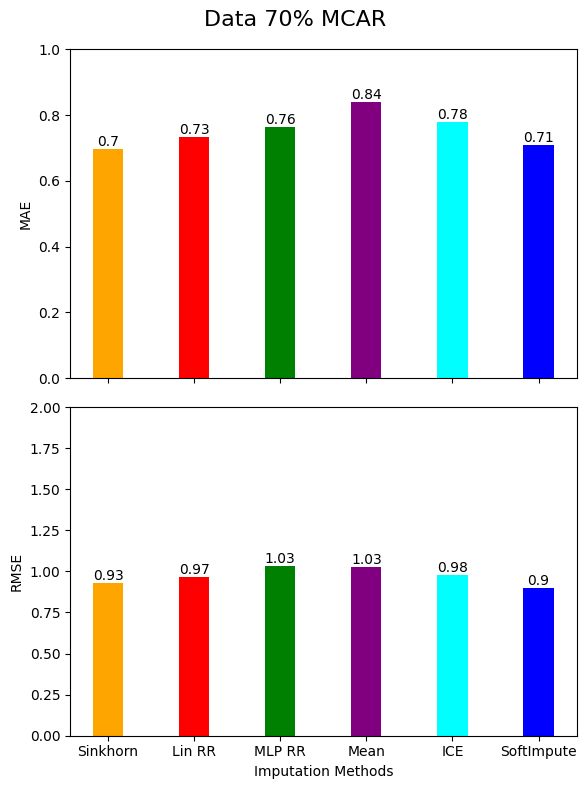

In [235]:

# Define values and categories
values_mae_mcar70 = [sk_mae_mcar70,lin_rr_mae_mcar70,mlp_rr_mae_mcar70, mean_mae_mcar70, ice_mae_mcar70, soft_mae_mcar70]
values_rmse_mcar70 = [sk_rmse_mcar70, lin_rr_rmse_mcar70, mlp_rr_rmse_mcar70, mean_rmse_mcar70, ice_rmse_mcar70, soft_rmse_mcar70]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 70% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar70, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar70, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


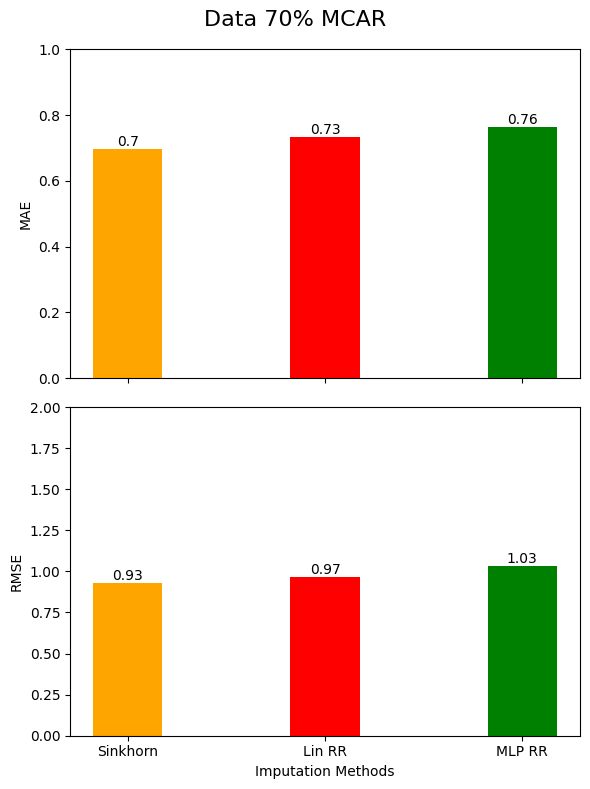

In [236]:

# Define values and categories
valuesOT_mae_mcar70 = [sk_mae_mcar70,lin_rr_mae_mcar70,mlp_rr_mae_mcar70]
valuesOT_rmse_mcar70 = [sk_rmse_mcar70,lin_rr_rmse_mcar70,mlp_rr_rmse_mcar70]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 70% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar70, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar70, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


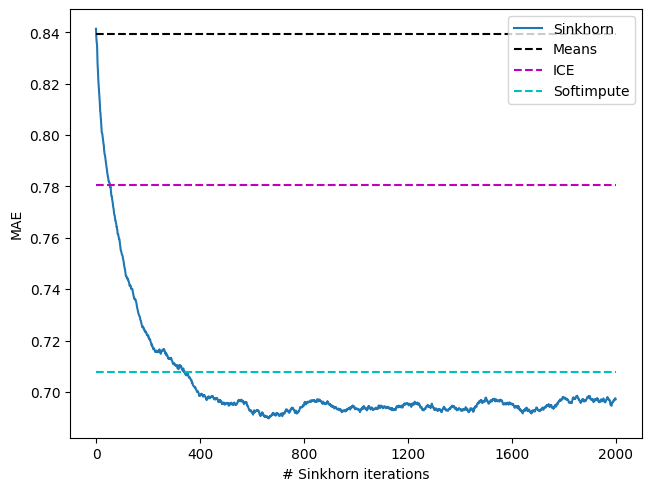

In [237]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes70mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes70mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar70, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar70, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar70, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

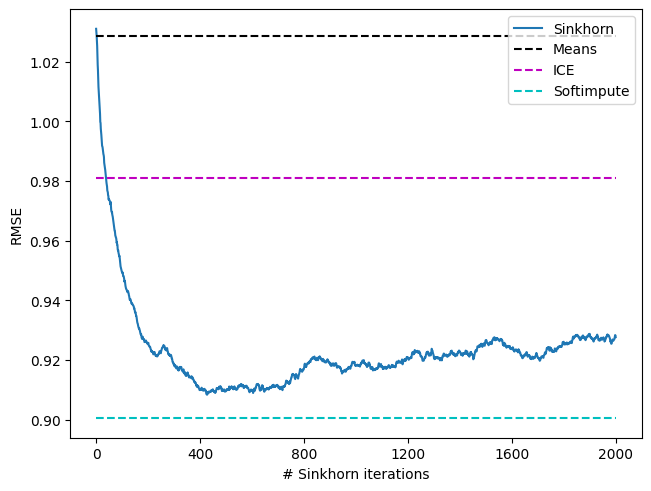

In [238]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses70mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses70mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar70, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar70, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar70, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

80% MCAR

In [239]:
#sinkhorn
n_mcar80, d_mcar80 = data_mcar80.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar80 = pick_epsilon(data_mcar80)

print(epsilon_mcar80)

sk_imputer_mcar80 = SinkhornImputation(eps=epsilon_mcar80, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar80, sk_maes80mcar, sk_rmses80mcar = sk_imputer_mcar80.fit_transform(data_mcar80, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar80_numpy = sk_imp_mcar80.detach().cpu().numpy()

sk_mae_mcar80 = MAE(sk_imp_mcar80_numpy,ground_truth_numpy ,mask_mcar80)
sk_rmse_mcar80 = RMSE(sk_imp_mcar80_numpy, ground_truth_numpy,mask_mcar80)
print(sk_mae_mcar80,sk_rmse_mcar80)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.1007
INFO:root:Iteration 0:	 Loss: 0.9114	 Validation MAE: 0.8330	RMSE: 1.0288


0.10068418342965356


INFO:root:Iteration 500:	 Loss: 0.4882	 Validation MAE: 0.7455	RMSE: 0.9630
INFO:root:Iteration 1000:	 Loss: 0.3062	 Validation MAE: 0.7412	RMSE: 0.9652
INFO:root:Iteration 1500:	 Loss: 0.5324	 Validation MAE: 0.7396	RMSE: 0.9707


0.7469857410484739 0.9791070240955603


In [240]:
#linear Round Robin
dmcar80_ = d_mcar80 - 1
models_liner_mcar80 = {}

for i in range(d_mcar80):
    models_liner_mcar80[i] = nn.Linear(dmcar80_, 1)

#Create the imputer
lin_rr_imputer_mcar80 = RRimputer(models_liner_mcar80, eps=epsilon_mcar80, lr=lr)
lin_rr_mcar80, lin_maesmcar80, lin_rmsesmcar80 = lin_rr_imputer_mcar80.fit_transform(data_mcar80, verbose=True, X_true=ground_truth)
lin_rr_mcar80_numpy = lin_rr_mcar80.detach().cpu().numpy()

lin_rr_mae_mcar80 = MAE(lin_rr_mcar80_numpy,ground_truth_numpy,mask_mcar80)
lin_rr_rmse_mcar80 = RMSE(lin_rr_mcar80_numpy, ground_truth_numpy,mask_mcar80)
print(lin_rr_mae_mcar80,lin_rr_rmse_mcar80)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.5096	Validation MAE: 0.8064	RMSE:  1.0225
INFO:root:Iteration 1:	 Loss: 1.3392	Validation MAE: 0.8030	RMSE:  1.0352
INFO:root:Iteration 2:	 Loss: 1.7307	Validation MAE: 0.7809	RMSE:  1.0152
INFO:root:Iteration 3:	 Loss: 1.4585	Validation MAE: 0.7902	RMSE:  1.0275
INFO:root:Iteration 4:	 Loss: 1.4855	Validation MAE: 0.7830	RMSE:  1.0172
INFO:root:Iteration 5:	 Loss: 1.4007	Validation MAE: 0.7896	RMSE:  1.0222
INFO:root:Iteration 6:	 Loss: 1.4587	Validation MAE: 0.7909	RMSE:  1.0248
INFO:root:Iteration 7:	 Loss: 1.3670	Validation MAE: 0.7931	RMSE:  1.0277
INFO:root:Iteration 8:	 Loss: 1.5513	Validation MAE: 0.7848	RMSE:  1.0199
INFO:root:Iteration 9:	 Loss: 1.3245	Validation MAE: 0.7907	RMSE:  1.0277
INFO:root:Early stopping criterion not reached


0.7906833453966335 1.0276868251040963


In [241]:
#MLP Round Robin
dmcar80_ = d_mcar80 - 1
models_mlp_mcar80 = {}


for i in range(d_mcar80):
   models_mlp_mcar80[i] = nn.Sequential(nn.Linear(dmcar80_, 2 * dmcar80_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar80_, dmcar80_),
                              nn.ReLU(),
                              nn.Linear(dmcar80_, 1))

#Create the imputer
mlp_rr_imputer_mcar80 = RRimputer(models_mlp_mcar80, eps=epsilon_mcar80, lr=lr)

mlp_rr_mcar80, mlp_rr_maesmcar80, mlp_rr_rmsesmcar80 = mlp_rr_imputer_mcar80.fit_transform(data_mcar80, verbose=True, X_true=ground_truth)

mlp_rr_mcar80_numpy = mlp_rr_mcar80.detach().cpu().numpy()

mlp_rr_mae_mcar80 = MAE(mlp_rr_mcar80_numpy,ground_truth_numpy,mask_mcar80)
mlp_rr_rmse_mcar80 = RMSE(mlp_rr_mcar80_numpy, ground_truth_numpy,mask_mcar80)
print(mlp_rr_mae_mcar80, mlp_rr_rmse_mcar80)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.5018	Validation MAE: 0.8088	RMSE:  1.0482
INFO:root:Iteration 1:	 Loss: 1.3018	Validation MAE: 0.8009	RMSE:  1.0344
INFO:root:Iteration 2:	 Loss: 1.5827	Validation MAE: 0.7999	RMSE:  1.0469
INFO:root:Iteration 3:	 Loss: 1.4049	Validation MAE: 0.8176	RMSE:  1.0710
INFO:root:Iteration 4:	 Loss: 1.3925	Validation MAE: 0.8171	RMSE:  1.0733
INFO:root:Iteration 5:	 Loss: 1.3045	Validation MAE: 0.8280	RMSE:  1.0892
INFO:root:Iteration 6:	 Loss: 1.4123	Validation MAE: 0.8333	RMSE:  1.0951
INFO:root:Iteration 7:	 Loss: 1.2804	Validation MAE: 0.8412	RMSE:  1.1047
INFO:root:Iteration 8:	 Loss: 1.4190	Validation MAE: 0.8470	RMSE:  1.1094
INFO:root:Iteration 9:	 Loss: 1.2146	Validation MAE: 0.8390	RMSE:  1.1004
INFO:root:Early stopping criterion not reached


0.8390080298367177 1.1004047958807892


In [242]:
#mean
#using numpy version of data
mean_imp_mcar80 = SimpleImputer().fit_transform(data_mcar80_numpy)
mean_mae_mcar80 = MAE(mean_imp_mcar80, ground_truth_numpy, mask_mcar80)
mean_rmse_mcar80= RMSE(mean_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(mean_mae_mcar80, mean_rmse_mcar80)

#ICE
ice_imp_mcar80 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar80_numpy)
ice_mae_mcar80 = MAE(ice_imp_mcar80, ground_truth_numpy, mask_mcar80)
ice_rmse_mcar80 = RMSE(ice_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(ice_mae_mcar80,ice_rmse_mcar80)

#SoftImpute
cv_error_mcar80, grid_lambda_mcar80 = cv_softimpute(data_mcar80_numpy, grid_len=15)
lbda_mcar80 = grid_lambda_mcar80[np.argmin(cv_error_mcar80)]
soft_imp_mcar80 = softimpute((data_mcar80_numpy), lbda_mcar80)[1]

soft_mae_mcar80 = MAE(soft_imp_mcar80, ground_truth_numpy, mask_mcar80)
soft_rmse_mcar80 = RMSE(soft_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(soft_mae_mcar80,soft_rmse_mcar80)

0.8288578177363132 1.0246886386415008
0.845758457505015 1.0655170121659088
0.7467511584734243 0.9343919300257614


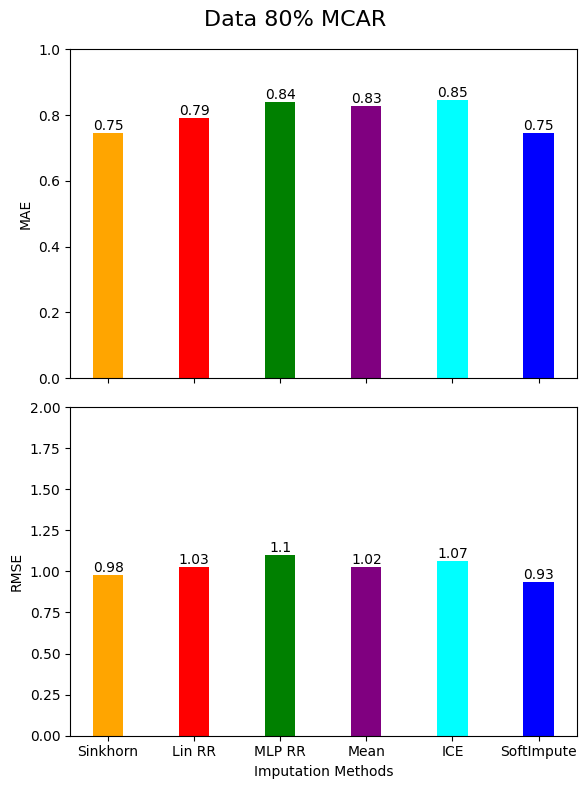

In [243]:

# Define values and categories
values_mae_mcar80 = [sk_mae_mcar80,lin_rr_mae_mcar80,mlp_rr_mae_mcar80, mean_mae_mcar80, ice_mae_mcar80, soft_mae_mcar80]
values_rmse_mcar80 = [sk_rmse_mcar80, lin_rr_rmse_mcar80, mlp_rr_rmse_mcar80, mean_rmse_mcar80, ice_rmse_mcar80, soft_rmse_mcar80]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 80% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar80, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar80, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


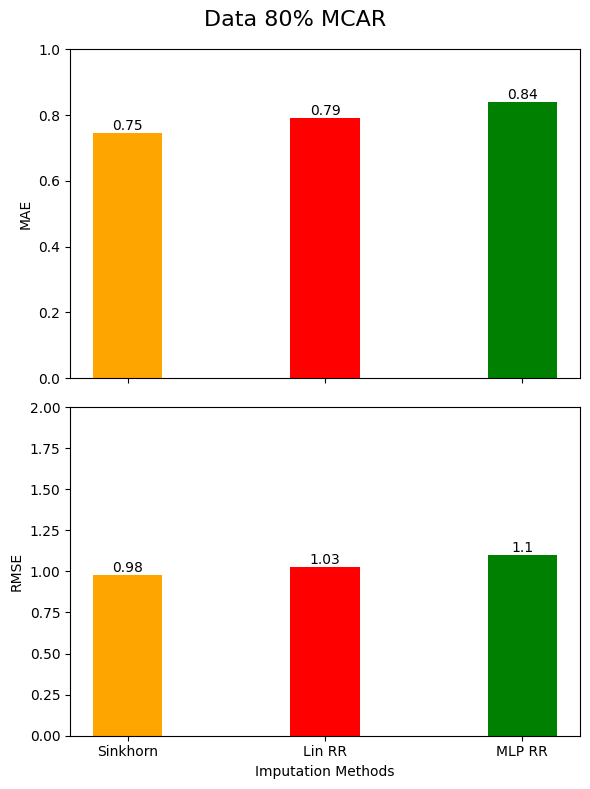

In [244]:

# Define values and categories
valuesOT_mae_mcar80 = [sk_mae_mcar80,lin_rr_mae_mcar80,mlp_rr_mae_mcar80]
valuesOT_rmse_mcar80 = [sk_rmse_mcar80,lin_rr_rmse_mcar80,mlp_rr_rmse_mcar80]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 80% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar80, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar80, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


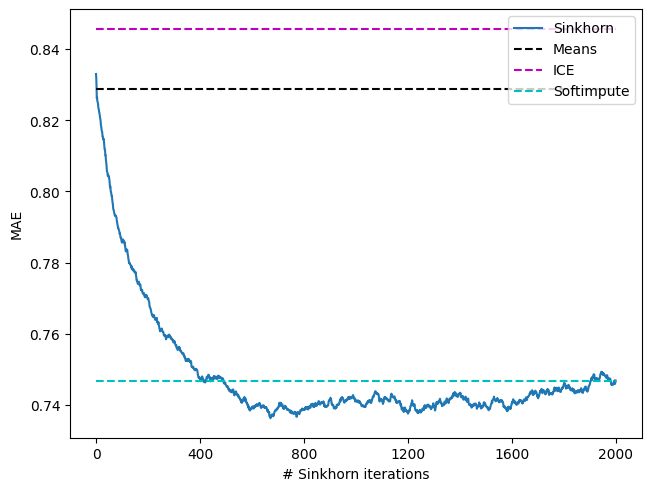

In [245]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes80mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes80mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar80, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar80, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar80, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

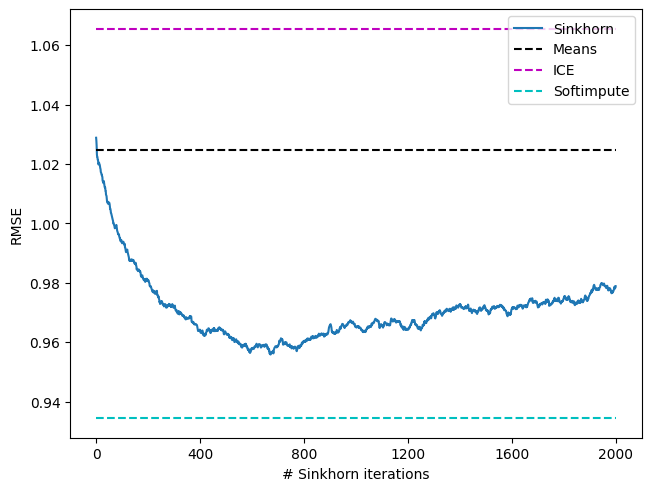

In [246]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses80mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses80mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar80, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar80, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar80, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

90% MCAR

In [247]:
#sinkhorn
n_mcar90, d_mcar90 = data_mcar90.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar90 = pick_epsilon(data_mcar90)

print(epsilon_mcar90)

sk_imputer_mcar90 = SinkhornImputation(eps=epsilon_mcar90, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar90, sk_maes90mcar, sk_rmses90mcar = sk_imputer_mcar90.fit_transform(data_mcar90, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar90_numpy = sk_imp_mcar90.detach().cpu().numpy()

sk_mae_mcar90 = MAE(sk_imp_mcar90_numpy,ground_truth_numpy ,mask_mcar90)
sk_rmse_mcar90 = RMSE(sk_imp_mcar90_numpy, ground_truth_numpy,mask_mcar90)
print(sk_mae_mcar90,sk_rmse_mcar90)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.0483
INFO:root:Iteration 0:	 Loss: 0.4434	 Validation MAE: 0.8298	RMSE: 1.0248


0.04831535796747027


INFO:root:Iteration 500:	 Loss: 0.2017	 Validation MAE: 0.8484	RMSE: 1.0657
INFO:root:Iteration 1000:	 Loss: 0.3672	 Validation MAE: 0.8709	RMSE: 1.0972
INFO:root:Iteration 1500:	 Loss: 0.3598	 Validation MAE: 0.8790	RMSE: 1.1114


0.8901212229798974 1.1257160556409371


In [248]:
#linear Round Robin
dmcar90_ = d_mcar90 - 1
models_liner_mcar90 = {}

for i in range(d_mcar90):
    models_liner_mcar90[i] = nn.Linear(dmcar90_, 1)

#Create the imputer
lin_rr_imputer_mcar90 = RRimputer(models_liner_mcar90, eps=epsilon_mcar90, lr=lr)
lin_rr_mcar90, lin_maesmcar90, lin_rmsesmcar90 = lin_rr_imputer_mcar90.fit_transform(data_mcar90, verbose=True, X_true=ground_truth)
lin_rr_mcar90_numpy = lin_rr_mcar90.detach().cpu().numpy()

lin_rr_mae_mcar90 = MAE(lin_rr_mcar90_numpy,ground_truth_numpy ,mask_mcar90)
lin_rr_rmse_mcar90 = RMSE(lin_rr_mcar90_numpy, ground_truth_numpy,mask_mcar90)
print(lin_rr_mae_mcar90,lin_rr_rmse_mcar90)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 0.8840	Validation MAE: 0.8136	RMSE:  1.0193
INFO:root:Iteration 1:	 Loss: 1.8820	Validation MAE: 0.8877	RMSE:  1.1291
INFO:root:Iteration 2:	 Loss: 2.2526	Validation MAE: 0.9050	RMSE:  1.1542
INFO:root:Iteration 3:	 Loss: 2.0399	Validation MAE: 0.8979	RMSE:  1.1391
INFO:root:Iteration 4:	 Loss: 1.4884	Validation MAE: 0.9123	RMSE:  1.1626
INFO:root:Iteration 5:	 Loss: 2.1897	Validation MAE: 0.9068	RMSE:  1.1540
INFO:root:Iteration 6:	 Loss: 1.4827	Validation MAE: 0.9095	RMSE:  1.1567
INFO:root:Iteration 7:	 Loss: 1.8423	Validation MAE: 0.9089	RMSE:  1.1568
INFO:root:Iteration 8:	 Loss: 1.9459	Validation MAE: 0.9080	RMSE:  1.1582
INFO:root:Iteration 9:	 Loss: 2.2567	Validation MAE: 0.9099	RMSE:  1.1606
INFO:root:Early stopping criterion not reached


0.9098536967713582 1.1606247981381272


In [249]:
#MLP Round Robin
dmcar90_ = d_mcar90 - 1
models_mlp_mcar90 = {}


for i in range(d_mcar90):
   models_mlp_mcar90[i] = nn.Sequential(nn.Linear(dmcar90_, 2 * dmcar90_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar90_, dmcar90_),
                              nn.ReLU(),
                              nn.Linear(dmcar90_, 1))

#Create the imputer
mlp_rr_imputer_mcar90 = RRimputer(models_mlp_mcar90, eps=epsilon_mcar90, lr=lr)

mlp_rr_mcar90, mlp_rr_maesmcar90, mlp_rr_rmsesmcar90 = mlp_rr_imputer_mcar90.fit_transform(data_mcar90, verbose=True, X_true=ground_truth)

mlp_rr_mcar90_numpy = mlp_rr_mcar90.detach().cpu().numpy()

mlp_rr_mae_mcar90 = MAE(mlp_rr_mcar90_numpy,ground_truth_numpy ,mask_mcar90)
mlp_rr_rmse_mcar90 = RMSE(mlp_rr_mcar90_numpy, ground_truth_numpy,mask_mcar90)
print(mlp_rr_mae_mcar90, mlp_rr_rmse_mcar90)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.7126	Validation MAE: 1.0002	RMSE:  1.2648
INFO:root:Iteration 1:	 Loss: 0.9433	Validation MAE: 0.9627	RMSE:  1.2246
INFO:root:Iteration 2:	 Loss: 1.1246	Validation MAE: 0.9877	RMSE:  1.2492
INFO:root:Iteration 3:	 Loss: 1.5112	Validation MAE: 1.0059	RMSE:  1.2794
INFO:root:Iteration 4:	 Loss: 1.2659	Validation MAE: 1.0100	RMSE:  1.2808
INFO:root:Iteration 5:	 Loss: 1.5480	Validation MAE: 1.0099	RMSE:  1.2877
INFO:root:Iteration 6:	 Loss: 1.2732	Validation MAE: 1.0157	RMSE:  1.2939
INFO:root:Iteration 7:	 Loss: 1.7425	Validation MAE: 1.0128	RMSE:  1.2863
INFO:root:Iteration 8:	 Loss: 2.1281	Validation MAE: 1.0150	RMSE:  1.2901
INFO:root:Iteration 9:	 Loss: 3.3495	Validation MAE: 1.0239	RMSE:  1.3008
INFO:root:Early stopping criterion not reached


1.0238610324649537 1.3007615631404927


In [250]:
#mean
#using numpy version of data
mean_imp_mcar90 = SimpleImputer().fit_transform(data_mcar90_numpy)
mean_mae_mcar90 = MAE(mean_imp_mcar90, ground_truth_numpy, mask_mcar90)
mean_rmse_mcar90 = RMSE(mean_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(mean_mae_mcar90, mean_rmse_mcar90)

#ICE
ice_imp_mcar90 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar90_numpy)
ice_mae_mcar90 = MAE(ice_imp_mcar90, ground_truth_numpy, mask_mcar90)
ice_rmse_mcar90 = RMSE(ice_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(ice_mae_mcar90,ice_rmse_mcar90)

#SoftImpute
cv_error_mcar90, grid_lambda_mcar90 = cv_softimpute(data_mcar90_numpy, grid_len=15)
lbda_mcar90 = grid_lambda_mcar90[np.argmin(cv_error_mcar90)]
soft_imp_mcar90 = softimpute((data_mcar90_numpy), lbda_mcar90)[1]

soft_mae_mcar90 = MAE(soft_imp_mcar90, ground_truth_numpy, mask_mcar90)
soft_rmse_mcar90 = RMSE(soft_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(soft_mae_mcar90,soft_rmse_mcar90)

0.8261797460567907 1.0199975719434713


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1.043578131297371 1.8370794091252436
0.8212143679551527 1.0092207991022732


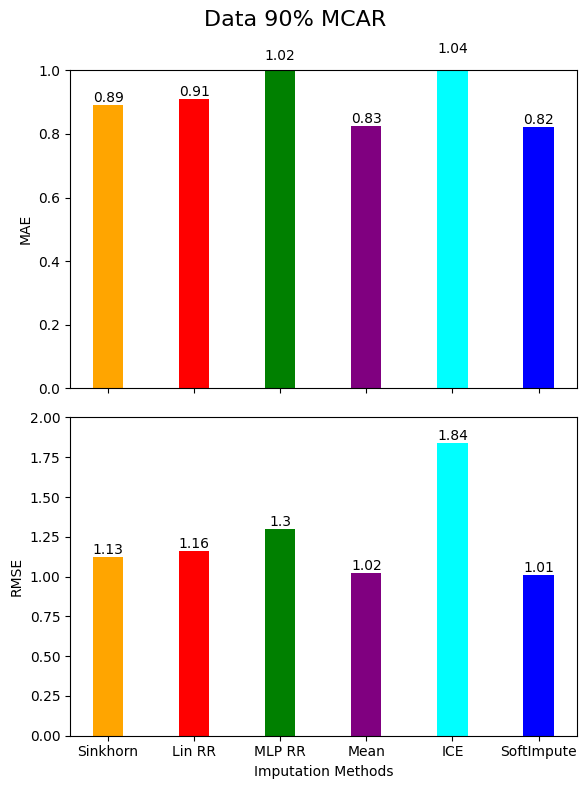

In [251]:

# Define values and categories
values_mae_mcar90 = [sk_mae_mcar90, lin_rr_mae_mcar90, mlp_rr_mae_mcar90, mean_mae_mcar90, ice_mae_mcar90, soft_mae_mcar90]
values_rmse_mcar90 = [sk_rmse_mcar90, lin_rr_rmse_mcar90, mlp_rr_rmse_mcar90, mean_rmse_mcar90, ice_rmse_mcar90, soft_rmse_mcar90]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 90% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar90, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar90, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


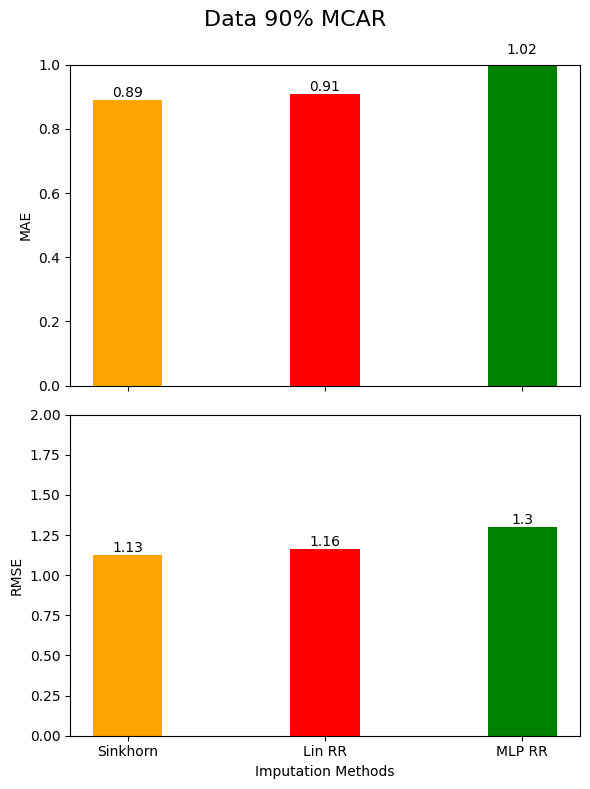

In [252]:

# Define values and categories
valuesOT_mae_mcar90 = [sk_mae_mcar90,lin_rr_mae_mcar90,mlp_rr_mae_mcar90]
valuesOT_rmse_mcar90 = [sk_rmse_mcar90,lin_rr_rmse_mcar90,mlp_rr_rmse_mcar90]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 90% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar90, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar90, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


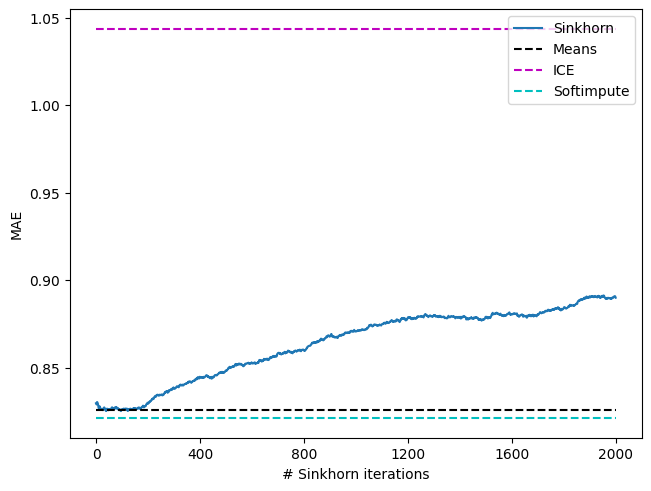

In [253]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes90mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes90mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar90, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar90, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar90, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

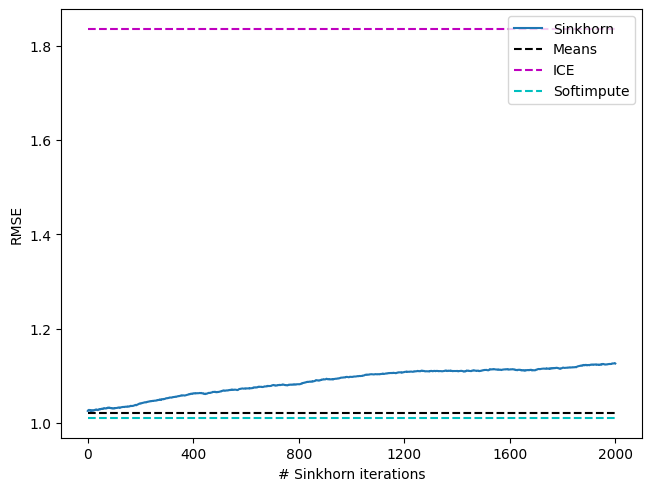

In [254]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses90mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses90mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar90, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar90, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar90, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

95% MCAR

In [255]:
#sinkhorn
n_mcar95, d_mcar95 = data_mcar95.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar95 = pick_epsilon(data_mcar95)

print(epsilon_mcar95)

sk_imputer_mcar95 = SinkhornImputation(eps=epsilon_mcar95, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar95, sk_maes95mcar, sk_rmses95mcar = sk_imputer_mcar95.fit_transform(data_mcar95, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar95_numpy = sk_imp_mcar95.detach().cpu().numpy()

sk_mae_mcar95 = MAE(sk_imp_mcar95_numpy,ground_truth_numpy ,mask_mcar95)
sk_rmse_mcar95 = RMSE(sk_imp_mcar95_numpy, ground_truth_numpy,mask_mcar95)
print(sk_mae_mcar95,sk_rmse_mcar95)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.0252


INFO:root:Iteration 0:	 Loss: 0.2486	 Validation MAE: 0.8464	RMSE: 1.0460


0.02521946096612593


INFO:root:Iteration 500:	 Loss: 0.1177	 Validation MAE: 0.8665	RMSE: 1.0715
INFO:root:Iteration 1000:	 Loss: 0.1056	 Validation MAE: 0.8753	RMSE: 1.0851
INFO:root:Iteration 1500:	 Loss: 0.0908	 Validation MAE: 0.8766	RMSE: 1.0871


0.8815055013133257 1.0908171007328875


In [256]:
#linear Round Robin
dmcar95_ = d_mcar95 - 1
models_liner_mcar95 = {}

for i in range(d_mcar95):
    models_liner_mcar95[i] = nn.Linear(dmcar95_, 1)

#Create the imputer
lin_rr_imputer_mcar95 = RRimputer(models_liner_mcar95, eps=epsilon_mcar95, lr=lr)
lin_rr_mcar95, lin_maesmcar95, lin_rmsesmcar95 = lin_rr_imputer_mcar95.fit_transform(data_mcar95, verbose=True, X_true=ground_truth)
lin_rr_mcar95_numpy = lin_rr_mcar95.detach().cpu().numpy()

lin_rr_mae_mcar95 = MAE(lin_rr_mcar95_numpy,ground_truth_numpy ,mask_mcar95)
lin_rr_rmse_mcar95 = RMSE(lin_rr_mcar95_numpy, ground_truth_numpy,mask_mcar95)
print(lin_rr_mae_mcar95,lin_rr_rmse_mcar95)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 0.9848	Validation MAE: 0.8412	RMSE:  1.0462
INFO:root:Iteration 1:	 Loss: 2.1801	Validation MAE: 0.9064	RMSE:  1.1446
INFO:root:Iteration 2:	 Loss: 1.6037	Validation MAE: 0.9079	RMSE:  1.1509
INFO:root:Iteration 3:	 Loss: 1.7913	Validation MAE: 0.9156	RMSE:  1.1599
INFO:root:Iteration 4:	 Loss: 2.5676	Validation MAE: 0.9170	RMSE:  1.1624
INFO:root:Iteration 5:	 Loss: 0.9612	Validation MAE: 0.9119	RMSE:  1.1510
INFO:root:Iteration 6:	 Loss: 1.4725	Validation MAE: 0.9262	RMSE:  1.1695
INFO:root:Iteration 7:	 Loss: 1.8020	Validation MAE: 0.9247	RMSE:  1.1667
INFO:root:Iteration 8:	 Loss: 1.9958	Validation MAE: 0.9253	RMSE:  1.1678
INFO:root:Iteration 9:	 Loss: 1.3421	Validation MAE: 0.9305	RMSE:  1.1736
INFO:root:Early stopping criterion not reached


0.9304803012861331 1.173559730929103


In [257]:
#MLP Round Robin
dmcar95_ = d_mcar95 - 1
models_mlp_mcar95 = {}


for i in range(d_mcar95):
   models_mlp_mcar95[i] = nn.Sequential(nn.Linear(dmcar95_, 2 * dmcar95_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar95_, dmcar95_),
                              nn.ReLU(),
                              nn.Linear(dmcar95_, 1))

#Create the imputer
mlp_rr_imputer_mcar95 = RRimputer(models_mlp_mcar95, eps=epsilon_mcar95, lr=lr)

mlp_rr_mcar95, mlp_rr_maesmcar95, mlp_rr_rmsesmcar95 = mlp_rr_imputer_mcar95.fit_transform(data_mcar95, verbose=True, X_true=ground_truth)

mlp_rr_mcar95_numpy = mlp_rr_mcar95.detach().cpu().numpy()

mlp_rr_mae_mcar95 = MAE(mlp_rr_mcar95_numpy,ground_truth_numpy ,mask_mcar95)
mlp_rr_rmse_mcar95 = RMSE(mlp_rr_mcar95_numpy, ground_truth_numpy,mask_mcar95)
print(mlp_rr_mae_mcar95, mlp_rr_rmse_mcar95)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 0.9895	Validation MAE: 0.9708	RMSE:  1.2316
INFO:root:Iteration 1:	 Loss: 0.9923	Validation MAE: 1.0122	RMSE:  1.2777
INFO:root:Iteration 2:	 Loss: 1.7980	Validation MAE: 1.0336	RMSE:  1.3083
INFO:root:Iteration 3:	 Loss: 1.1007	Validation MAE: 1.0317	RMSE:  1.3054
INFO:root:Iteration 4:	 Loss: 1.3447	Validation MAE: 1.0374	RMSE:  1.3159
INFO:root:Iteration 5:	 Loss: 0.9534	Validation MAE: 1.0367	RMSE:  1.3167
INFO:root:Iteration 6:	 Loss: 1.6609	Validation MAE: 1.0414	RMSE:  1.3228
INFO:root:Iteration 7:	 Loss: 2.1156	Validation MAE: 1.0377	RMSE:  1.3214
INFO:root:Iteration 8:	 Loss: 1.3935	Validation MAE: 1.0438	RMSE:  1.3305
INFO:root:Iteration 9:	 Loss: 1.2939	Validation MAE: 1.0471	RMSE:  1.3340
INFO:root:Early stopping criterion not reached


1.047108101758368 1.3339875614626975


In [258]:
#mean
#using numpy version of data
mean_imp_mcar95 = SimpleImputer().fit_transform(data_mcar95_numpy)
mean_mae_mcar95 = MAE(mean_imp_mcar95, ground_truth_numpy, mask_mcar95)
mean_rmse_mcar95 = RMSE(mean_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(mean_mae_mcar95, mean_rmse_mcar95)

#ICE
ice_imp_mcar95 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar95_numpy)
ice_mae_mcar95 = MAE(ice_imp_mcar95, ground_truth_numpy, mask_mcar95)
ice_rmse_mcar95 = RMSE(ice_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(ice_mae_mcar95,ice_rmse_mcar95)

#SoftImpute
cv_error_mcar95, grid_lambda_mcar95 = cv_softimpute(data_mcar95_numpy, grid_len=15)
lbda_mcar95 = grid_lambda_mcar95[np.argmin(cv_error_mcar95)]
soft_imp_mcar95 = softimpute((data_mcar95_numpy), lbda_mcar95)[1]

soft_mae_mcar95 = MAE(soft_imp_mcar95, ground_truth_numpy, mask_mcar95)
soft_rmse_mcar95 = RMSE(soft_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(soft_mae_mcar95,soft_rmse_mcar95)

0.8441986826406204 1.043300187972331


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


95.35660539047034 729.8159908015435
0.8248802139368356 1.0138799227906505


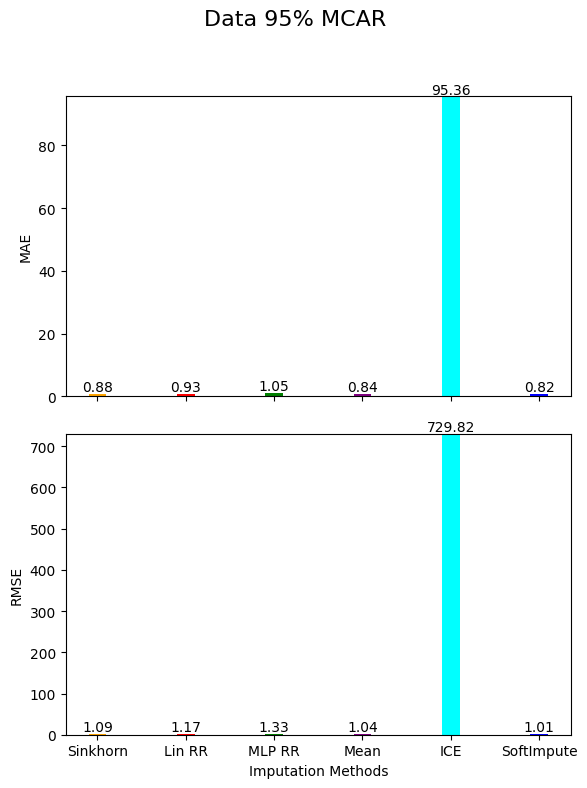

In [269]:

# Define values and categories
values_mae_mcar95 = [sk_mae_mcar95,lin_rr_mae_mcar95,mlp_rr_mae_mcar95, mean_mae_mcar95, ice_mae_mcar95, soft_mae_mcar95]
values_rmse_mcar95 = [sk_rmse_mcar95, lin_rr_rmse_mcar95, mlp_rr_rmse_mcar95, mean_rmse_mcar95, ice_rmse_mcar95, soft_rmse_mcar95]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.2 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 95% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar95, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, max(values_mae_mcar95) + 0.5)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar95, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, max(values_rmse_mcar95)+0.5)   # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
from RR_imputer import RRimputer
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

**Load the data**

In [ ]:
from sklearn.datasets import load_wine

In [ ]:
print(load_wine())

{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]]), 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
 

In [ ]:
ground_truth_numpy = scale(load_wine()['data']) #only taking the features
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [ ]:
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))

4.371372139554767
-3.6791622340370145
4.66735072755122e-16
-0.08109900443171775
1.0


In [ ]:
print(ground_truth_numpy)

[[ 1.51861254 -0.5622498   0.23205254 ...  0.36217728  1.84791957
   1.01300893]
 [ 0.24628963 -0.49941338 -0.82799632 ...  0.40605066  1.1134493
   0.96524152]
 [ 0.19687903  0.02123125  1.10933436 ...  0.31830389  0.78858745
   1.39514818]
 ...
 [ 0.33275817  1.74474449 -0.38935541 ... -1.61212515 -1.48544548
   0.28057537]
 [ 0.20923168  0.22769377  0.01273209 ... -1.56825176 -1.40069891
   0.29649784]
 [ 1.39508604  1.58316512  1.36520822 ... -1.52437837 -1.42894777
  -0.59516041]]


In [ ]:
print(ground_truth_numpy.shape)
ground_truth = torch.from_numpy(ground_truth_numpy)
print(ground_truth.isnan().sum())

(178, 13)
tensor(0)


**Creating missing values**

In [ ]:

#10% MCAR

np.random.seed(42)

p_macr10 = 0.10


mask_mcar10 = np.random.rand(*ground_truth.shape) < p_macr10  # True for missing values, false for others
data_mcar10 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar10[mask_mcar10] = np.nan

# Convert to a torch tensor
data_mcar10 = torch.from_numpy(data_mcar10)

# Calculate the percentage of missing values
missing_values_mcar10 = torch.isnan(data_mcar10)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar10 = torch.sum(missing_values_mcar10).item() / data_mcar10.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar10:.2f}%")


Percentage of missing values: 10.67%


In [ ]:
#15% MCAR

np.random.seed(42)

p_macr15 = 0.15


mask_mcar15 = np.random.rand(*ground_truth.shape) < p_macr15  # True for missing values, false for others
data_mcar15 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar15[mask_mcar15] = np.nan

# Convert to a torch tensor
data_mcar15 = torch.from_numpy(data_mcar15)

# Calculate the percentage of missing values
missing_values_mcar15 = torch.isnan(data_mcar15)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar15 = torch.sum(missing_values_mcar15).item() / data_mcar15.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar15:.2f}%")

Percentage of missing values: 15.99%


In [ ]:
#20% MCAR
np.random.seed(42)

p_macr20 = 0.20


mask_mcar20 = np.random.rand(*ground_truth.shape) < p_macr20  # True for missing values, false for others
data_mcar20 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar20[mask_mcar20] = np.nan

# Convert to a torch tensor
data_mcar20 = torch.from_numpy(data_mcar20)

# Calculate the percentage of missing values
missing_values_mcar20 = torch.isnan(data_mcar20)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar20 = torch.sum(missing_values_mcar20).item() / data_mcar20.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar20:.2f}%")

Percentage of missing values: 21.13%


In [ ]:
#25% MCAR
np.random.seed(42)

p_macr25 = 0.25


mask_mcar25 = np.random.rand(*ground_truth.shape) < p_macr25  # True for missing values, false for others
data_mcar25 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar25[mask_mcar25] = np.nan

# Convert to a torch tensor
data_mcar25 = torch.from_numpy(data_mcar25)

# Calculate the percentage of missing values
missing_values_mcar25 = torch.isnan(data_mcar25)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar25 = torch.sum(missing_values_mcar25).item() / data_mcar25.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar25:.2f}%")

Percentage of missing values: 26.10%


In [ ]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.30


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 30.73%


In [ ]:
#35% MCAR
np.random.seed(42)

p_macr35 = 0.35


mask_mcar35 = np.random.rand(*ground_truth.shape) < p_macr35  # True for missing values, false for others
data_mcar35 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar35[mask_mcar35] = np.nan

# Convert to a torch tensor
data_mcar35 = torch.from_numpy(data_mcar35)

# Calculate the percentage of missing values
missing_values_mcar35 = torch.isnan(data_mcar35)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar35 = torch.sum(missing_values_mcar35).item() / data_mcar35.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar35:.2f}%")

Percentage of missing values: 35.31%


In [ ]:
#40% MCAR
np.random.seed(42)

p_macr40 = 0.40


mask_mcar40 = np.random.rand(*ground_truth.shape) < p_macr40  # True for missing values, false for others
data_mcar40 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar40[mask_mcar40] = np.nan

# Convert to a torch tensor
data_mcar40 = torch.from_numpy(data_mcar40)

# Calculate the percentage of missing values
missing_values_mcar40 = torch.isnan(data_mcar40)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar40 = torch.sum(missing_values_mcar40).item() / data_mcar40.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar40:.2f}%")

Percentage of missing values: 40.02%


In [ ]:
#45% MCAR
np.random.seed(42)

p_macr45 = 0.45


mask_mcar45 = np.random.rand(*ground_truth.shape) < p_macr45  # True for missing values, false for others
data_mcar45 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar45[mask_mcar45] = np.nan

# Convert to a torch tensor
data_mcar45 = torch.from_numpy(data_mcar45)

# Calculate the percentage of missing values
missing_values_mcar45 = torch.isnan(data_mcar45)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar45 = torch.sum(missing_values_mcar45).item() / data_mcar45.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar45:.2f}%")

Percentage of missing values: 44.30%


In [ ]:
#50% MCAR
np.random.seed(42)

p_macr50 = 0.50


mask_mcar50 = np.random.rand(*ground_truth.shape) < p_macr50  # True for missing values, false for others
data_mcar50 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar50[mask_mcar50] = np.nan

# Convert to a torch tensor
data_mcar50 = torch.from_numpy(data_mcar50)

# Calculate the percentage of missing values
missing_values_mcar50 = torch.isnan(data_mcar50)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar50 = torch.sum(missing_values_mcar50).item() / data_mcar50.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar50:.2f}%")

Percentage of missing values: 49.22%


In [ ]:
#60% MCAR
np.random.seed(42)

p_macr60 = 0.60


mask_mcar60 = np.random.rand(*ground_truth.shape) < p_macr60  # True for missing values, false for others
data_mcar60 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar60[mask_mcar60] = np.nan

# Convert to a torch tensor
data_mcar60 = torch.from_numpy(data_mcar60)

# Calculate the percentage of missing values
missing_values_mcar60 = torch.isnan(data_mcar60)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar60 = torch.sum(missing_values_mcar60).item() / data_mcar60.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar60:.2f}%")

Percentage of missing values: 59.20%


In [ ]:
#70 MCAR
np.random.seed(42)

p_macr70 = 0.70


mask_mcar70 = np.random.rand(*ground_truth.shape) < p_macr70  # True for missing values, false for others
data_mcar70 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar70[mask_mcar70] = np.nan

# Convert to a torch tensor
data_mcar70 = torch.from_numpy(data_mcar70)

# Calculate the percentage of missing values
missing_values_mcar70 = torch.isnan(data_mcar70)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar70 = torch.sum(missing_values_mcar70).item() / data_mcar70.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar70:.2f}%")

Percentage of missing values: 70.18%


In [ ]:
#80% MCAR
np.random.seed(42)

p_macr80 = 0.80


mask_mcar80 = np.random.rand(*ground_truth.shape) < p_macr80  # True for missing values, false for others
data_mcar80 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar80[mask_mcar80] = np.nan

# Convert to a torch tensor
data_mcar80 = torch.from_numpy(data_mcar80)

# Calculate the percentage of missing values
missing_values_mcar80 = torch.isnan(data_mcar80)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar80 = torch.sum(missing_values_mcar80).item() / data_mcar80.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar80:.2f}%")

Percentage of missing values: 79.73%


In [ ]:
#90% MCAR
np.random.seed(42)

p_macr90 = 0.9


mask_mcar90 = np.random.rand(*ground_truth.shape) < p_macr90  # True for missing values, false for others
data_mcar90 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar90[mask_mcar90] = np.nan

# Convert to a torch tensor
data_mcar90 = torch.from_numpy(data_mcar90)

# Calculate the percentage of missing values
missing_values_mcar90 = torch.isnan(data_mcar90)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar90 = torch.sum(missing_values_mcar90).item() / data_mcar90.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar90:.2f}%")

Percentage of missing values: 90.28%


In [ ]:
#95% MCAR
np.random.seed(42)

p_macr95 = 0.95


mask_mcar95 = np.random.rand(*ground_truth.shape) < p_macr95  # True for missing values, false for others
data_mcar95 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar95[mask_mcar95] = np.nan

# Convert to a torch tensor
data_mcar95 = torch.from_numpy(data_mcar95)

# Calculate the percentage of missing values
missing_values_mcar95 = torch.isnan(data_mcar95)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar95 = torch.sum(missing_values_mcar95).item() / data_mcar95.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar95:.2f}%")

Percentage of missing values: 94.86%


In [ ]:
#%100 MCAR
np.random.seed(42)

p_macr100 = 1


mask_mcar100 = np.random.rand(*ground_truth.shape) < p_macr100  # True for missing values, false for others
data_mcar100 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar100[mask_mcar100] = np.nan

# Convert to a torch tensor
data_mcar100 = torch.from_numpy(data_mcar100)

# Calculate the percentage of missing values
missing_values_mcar100 = torch.isnan(data_mcar100)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar100 = torch.sum(missing_values_mcar100).item() / data_mcar100.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar100:.2f}%")

Percentage of missing values: 100.00%


In [ ]:
data_mcar10_numpy = data_mcar10.detach().cpu().numpy()
data_mcar15_numpy = data_mcar15.detach().cpu().numpy()
data_mcar20_numpy = data_mcar20.detach().cpu().numpy()
data_mcar25_numpy = data_mcar25.detach().cpu().numpy()
data_mcar30_numpy = data_mcar30.detach().cpu().numpy()
data_mcar35_numpy = data_mcar35.detach().cpu().numpy()
data_mcar40_numpy = data_mcar40.detach().cpu().numpy()
data_mcar45_numpy = data_mcar45.detach().cpu().numpy()
data_mcar50_numpy = data_mcar50.detach().cpu().numpy()
data_mcar60_numpy = data_mcar60.detach().cpu().numpy()
data_mcar70_numpy = data_mcar70.detach().cpu().numpy()
data_mcar80_numpy = data_mcar80.detach().cpu().numpy()
data_mcar90_numpy = data_mcar90.detach().cpu().numpy()
data_mcar95_numpy = data_mcar95.detach().cpu().numpy()

**10% MCAR**

In [ ]:
n_mcar10, d_mcar10 = data_mcar10.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar10 = pick_epsilon(data_mcar10)
print(epsilon_mcar10)

0.5396111155787111


In [ ]:
sk_imputer_mcar10 = SinkhornImputation(eps=epsilon_mcar10, batchsize=batchsize, lr=lr, niter=2000)

In [ ]:
sk_imp_mcar10, sk_maes10mcar, sk_rmses10mcar = sk_imputer_mcar10.fit_transform(data_mcar10, verbose=True, report_interval=500, X_true=ground_truth)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.5396
INFO:root:Iteration 0:	 Loss: 2.3676	 Validation MAE: 0.8928	RMSE: 1.0745
INFO:root:Iteration 500:	 Loss: 2.0987	 Validation MAE: 0.5577	RMSE: 0.7651
INFO:root:Iteration 1000:	 Loss: 2.1531	 Validation MAE: 0.5563	RMSE: 0.7623
INFO:root:Iteration 1500:	 Loss: 1.8736	 Validation MAE: 0.5532	RMSE: 0.7553


In [ ]:
#using numpy version of data
sk_imp_mcar10_numpy = sk_imp_mcar10.detach().cpu().numpy()

In [ ]:
sk_mae_mcar10 = MAE(sk_imp_mcar10_numpy,ground_truth_numpy ,mask_mcar10)
sk_rmse_mcar10 = RMSE(sk_imp_mcar10_numpy, ground_truth_numpy,mask_mcar10)
print(sk_mae_mcar10,sk_rmse_mcar10)

0.5569016041443097 0.7599522382832292


In [ ]:
#linear Round Robin
dmcar10_ = d_mcar10 - 1
models_liner_mcar10 = {}

for i in range(d_mcar10):
    models_liner_mcar10[i] = nn.Linear(dmcar10_, 1)

#Create the imputer
lin_rr_imputer_mcar10 = RRimputer(models_liner_mcar10, eps=epsilon_mcar10, lr=lr)
lin_rr_mcar10, lin_maesmcar10, lin_rmsesmcar10 = lin_rr_imputer_mcar10.fit_transform(data_mcar10, verbose=True, X_true=ground_truth)
lin_rr_mcar10_numpy = lin_rr_mcar10.detach().cpu().numpy()

lin_rr_mae_mcar10 = MAE(lin_rr_mcar10_numpy,ground_truth_numpy ,mask_mcar10)
lin_rr_rmse_mcar10 = RMSE(lin_rr_mcar10_numpy, ground_truth_numpy,mask_mcar10)
print(lin_rr_mae_mcar10,lin_rr_rmse_mcar10)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 2.2988	Validation MAE: 0.7429	RMSE:  0.9627
INFO:root:Iteration 1:	 Loss: 2.1474	Validation MAE: 0.6617	RMSE:  0.8777
INFO:root:Iteration 2:	 Loss: 2.1784	Validation MAE: 0.6227	RMSE:  0.8296
INFO:root:Iteration 3:	 Loss: 2.0167	Validation MAE: 0.6114	RMSE:  0.8044
INFO:root:Iteration 4:	 Loss: 2.0066	Validation MAE: 0.6085	RMSE:  0.7954
INFO:root:Iteration 5:	 Loss: 2.2918	Validation MAE: 0.6042	RMSE:  0.7867
INFO:root:Iteration 6:	 Loss: 2.1489	Validation MAE: 0.5946	RMSE:  0.7798
INFO:root:Iteration 7:	 Loss: 2.2998	Validation MAE: 0.5932	RMSE:  0.7807
INFO:root:Iteration 8:	 Loss: 2.0625	Validation MAE: 0.5950	RMSE:  0.7866
INFO:root:Iteration 9:	 Loss: 2.0944	Validation MAE: 0.5846	RMSE:  0.7712
INFO:root:Early stopping criterion not reached


0.5846220124871554 0.7712115515892818


In [ ]:
#MLP Round Robin
dmcar10_ = d_mcar10 - 1
models_mlp_mcar10 = {}


for i in range(d_mcar10):
   models_mlp_mcar10[i] = nn.Sequential(nn.Linear(dmcar10_, 2 * dmcar10_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar10_, dmcar10_),
                              nn.ReLU(),
                              nn.Linear(dmcar10_, 1))

#Create the imputer
mlp_rr_imputer_mcar10 = RRimputer(models_mlp_mcar10, eps=epsilon_mcar10, lr=lr)

mlp_rr_mcar10, mlp_rr_maesmcar10, mlp_rr_rmsesmcar10 = mlp_rr_imputer_mcar10.fit_transform(data_mcar10, verbose=True, X_true=ground_truth)

mlp_rr_mcar10_numpy = mlp_rr_mcar10.detach().cpu().numpy()

mlp_rr_mae_mcar10 = MAE(mlp_rr_mcar10_numpy,ground_truth_numpy ,mask_mcar10)
mlp_rr_rmse_mcar10 = RMSE(mlp_rr_mcar10_numpy, ground_truth_numpy,mask_mcar10)
print(mlp_rr_mae_mcar10,mlp_rr_rmse_mcar10)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 2.1068	Validation MAE: 0.5892	RMSE:  0.8112
INFO:root:Iteration 1:	 Loss: 2.0220	Validation MAE: 0.5641	RMSE:  0.7555
INFO:root:Iteration 2:	 Loss: 2.0867	Validation MAE: 0.5573	RMSE:  0.7629
INFO:root:Iteration 3:	 Loss: 1.9185	Validation MAE: 0.5553	RMSE:  0.7522
INFO:root:Iteration 4:	 Loss: 2.0854	Validation MAE: 0.5684	RMSE:  0.7502
INFO:root:Iteration 5:	 Loss: 2.0336	Validation MAE: 0.5596	RMSE:  0.7477
INFO:root:Iteration 6:	 Loss: 2.1134	Validation MAE: 0.5581	RMSE:  0.7625
INFO:root:Iteration 7:	 Loss: 2.2003	Validation MAE: 0.5713	RMSE:  0.7838
INFO:root:Iteration 8:	 Loss: 2.2168	Validation MAE: 0.5640	RMSE:  0.7771
INFO:root:Iteration 9:	 Loss: 2.2211	Validation MAE: 0.5533	RMSE:  0.7553
INFO:root:Early stopping criterion not reached


0.5533243155908305 0.7552523276526799


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar10 = SimpleImputer().fit_transform(data_mcar10_numpy)
mean_mae_mcar10 = MAE(mean_imp_mcar10, ground_truth_numpy, mask_mcar10)
mean_rmse_mcar10= RMSE(mean_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(mean_mae_mcar10, mean_rmse_mcar10)

0.8832041436304651 1.0695028214345976


In [ ]:
ice_imp_mcar10 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar10_numpy)
ice_mae_mcar10 = MAE(ice_imp_mcar10, ground_truth_numpy, mask_mcar10)
ice_rmse_mcar10 = RMSE(ice_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(ice_mae_mcar10,ice_rmse_mcar10)

0.600651605442842 0.7654525822455341


In [ ]:
cv_error_mcar10, grid_lambda_mcar10 = cv_softimpute(data_mcar10_numpy, grid_len=15)
lbda_mcar10 = grid_lambda_mcar10[np.argmin(cv_error_mcar10)]
soft_imp_mcar10 = softimpute((data_mcar10_numpy), lbda_mcar10)[1]

soft_mae_mcar10 = MAE(soft_imp_mcar10, ground_truth_numpy, mask_mcar10)
soft_rmse_mcar10 = RMSE(soft_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(soft_mae_mcar10,soft_rmse_mcar10)

0.6200625574355908 0.8010876070604417


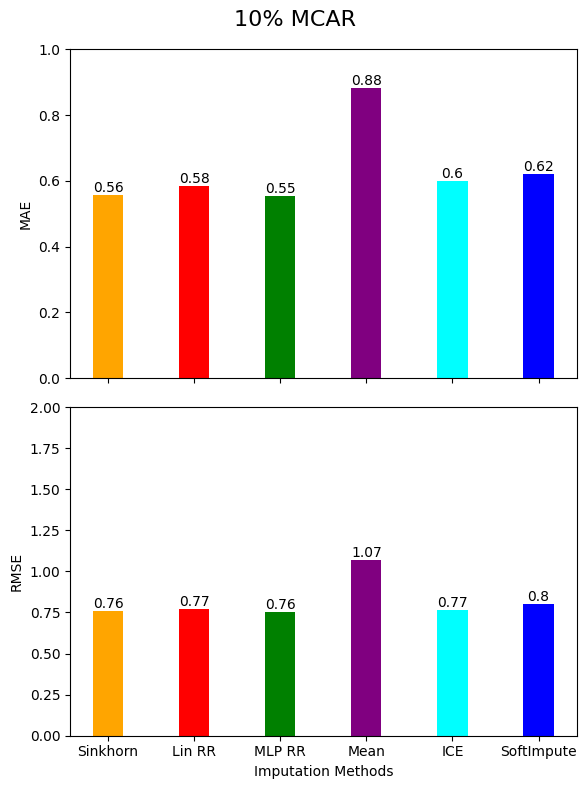

In [ ]:

# Define values and categories
values_mae_mcar10 = [sk_mae_mcar10, lin_rr_mae_mcar10, mlp_rr_mae_mcar10, mean_mae_mcar10, ice_mae_mcar10, soft_mae_mcar10]
values_rmse_mcar10 = [sk_rmse_mcar10,lin_rr_rmse_mcar10, mlp_rr_rmse_mcar10, mean_rmse_mcar10, ice_rmse_mcar10, soft_rmse_mcar10]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('10% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar10, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar10, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


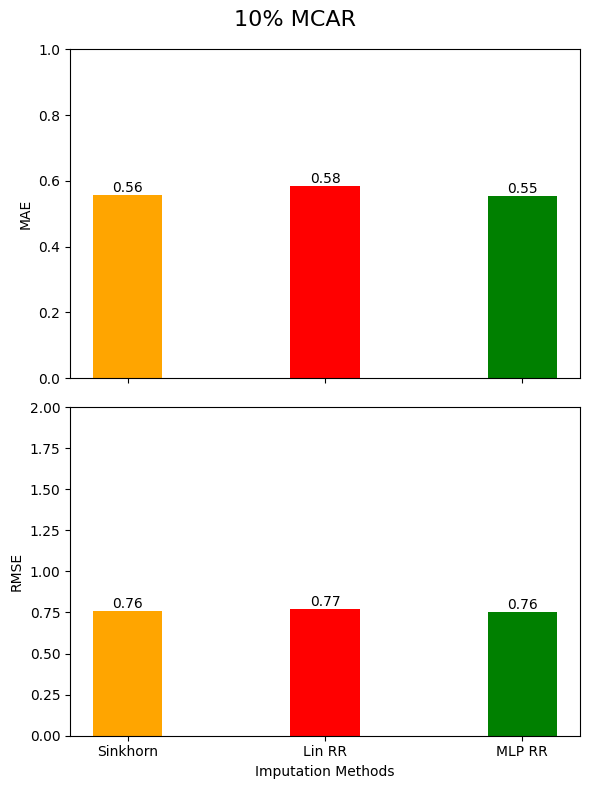

In [ ]:

# Define values and categories
valuesOT_mae_mcar10 = [sk_mae_mcar10, lin_rr_mae_mcar10, mlp_rr_mae_mcar10]
valuesOT_rmse_mcar10 = [sk_rmse_mcar10,lin_rr_rmse_mcar10, mlp_rr_rmse_mcar10]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('10% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar10, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar10, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**15% MCAR**

In [ ]:
#sinkhorn
n_mcar15, d_mcar15 = data_mcar15.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar15 = pick_epsilon(data_mcar15)

print(epsilon_mcar15)

sk_imputer_mcar15 = SinkhornImputation(eps=epsilon_mcar15, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar15, sk_maes15mcar, sk_rmses15mcar = sk_imputer_mcar15.fit_transform(data_mcar15, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar15_numpy = sk_imp_mcar15.detach().cpu().numpy()

sk_mae_mcar15 = MAE(sk_imp_mcar15_numpy,ground_truth_numpy ,mask_mcar15)
sk_rmse_mcar15 = RMSE(sk_imp_mcar15_numpy, ground_truth_numpy,mask_mcar15)
print(sk_mae_mcar15,sk_rmse_mcar15)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.5008
INFO:root:Iteration 0:	 Loss: 2.5466	 Validation MAE: 0.8654	RMSE: 1.0540


0.5008328716803875


INFO:root:Iteration 500:	 Loss: 2.1470	 Validation MAE: 0.5603	RMSE: 0.7728
INFO:root:Iteration 1000:	 Loss: 1.9331	 Validation MAE: 0.5540	RMSE: 0.7616
INFO:root:Iteration 1500:	 Loss: 1.5585	 Validation MAE: 0.5498	RMSE: 0.7563


0.5501877338179378 0.7555825379570089


In [ ]:
#linear Round Robin
dmcar15_ = d_mcar15 - 1
models_liner_mcar15 = {}

for i in range(d_mcar15):
    models_liner_mcar15[i] = nn.Linear(dmcar15_, 1)

#Create the imputer
lin_rr_imputer_mcar15 = RRimputer(models_liner_mcar15, eps=epsilon_mcar15, lr=lr)
lin_rr_mcar15, lin_maesmcar15, lin_rmsesmcar15 = lin_rr_imputer_mcar15.fit_transform(data_mcar15, verbose=True, X_true=ground_truth)
lin_rr_mcar15_numpy = lin_rr_mcar15.detach().cpu().numpy()

lin_rr_mae_mcar15 = MAE(lin_rr_mcar15_numpy,ground_truth_numpy ,mask_mcar15)
lin_rr_rmse_mcar15 = RMSE(lin_rr_mcar15_numpy, ground_truth_numpy,mask_mcar15)
print(lin_rr_mae_mcar15,lin_rr_rmse_mcar15)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 2.1755	Validation MAE: 0.7115	RMSE:  0.9151
INFO:root:Iteration 1:	 Loss: 2.0387	Validation MAE: 0.6480	RMSE:  0.8509
INFO:root:Iteration 2:	 Loss: 2.0736	Validation MAE: 0.6257	RMSE:  0.8264
INFO:root:Iteration 3:	 Loss: 2.0503	Validation MAE: 0.6117	RMSE:  0.8103
INFO:root:Iteration 4:	 Loss: 1.9974	Validation MAE: 0.6052	RMSE:  0.7985
INFO:root:Iteration 5:	 Loss: 1.9289	Validation MAE: 0.6049	RMSE:  0.8015
INFO:root:Iteration 6:	 Loss: 2.0157	Validation MAE: 0.5929	RMSE:  0.7896
INFO:root:Iteration 7:	 Loss: 2.0243	Validation MAE: 0.5886	RMSE:  0.7857
INFO:root:Iteration 8:	 Loss: 1.9946	Validation MAE: 0.5918	RMSE:  0.7873
INFO:root:Iteration 9:	 Loss: 2.1658	Validation MAE: 0.5946	RMSE:  0.7916
INFO:root:Early stopping criterion not reached


0.5946027855557728 0.7916335718830229


In [ ]:
#MLP Round Robin
dmcar15_ = d_mcar15 - 1
models_mlp_mcar15 = {}


for i in range(d_mcar15):
   models_mlp_mcar15[i] = nn.Sequential(nn.Linear(dmcar15_, 2 * dmcar15_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar15_, dmcar15_),
                              nn.ReLU(),
                              nn.Linear(dmcar15_, 1))

#Create the imputer
mlp_rr_imputer_mcar15 = RRimputer(models_mlp_mcar15, eps=epsilon_mcar15, lr=lr)

mlp_rr_mcar15, mlp_rr_maesmcar15, mlp_rr_rmsesmcar15 = mlp_rr_imputer_mcar15.fit_transform(data_mcar15, verbose=True, X_true=ground_truth)

mlp_rr_mcar15_numpy = mlp_rr_mcar15.detach().cpu().numpy()

mlp_rr_mae_mcar15 = MAE(mlp_rr_mcar15_numpy,ground_truth_numpy ,mask_mcar15)
mlp_rr_rmse_mcar15 = RMSE(mlp_rr_mcar15_numpy, ground_truth_numpy,mask_mcar15)
print(mlp_rr_mae_mcar15,mlp_rr_rmse_mcar15)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 2.0051	Validation MAE: 0.6199	RMSE:  0.8352
INFO:root:Iteration 1:	 Loss: 1.9871	Validation MAE: 0.5846	RMSE:  0.7925
INFO:root:Iteration 2:	 Loss: 2.0292	Validation MAE: 0.5690	RMSE:  0.7785
INFO:root:Iteration 3:	 Loss: 2.0142	Validation MAE: 0.5618	RMSE:  0.7608
INFO:root:Iteration 4:	 Loss: 2.1077	Validation MAE: 0.5700	RMSE:  0.7739
INFO:root:Iteration 5:	 Loss: 1.9693	Validation MAE: 0.5686	RMSE:  0.7692
INFO:root:Iteration 6:	 Loss: 1.9733	Validation MAE: 0.5632	RMSE:  0.7714
INFO:root:Iteration 7:	 Loss: 1.9381	Validation MAE: 0.5685	RMSE:  0.7808
INFO:root:Iteration 8:	 Loss: 1.8820	Validation MAE: 0.5569	RMSE:  0.7643
INFO:root:Iteration 9:	 Loss: 1.9773	Validation MAE: 0.5677	RMSE:  0.7849
INFO:root:Early stopping criterion not reached


0.5676716726861973 0.7849062373046215


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar15 = SimpleImputer().fit_transform(data_mcar15_numpy)
mean_mae_mcar15 = MAE(mean_imp_mcar15, ground_truth_numpy, mask_mcar15)
mean_rmse_mcar15= RMSE(mean_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(mean_mae_mcar15, mean_rmse_mcar15)

#ICE
ice_imp_mcar15 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar15_numpy)
ice_mae_mcar15 = MAE(ice_imp_mcar15, ground_truth_numpy, mask_mcar15)
ice_rmse_mcar15 = RMSE(ice_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(ice_mae_mcar15,ice_rmse_mcar15)

#SoftImpute
cv_error_mcar15, grid_lambda_mcar15 = cv_softimpute(data_mcar15_numpy, grid_len=15)
lbda_mcar15 = grid_lambda_mcar15[np.argmin(cv_error_mcar15)]
soft_imp_mcar15 = softimpute((data_mcar15_numpy), lbda_mcar15)[1]

soft_mae_mcar15 = MAE(soft_imp_mcar15, ground_truth_numpy, mask_mcar15)
soft_rmse_mcar15 = RMSE(soft_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(soft_mae_mcar15,soft_rmse_mcar15)



0.8620050840645891 1.0503788852986544
0.6016562019899981 0.7673245130234843
0.6317177134614647 0.8113810886573795


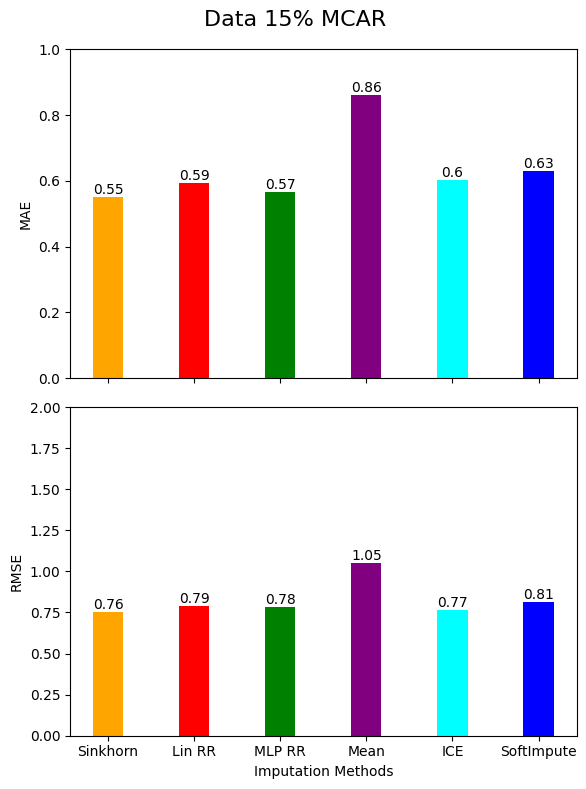

In [ ]:

# Define values and categories
values_mae_mcar15 = [sk_mae_mcar15,lin_rr_mae_mcar15,mlp_rr_mae_mcar15, mean_mae_mcar15, ice_mae_mcar15, soft_mae_mcar15]
values_rmse_mcar15 = [sk_rmse_mcar15,lin_rr_rmse_mcar15,mlp_rr_rmse_mcar15, mean_rmse_mcar15, ice_rmse_mcar15, soft_rmse_mcar15]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 15% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar15, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar15, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


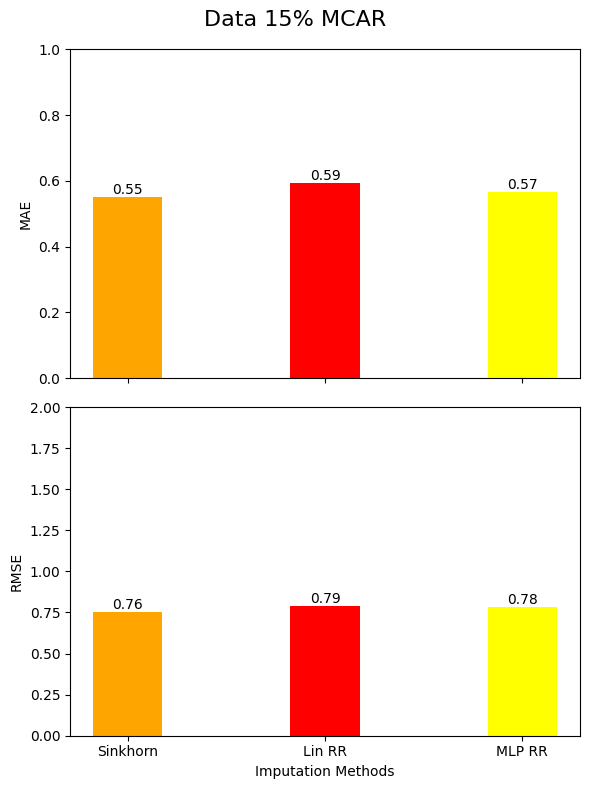

In [ ]:

# Define values and categories
valuesOT_mae_mcar15 = [sk_mae_mcar15,lin_rr_mae_mcar15,mlp_rr_mae_mcar15]
valuesOT_rmse_mcar15 = [sk_rmse_mcar15,lin_rr_rmse_mcar15,mlp_rr_rmse_mcar15]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','yellow']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 15% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar15, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar15, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**20% MCAR**

In [ ]:
#sinkhorn
n_mcar20, d_mcar20 = data_mcar20.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar20 = pick_epsilon(data_mcar20)

print(epsilon_mcar20)

sk_imputer_mcar20 = SinkhornImputation(eps=epsilon_mcar20, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar20, sk_maes20mcar, sk_rmses20mcar = sk_imputer_mcar20.fit_transform(data_mcar20, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar20_numpy = sk_imp_mcar20.detach().cpu().numpy()

sk_mae_mcar20 = MAE(sk_imp_mcar20_numpy,ground_truth_numpy ,mask_mcar20)
sk_rmse_mcar20 = RMSE(sk_imp_mcar20_numpy, ground_truth_numpy,mask_mcar20)
print(sk_mae_mcar20,sk_rmse_mcar20)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.4573
INFO:root:Iteration 0:	 Loss: 2.0273	 Validation MAE: 0.8666	RMSE: 1.0669


0.4573112351005496


INFO:root:Iteration 500:	 Loss: 1.5738	 Validation MAE: 0.5918	RMSE: 0.8360
INFO:root:Iteration 1000:	 Loss: 1.6667	 Validation MAE: 0.5951	RMSE: 0.8308
INFO:root:Iteration 1500:	 Loss: 1.8932	 Validation MAE: 0.5980	RMSE: 0.8240


0.5949971949259407 0.8218953566791392


In [ ]:
#linear Round Robin
dmcar20_ = d_mcar20 - 1
models_liner_mcar20 = {}

for i in range(d_mcar20):
    models_liner_mcar20[i] = nn.Linear(dmcar20_, 1)

#Create the imputer
lin_rr_imputer_mcar20 = RRimputer(models_liner_mcar20, eps=epsilon_mcar20, lr=lr)
lin_rr_mcar20, lin_maesmcar20, lin_rmsesmcar20 = lin_rr_imputer_mcar20.fit_transform(data_mcar20, verbose=True, X_true=ground_truth)
lin_rr_mcar20_numpy = lin_rr_mcar20.detach().cpu().numpy()

lin_rr_mae_mcar20 = MAE(lin_rr_mcar20_numpy,ground_truth_numpy ,mask_mcar20)
lin_rr_rmse_mcar20 = RMSE(lin_rr_mcar20_numpy, ground_truth_numpy,mask_mcar20)
print(lin_rr_mae_mcar20,lin_rr_rmse_mcar20)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.9835	Validation MAE: 0.7283	RMSE:  0.9572
INFO:root:Iteration 1:	 Loss: 1.8608	Validation MAE: 0.6638	RMSE:  0.8915
INFO:root:Iteration 2:	 Loss: 1.9194	Validation MAE: 0.6482	RMSE:  0.8726
INFO:root:Iteration 3:	 Loss: 1.8466	Validation MAE: 0.6383	RMSE:  0.8572
INFO:root:Iteration 4:	 Loss: 1.9384	Validation MAE: 0.6286	RMSE:  0.8459
INFO:root:Iteration 5:	 Loss: 1.9339	Validation MAE: 0.6251	RMSE:  0.8455
INFO:root:Iteration 6:	 Loss: 1.8248	Validation MAE: 0.6203	RMSE:  0.8391
INFO:root:Iteration 7:	 Loss: 1.9280	Validation MAE: 0.6231	RMSE:  0.8416
INFO:root:Iteration 8:	 Loss: 1.7613	Validation MAE: 0.6146	RMSE:  0.8353
INFO:root:Iteration 9:	 Loss: 1.9828	Validation MAE: 0.6146	RMSE:  0.8338
INFO:root:Early stopping criterion not reached


0.6146147132951759 0.8337636474313764


In [ ]:
#MLP Round Robin
dmcar20_ = d_mcar20 - 1
models_mlp_mcar20 = {}


for i in range(d_mcar20):
   models_mlp_mcar20[i] = nn.Sequential(nn.Linear(dmcar20_, 2 * dmcar20_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar20_, dmcar20_),
                              nn.ReLU(),
                              nn.Linear(dmcar20_, 1))

#Create the imputer
mlp_rr_imputer_mcar20 = RRimputer(models_mlp_mcar20, eps=epsilon_mcar20, lr=lr)

mlp_rr_mcar20, mlp_rr_maesmcar20, mlp_rr_rmsesmcar20 = mlp_rr_imputer_mcar20.fit_transform(data_mcar20, verbose=True, X_true=ground_truth)

mlp_rr_mcar20_numpy = mlp_rr_mcar20.detach().cpu().numpy()

mlp_rr_mae_mcar20 = MAE(mlp_rr_mcar20_numpy,ground_truth_numpy ,mask_mcar20)
mlp_rr_rmse_mcar20 = RMSE(mlp_rr_mcar20_numpy, ground_truth_numpy,mask_mcar20)
print(mlp_rr_mae_mcar20,mlp_rr_rmse_mcar20)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.


INFO:root:Iteration 0:	 Loss: 2.0566	Validation MAE: 0.6317	RMSE:  0.8759
INFO:root:Iteration 1:	 Loss: 1.9494	Validation MAE: 0.6023	RMSE:  0.8340
INFO:root:Iteration 2:	 Loss: 1.6830	Validation MAE: 0.5916	RMSE:  0.8194
INFO:root:Iteration 3:	 Loss: 1.7833	Validation MAE: 0.5941	RMSE:  0.8243
INFO:root:Iteration 4:	 Loss: 1.9314	Validation MAE: 0.6026	RMSE:  0.8392
INFO:root:Iteration 5:	 Loss: 1.8720	Validation MAE: 0.6031	RMSE:  0.8369
INFO:root:Iteration 6:	 Loss: 1.8365	Validation MAE: 0.5988	RMSE:  0.8384
INFO:root:Iteration 7:	 Loss: 1.8716	Validation MAE: 0.5929	RMSE:  0.8390
INFO:root:Iteration 8:	 Loss: 1.9453	Validation MAE: 0.5914	RMSE:  0.8229
INFO:root:Iteration 9:	 Loss: 2.0948	Validation MAE: 0.5996	RMSE:  0.8391
INFO:root:Early stopping criterion not reached


0.599583202957092 0.8391043148230116


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar20 = SimpleImputer().fit_transform(data_mcar20_numpy)
mean_mae_mcar20 = MAE(mean_imp_mcar20, ground_truth_numpy, mask_mcar20)
mean_rmse_mcar20= RMSE(mean_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(mean_mae_mcar20, mean_rmse_mcar20)

#ICE
ice_imp_mcar20 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar20_numpy)
ice_mae_mcar20 = MAE(ice_imp_mcar20, ground_truth_numpy, mask_mcar20)
ice_rmse_mcar20 = RMSE(ice_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(ice_mae_mcar20,ice_rmse_mcar20)

#SoftImpute
cv_error_mcar20, grid_lambda_mcar20 = cv_softimpute(data_mcar20_numpy, grid_len=15)
lbda_mcar20 = grid_lambda_mcar20[np.argmin(cv_error_mcar20)]
soft_imp_mcar20 = softimpute((data_mcar20_numpy), lbda_mcar20)[1]

soft_mae_mcar20 = MAE(soft_imp_mcar20, ground_truth_numpy, mask_mcar20)
soft_rmse_mcar20 = RMSE(soft_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(soft_mae_mcar20,soft_rmse_mcar20)

0.8650779613328174 1.063643033076626
0.7804614007736548 1.0634141555629082
0.6274176296801445 0.8282953689458554


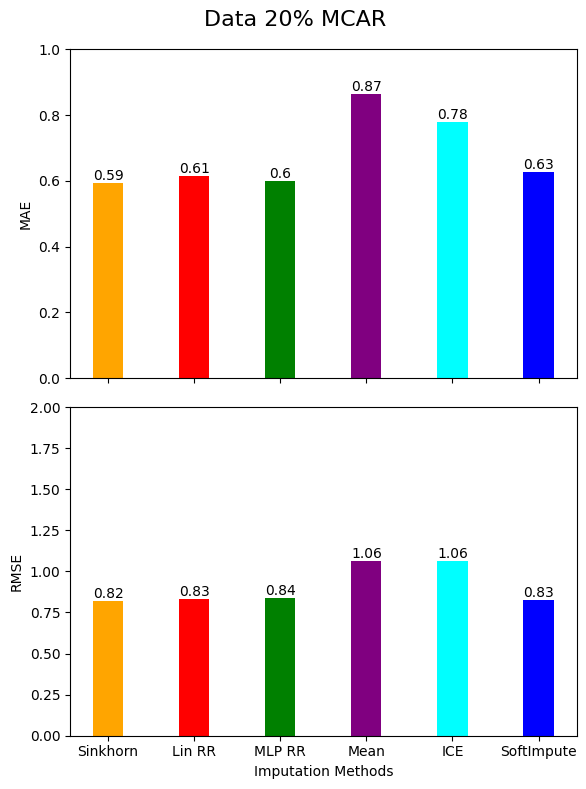

In [ ]:

# Define values and categories
values_mae_mcar20 = [sk_mae_mcar20,lin_rr_mae_mcar20,mlp_rr_mae_mcar20, mean_mae_mcar20, ice_mae_mcar20, soft_mae_mcar20]
values_rmse_mcar20 = [sk_rmse_mcar20,lin_rr_rmse_mcar20,mlp_rr_rmse_mcar20, mean_rmse_mcar20, ice_rmse_mcar20, soft_rmse_mcar20]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 20% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar20, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar20, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


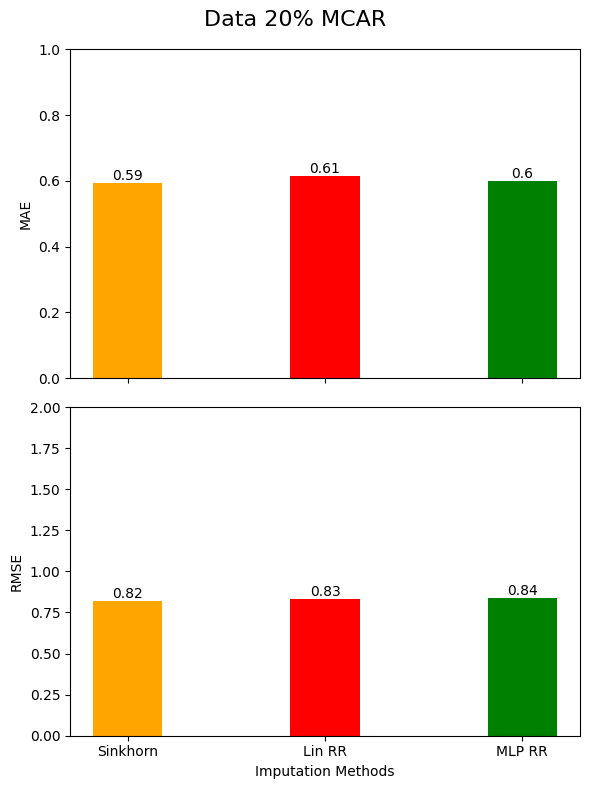

In [ ]:

# Define values and categories
valuesOT_mae_mcar20 = [sk_mae_mcar20,lin_rr_mae_mcar20,mlp_rr_mae_mcar20]
valuesOT_rmse_mcar20 = [sk_rmse_mcar20,lin_rr_rmse_mcar20,mlp_rr_rmse_mcar20]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 20% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar20, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar20, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**25% MCAR**

In [ ]:
#sinkhorn
n_mcar25, d_mcar25 = data_mcar25.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar25 = pick_epsilon(data_mcar25)

print(epsilon_mcar25)

sk_imputer_mcar25 = SinkhornImputation(eps=epsilon_mcar25, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar25, sk_maes25mcar, sk_rmses25mcar = sk_imputer_mcar25.fit_transform(data_mcar25, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar25_numpy = sk_imp_mcar25.detach().cpu().numpy()

sk_mae_mcar25 = MAE(sk_imp_mcar25_numpy,ground_truth_numpy,mask_mcar25)
sk_rmse_mcar25 = RMSE(sk_imp_mcar25_numpy, ground_truth_numpy,mask_mcar25)
print(sk_mae_mcar25,sk_rmse_mcar25)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.4274
INFO:root:Iteration 0:	 Loss: 2.1752	 Validation MAE: 0.8411	RMSE: 1.0429


0.42741291915987206


INFO:root:Iteration 500:	 Loss: 1.5453	 Validation MAE: 0.5839	RMSE: 0.8119
INFO:root:Iteration 1000:	 Loss: 1.6670	 Validation MAE: 0.5947	RMSE: 0.8217
INFO:root:Iteration 1500:	 Loss: 1.2492	 Validation MAE: 0.5978	RMSE: 0.8262


0.592637160795712 0.8280297463489802


In [ ]:
#linear Round Robin
dmcar25_ = d_mcar25 - 1
models_liner_mcar25 = {}

for i in range(d_mcar25):
    models_liner_mcar25[i] = nn.Linear(dmcar25_, 1)

#Create the imputer
lin_rr_imputer_mcar25 = RRimputer(models_liner_mcar25, eps=epsilon_mcar25, lr=lr)
lin_rr_mcar25, lin_maesmcar25, lin_rmsesmcar25 = lin_rr_imputer_mcar25.fit_transform(data_mcar25, verbose=True, X_true=ground_truth)
lin_rr_mcar25_numpy = lin_rr_mcar25.detach().cpu().numpy()

lin_rr_mae_mcar25 = MAE(lin_rr_mcar25_numpy,ground_truth_numpy,mask_mcar25)
lin_rr_rmse_mcar25 = RMSE(lin_rr_mcar25_numpy, ground_truth_numpy,mask_mcar25)
print(lin_rr_mae_mcar25,lin_rr_rmse_mcar25)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.9966	Validation MAE: 0.6719	RMSE:  0.9067
INFO:root:Iteration 1:	 Loss: 2.0337	Validation MAE: 0.6449	RMSE:  0.8734
INFO:root:Iteration 2:	 Loss: 1.8319	Validation MAE: 0.6297	RMSE:  0.8430
INFO:root:Iteration 3:	 Loss: 1.6524	Validation MAE: 0.6210	RMSE:  0.8297
INFO:root:Iteration 4:	 Loss: 1.7514	Validation MAE: 0.6162	RMSE:  0.8221
INFO:root:Iteration 5:	 Loss: 1.8214	Validation MAE: 0.6123	RMSE:  0.8241
INFO:root:Iteration 6:	 Loss: 1.8499	Validation MAE: 0.6089	RMSE:  0.8189
INFO:root:Iteration 7:	 Loss: 1.6857	Validation MAE: 0.6093	RMSE:  0.8230
INFO:root:Iteration 8:	 Loss: 1.7881	Validation MAE: 0.6088	RMSE:  0.8251
INFO:root:Iteration 9:	 Loss: 1.7644	Validation MAE: 0.6119	RMSE:  0.8247
INFO:root:Early stopping criterion not reached


0.6118631340567414 0.8247285904992309


In [ ]:
#MLP Round Robin
dmcar25_ = d_mcar25 - 1
models_mlp_mcar25 = {}


for i in range(d_mcar25):
   models_mlp_mcar25[i] = nn.Sequential(nn.Linear(dmcar25_, 2 * dmcar25_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar25_, dmcar25_),
                              nn.ReLU(),
                              nn.Linear(dmcar25_, 1))

#Create the imputer
mlp_rr_imputer_mcar25 = RRimputer(models_mlp_mcar25, eps=epsilon_mcar25, lr=lr)

mlp_rr_mcar25, mlp_rr_maesmcar25, mlp_rr_rmsesmcar25 = mlp_rr_imputer_mcar25.fit_transform(data_mcar25, verbose=True, X_true=ground_truth)

mlp_rr_mcar25_numpy = mlp_rr_mcar25.detach().cpu().numpy()

mlp_rr_mae_mcar25 = MAE(mlp_rr_mcar25_numpy,ground_truth_numpy,mask_mcar25)
mlp_rr_rmse_mcar25 = RMSE(mlp_rr_mcar25_numpy, ground_truth_numpy,mask_mcar25)
print(mlp_rr_mae_mcar25,mlp_rr_rmse_mcar25)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.


INFO:root:Iteration 0:	 Loss: 1.8538	Validation MAE: 0.6274	RMSE:  0.8709
INFO:root:Iteration 1:	 Loss: 1.8320	Validation MAE: 0.6160	RMSE:  0.8451
INFO:root:Iteration 2:	 Loss: 1.9331	Validation MAE: 0.6059	RMSE:  0.8371
INFO:root:Iteration 3:	 Loss: 1.8386	Validation MAE: 0.5948	RMSE:  0.8280
INFO:root:Iteration 4:	 Loss: 1.6563	Validation MAE: 0.6018	RMSE:  0.8269
INFO:root:Iteration 5:	 Loss: 1.7105	Validation MAE: 0.6088	RMSE:  0.8322
INFO:root:Iteration 6:	 Loss: 1.7222	Validation MAE: 0.6138	RMSE:  0.8394
INFO:root:Iteration 7:	 Loss: 1.7703	Validation MAE: 0.6240	RMSE:  0.8479
INFO:root:Iteration 8:	 Loss: 1.7563	Validation MAE: 0.6180	RMSE:  0.8448
INFO:root:Iteration 9:	 Loss: 1.9556	Validation MAE: 0.6196	RMSE:  0.8472
INFO:root:Early stopping criterion not reached


0.6195974976607591 0.8471960336897614


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar25 = SimpleImputer().fit_transform(data_mcar25_numpy)
mean_mae_mcar25 = MAE(mean_imp_mcar25, ground_truth_numpy, mask_mcar25)
mean_rmse_mcar25= RMSE(mean_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(mean_mae_mcar25, mean_rmse_mcar25)

#ICE
ice_imp_mcar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar25_numpy)
ice_mae_mcar25 = MAE(ice_imp_mcar25, ground_truth_numpy, mask_mcar25)
ice_rmse_mcar25 = RMSE(ice_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(ice_mae_mcar25,ice_rmse_mcar25)

#SoftImpute
cv_error_mcar25, grid_lambda_mcar25 = cv_softimpute(data_mcar25_numpy, grid_len=15)
lbda_mcar25 = grid_lambda_mcar25[np.argmin(cv_error_mcar25)]
soft_imp_mcar25 = softimpute((data_mcar25_numpy), lbda_mcar25)[1]

soft_mae_mcar25 = MAE(soft_imp_mcar25, ground_truth_numpy, mask_mcar25)
soft_rmse_mcar25 = RMSE(soft_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(soft_mae_mcar25,soft_rmse_mcar25)

0.8380681332032784 1.0407542330179316
0.757916902487786 1.0196437356256995
0.6250309293217298 0.8270085139510432


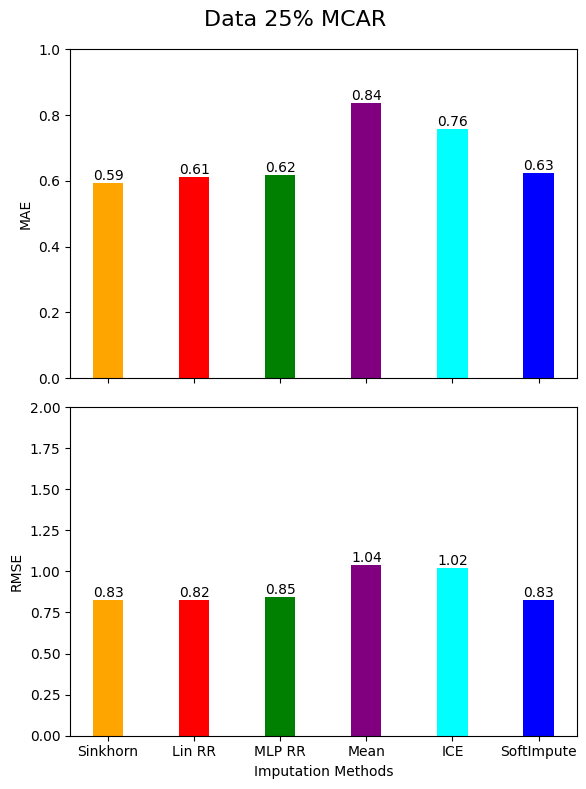

In [ ]:

# Define values and categories
values_mae_mcar25 = [sk_mae_mcar25,lin_rr_mae_mcar25,mlp_rr_mae_mcar25, mean_mae_mcar25, ice_mae_mcar25, soft_mae_mcar25]
values_rmse_mcar25 = [sk_rmse_mcar25,lin_rr_rmse_mcar25,mlp_rr_rmse_mcar25, mean_rmse_mcar25, ice_rmse_mcar25, soft_rmse_mcar25]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar25, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar25, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


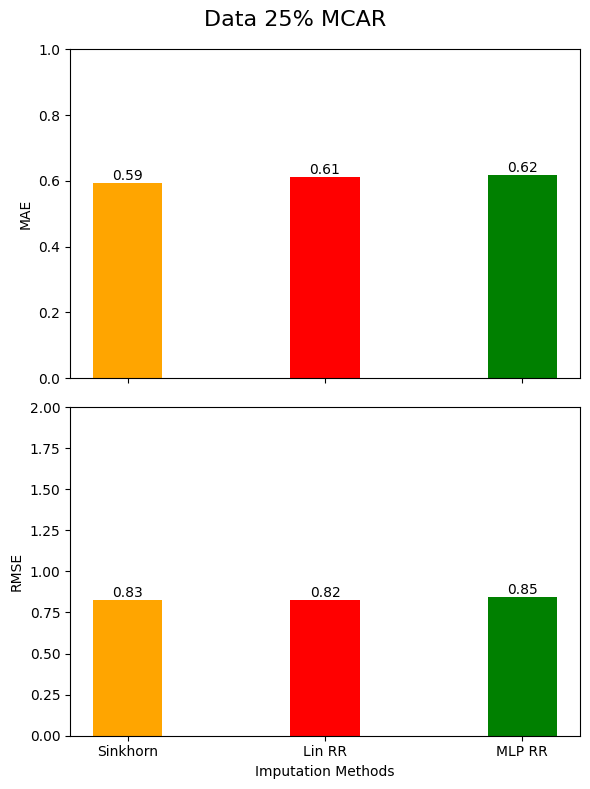

In [ ]:

# Define values and categories
valuesOT_mae_mcar25 = [sk_mae_mcar25,lin_rr_mae_mcar25,mlp_rr_mae_mcar25]
valuesOT_rmse_mcar25 = [sk_rmse_mcar25,lin_rr_rmse_mcar25,mlp_rr_rmse_mcar25]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar25, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar25, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**30% MCAR**

In [ ]:
#sinkhorn
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(data_mcar30)
print(epsilon_mcar30)

sk_imputer_mcar30 = SinkhornImputation(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar = sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.3997
INFO:root:Iteration 0:	 Loss: 2.0040	 Validation MAE: 0.8425	RMSE: 1.0430


0.39971389591590073


INFO:root:Iteration 500:	 Loss: 2.0514	 Validation MAE: 0.5749	RMSE: 0.7944
INFO:root:Iteration 1000:	 Loss: 1.5557	 Validation MAE: 0.5715	RMSE: 0.7949
INFO:root:Iteration 1500:	 Loss: 1.6769	 Validation MAE: 0.5852	RMSE: 0.8072


0.5837110963782504 0.8060424497907205


In [ ]:
#linear Round Robin
dmcar30_ = d_mcar30 - 1
models_liner_mcar30 = {}

for i in range(d_mcar30):
    models_liner_mcar30[i] = nn.Linear(dmcar30_, 1)

#Create the imputer
lin_rr_imputer_mcar30 = RRimputer(models_liner_mcar30, eps=epsilon_mcar30, lr=lr)
lin_rr_mcar30, lin_maesmcar30, lin_rmsesmcar30 = lin_rr_imputer_mcar30.fit_transform(data_mcar30, verbose=True, X_true=ground_truth)
lin_rr_mcar30_numpy = lin_rr_mcar30.detach().cpu().numpy()

lin_rr_mae_mcar30 = MAE(lin_rr_mcar30_numpy,ground_truth_numpy,mask_mcar30)
lin_rr_rmse_mcar30 = RMSE(lin_rr_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(lin_rr_mae_mcar30,lin_rr_rmse_mcar30)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.9623	Validation MAE: 0.6895	RMSE:  0.9164
INFO:root:Iteration 1:	 Loss: 1.7677	Validation MAE: 0.6487	RMSE:  0.8755
INFO:root:Iteration 2:	 Loss: 1.6993	Validation MAE: 0.6317	RMSE:  0.8475
INFO:root:Iteration 3:	 Loss: 1.7638	Validation MAE: 0.6286	RMSE:  0.8495
INFO:root:Iteration 4:	 Loss: 1.6901	Validation MAE: 0.6173	RMSE:  0.8306
INFO:root:Iteration 5:	 Loss: 1.6516	Validation MAE: 0.6143	RMSE:  0.8324
INFO:root:Iteration 6:	 Loss: 1.6885	Validation MAE: 0.6156	RMSE:  0.8296
INFO:root:Iteration 7:	 Loss: 1.6431	Validation MAE: 0.6153	RMSE:  0.8314
INFO:root:Iteration 8:	 Loss: 1.7202	Validation MAE: 0.6141	RMSE:  0.8291
INFO:root:Iteration 9:	 Loss: 1.7710	Validation MAE: 0.6113	RMSE:  0.8290
INFO:root:Early stopping criterion not reached


0.6112631344767447 0.8289756321742308


In [ ]:
#MLP Round Robin
dmcar30_ = d_mcar30 - 1
models_mlp_mcar30 = {}


for i in range(d_mcar30):
   models_mlp_mcar30[i] = nn.Sequential(nn.Linear(dmcar30_, 2 * dmcar30_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar30_, dmcar30_),
                              nn.ReLU(),
                              nn.Linear(dmcar30_, 1))

#Create the imputer
mlp_rr_imputer_mcar30 = RRimputer(models_mlp_mcar30, eps=epsilon_mcar30, lr=lr)

mlp_rr_mcar30, mlp_rr_maesmcar30, mlp_rr_rmsesmcar30 = mlp_rr_imputer_mcar30.fit_transform(data_mcar30, verbose=True, X_true=ground_truth)

mlp_rr_mcar30_numpy = mlp_rr_mcar30.detach().cpu().numpy()

mlp_rr_mae_mcar30 = MAE(mlp_rr_mcar30_numpy,ground_truth_numpy,mask_mcar30)
mlp_rr_rmse_mcar30 = RMSE(mlp_rr_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(mlp_rr_mae_mcar30, mlp_rr_rmse_mcar30)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.8285	Validation MAE: 0.6452	RMSE:  0.8719
INFO:root:Iteration 1:	 Loss: 1.6961	Validation MAE: 0.5954	RMSE:  0.8100
INFO:root:Iteration 2:	 Loss: 1.7190	Validation MAE: 0.5852	RMSE:  0.8043
INFO:root:Iteration 3:	 Loss: 1.6149	Validation MAE: 0.5901	RMSE:  0.8043
INFO:root:Iteration 4:	 Loss: 1.6186	Validation MAE: 0.5839	RMSE:  0.7942
INFO:root:Iteration 5:	 Loss: 1.7205	Validation MAE: 0.5981	RMSE:  0.8168
INFO:root:Iteration 6:	 Loss: 1.9416	Validation MAE: 0.5969	RMSE:  0.8172
INFO:root:Iteration 7:	 Loss: 1.6484	Validation MAE: 0.5941	RMSE:  0.8142
INFO:root:Iteration 8:	 Loss: 1.6119	Validation MAE: 0.5949	RMSE:  0.8143
INFO:root:Iteration 9:	 Loss: 1.8056	Validation MAE: 0.5997	RMSE:  0.8269
INFO:root:Early stopping criterion not reached


0.599733335041335 0.8268905962638251


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar30 = SimpleImputer().fit_transform(data_mcar30_numpy)
mean_mae_mcar30 = MAE(mean_imp_mcar30, ground_truth_numpy, mask_mcar30)
mean_rmse_mcar30= RMSE(mean_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(mean_mae_mcar30, mean_rmse_mcar30)

#ICE
ice_imp_mcar30 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar30_numpy)
ice_mae_mcar30 = MAE(ice_imp_mcar30, ground_truth_numpy, mask_mcar30)
ice_rmse_mcar30 = RMSE(ice_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(ice_mae_mcar30,ice_rmse_mcar30)

#SoftImpute
cv_error_mcar30, grid_lambda_mcar30 = cv_softimpute(data_mcar30_numpy, grid_len=15)
lbda_mcar30 = grid_lambda_mcar30[np.argmin(cv_error_mcar30)]
soft_imp_mcar30 = softimpute((data_mcar30_numpy), lbda_mcar30)[1]

soft_mae_mcar30 = MAE(soft_imp_mcar30, ground_truth_numpy, mask_mcar30)
soft_rmse_mcar30 = RMSE(soft_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(soft_mae_mcar30,soft_rmse_mcar30)

0.8355054414126526 1.0340881947267617
0.730146156061971 0.9823398349392125
0.621637229175994 0.816931987094378


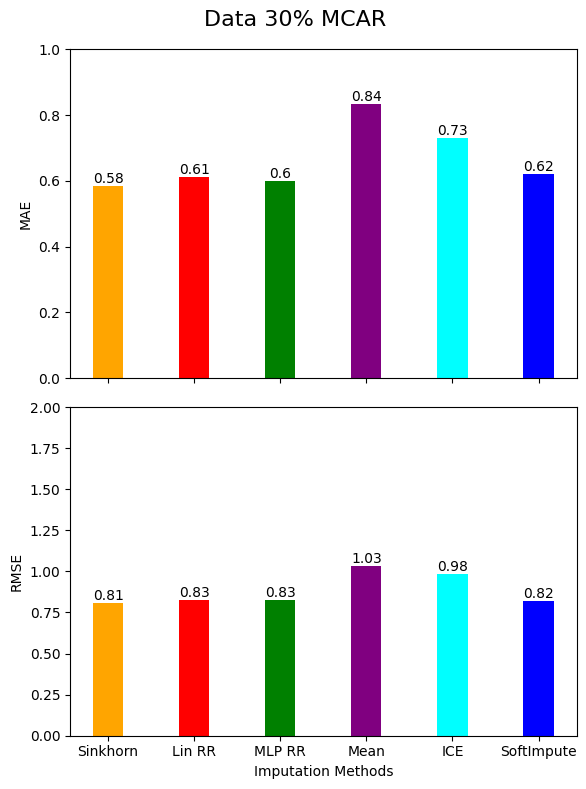

In [ ]:

# Define values and categories
values_mae_mcar30 = [sk_mae_mcar30,lin_rr_mae_mcar30,mlp_rr_mae_mcar30, mean_mae_mcar30, ice_mae_mcar30, soft_mae_mcar30]
values_rmse_mcar30 = [sk_rmse_mcar30,lin_rr_rmse_mcar30,mlp_rr_rmse_mcar30, mean_rmse_mcar30, ice_rmse_mcar30, soft_rmse_mcar30]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 30% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar30, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar30, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


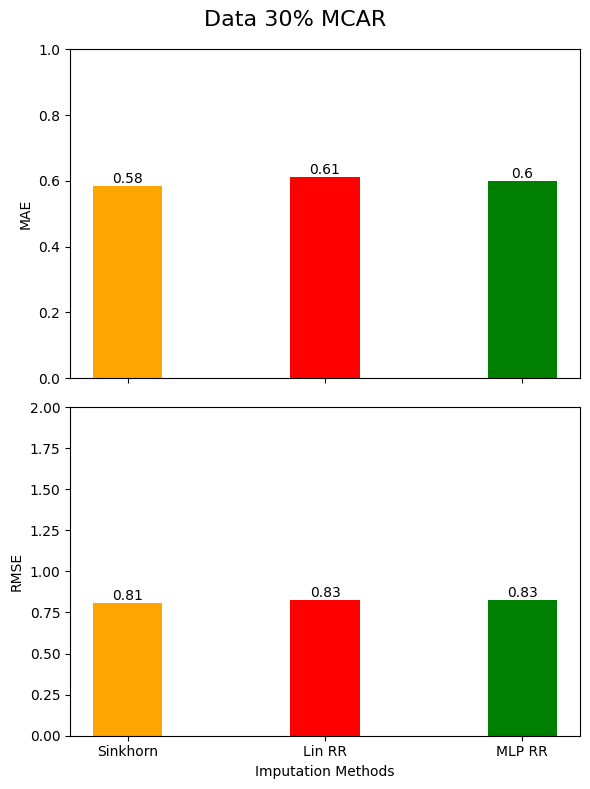

In [ ]:

# Define values and categories
valuesOT_mae_mcar30 = [sk_mae_mcar30,lin_rr_mae_mcar30,mlp_rr_mae_mcar30]
valuesOT_rmse_mcar30 = [sk_rmse_mcar30,lin_rr_rmse_mcar30,mlp_rr_rmse_mcar30]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 30% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar30, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar30, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**35% MCAR**

In [ ]:
#sinkhorn
n_mcar35, d_mcar35 = data_mcar35.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar35 = pick_epsilon(data_mcar35)

print(epsilon_mcar35)

sk_imputer_mcar35 = SinkhornImputation(eps=epsilon_mcar35, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar35, sk_maes35mcar, sk_rmses35mcar = sk_imputer_mcar35.fit_transform(data_mcar35, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar35_numpy = sk_imp_mcar35.detach().cpu().numpy()

sk_mae_mcar35 = MAE(sk_imp_mcar35_numpy,ground_truth_numpy,mask_mcar35)
sk_rmse_mcar35 = RMSE(sk_imp_mcar35_numpy, ground_truth_numpy,mask_mcar35)
print(sk_mae_mcar35,sk_rmse_mcar35)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.3678
INFO:root:Iteration 0:	 Loss: 1.9632	 Validation MAE: 0.8437	RMSE: 1.0411


0.36782423673366615


INFO:root:Iteration 500:	 Loss: 1.6572	 Validation MAE: 0.5849	RMSE: 0.8127
INFO:root:Iteration 1000:	 Loss: 1.4808	 Validation MAE: 0.5805	RMSE: 0.8026
INFO:root:Iteration 1500:	 Loss: 1.4889	 Validation MAE: 0.5756	RMSE: 0.7995


0.5751773528613403 0.7952982510497327


In [ ]:
#linear Round Robin
dmcar35_ = d_mcar35 - 1
models_liner_mcar35 = {}

for i in range(d_mcar35):
    models_liner_mcar35[i] = nn.Linear(dmcar35_, 1)

#Create the imputer
lin_rr_imputer_mcar35 = RRimputer(models_liner_mcar35, eps=epsilon_mcar35, lr=lr)
lin_rr_mcar35, lin_maesmcar35, lin_rmsesmcar35 = lin_rr_imputer_mcar35.fit_transform(data_mcar35, verbose=True, X_true=ground_truth)
lin_rr_mcar35_numpy = lin_rr_mcar35.detach().cpu().numpy()

lin_rr_mae_mcar35 = MAE(lin_rr_mcar35_numpy,ground_truth_numpy ,mask_mcar35)
lin_rr_rmse_mcar35 = RMSE(lin_rr_mcar35_numpy,ground_truth_numpy,mask_mcar35)
print(lin_rr_mae_mcar35,lin_rr_rmse_mcar35)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.8837	Validation MAE: 0.6813	RMSE:  0.9060
INFO:root:Iteration 1:	 Loss: 1.5976	Validation MAE: 0.6384	RMSE:  0.8647
INFO:root:Iteration 2:	 Loss: 1.5802	Validation MAE: 0.6343	RMSE:  0.8610
INFO:root:Iteration 3:	 Loss: 1.6246	Validation MAE: 0.6229	RMSE:  0.8489
INFO:root:Iteration 4:	 Loss: 1.7072	Validation MAE: 0.6199	RMSE:  0.8432
INFO:root:Iteration 5:	 Loss: 1.7285	Validation MAE: 0.6157	RMSE:  0.8387
INFO:root:Iteration 6:	 Loss: 1.5236	Validation MAE: 0.6165	RMSE:  0.8426
INFO:root:Iteration 7:	 Loss: 1.7296	Validation MAE: 0.6169	RMSE:  0.8395
INFO:root:Iteration 8:	 Loss: 1.7083	Validation MAE: 0.6213	RMSE:  0.8474
INFO:root:Iteration 9:	 Loss: 1.5886	Validation MAE: 0.6168	RMSE:  0.8432
INFO:root:Early stopping criterion not reached


0.6168361851983482 0.8431995744008245


In [ ]:
#MLP Round Robin
dmcar35_ = d_mcar35 - 1
models_mlp_mcar35 = {}


for i in range(d_mcar35):
   models_mlp_mcar35[i] = nn.Sequential(nn.Linear(dmcar35_, 2 * dmcar35_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar35_, dmcar35_),
                              nn.ReLU(),
                              nn.Linear(dmcar35_, 1))

#Create the imputer
mlp_rr_imputer_mcar35 = RRimputer(models_mlp_mcar35, eps=epsilon_mcar35, lr=lr)

mlp_rr_mcar35, mlp_rr_maesmcar35, mlp_rr_rmsesmcar35 = mlp_rr_imputer_mcar35.fit_transform(data_mcar35, verbose=True, X_true=ground_truth)

mlp_rr_mcar35_numpy = mlp_rr_mcar35.detach().cpu().numpy()

mlp_rr_mae_mcar35 = MAE(mlp_rr_mcar35_numpy,ground_truth_numpy ,mask_mcar35)
mlp_rr_rmse_mcar35 = RMSE(mlp_rr_mcar35_numpy, ground_truth_numpy,mask_mcar35)
print(mlp_rr_mae_mcar35, mlp_rr_rmse_mcar35)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.


INFO:root:Iteration 0:	 Loss: 1.8002	Validation MAE: 0.6318	RMSE:  0.8667
INFO:root:Iteration 1:	 Loss: 1.5491	Validation MAE: 0.6182	RMSE:  0.8463
INFO:root:Iteration 2:	 Loss: 1.7520	Validation MAE: 0.6052	RMSE:  0.8479
INFO:root:Iteration 3:	 Loss: 1.5529	Validation MAE: 0.6049	RMSE:  0.8441
INFO:root:Iteration 4:	 Loss: 1.4943	Validation MAE: 0.6008	RMSE:  0.8451
INFO:root:Iteration 5:	 Loss: 1.6120	Validation MAE: 0.6134	RMSE:  0.8580
INFO:root:Iteration 6:	 Loss: 1.5479	Validation MAE: 0.6128	RMSE:  0.8613
INFO:root:Iteration 7:	 Loss: 1.5678	Validation MAE: 0.6033	RMSE:  0.8495
INFO:root:Iteration 8:	 Loss: 1.7277	Validation MAE: 0.6030	RMSE:  0.8548
INFO:root:Iteration 9:	 Loss: 1.6264	Validation MAE: 0.5995	RMSE:  0.8442
INFO:root:Early stopping criterion not reached


0.5995356668629318 0.8442386828022633


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar35 = SimpleImputer().fit_transform(data_mcar35_numpy)
mean_mae_mcar35 = MAE(mean_imp_mcar35, ground_truth_numpy, mask_mcar35)
mean_rmse_mcar35 = RMSE(mean_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(mean_mae_mcar35, mean_rmse_mcar35)

#ICE
ice_imp_mcar35 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar35_numpy)
ice_mae_mcar35 = MAE(ice_imp_mcar35, ground_truth_numpy, mask_mcar35)
ice_rmse_mcar35 = RMSE(ice_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(ice_mae_mcar35,ice_rmse_mcar35)

#SoftImpute
cv_error_mcar35, grid_lambda_mcar35 = cv_softimpute(data_mcar35_numpy, grid_len=15)
lbda_mcar35 = grid_lambda_mcar35[np.argmin(cv_error_mcar35)]
soft_imp_mcar35 = softimpute((data_mcar35_numpy), lbda_mcar35)[1]

soft_mae_mcar35 = MAE(soft_imp_mcar35, ground_truth_numpy, mask_mcar35)
soft_rmse_mcar35 = RMSE(soft_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(soft_mae_mcar35,soft_rmse_mcar35)

0.8425161737064246 1.0378023549111859
0.712859196767655 0.9530281117411474
0.637045852351681 0.8335496572111154


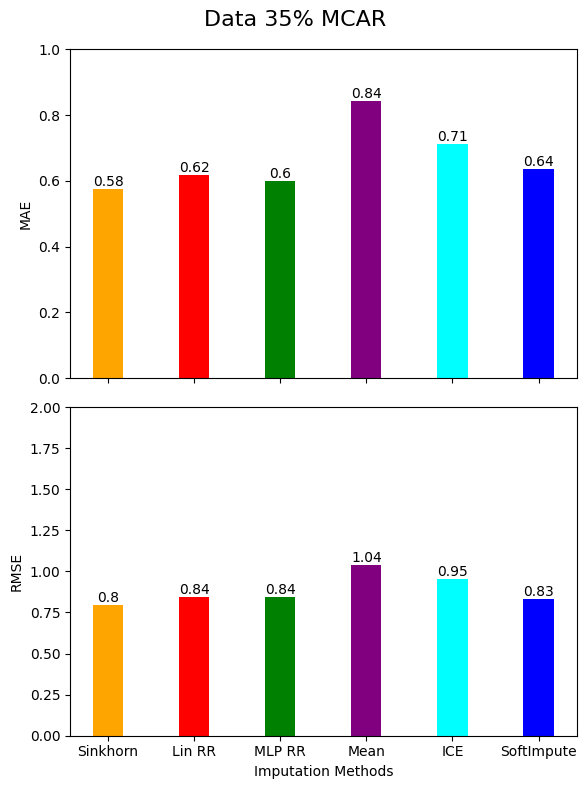

In [ ]:

# Define values and categories
values_mae_mcar35 = [sk_mae_mcar35,lin_rr_mae_mcar35,mlp_rr_mae_mcar35, mean_mae_mcar35, ice_mae_mcar35, soft_mae_mcar35]
values_rmse_mcar35 = [sk_rmse_mcar35, lin_rr_rmse_mcar35, mlp_rr_rmse_mcar35, mean_rmse_mcar35, ice_rmse_mcar35, soft_rmse_mcar35]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 35% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar35, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar35, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


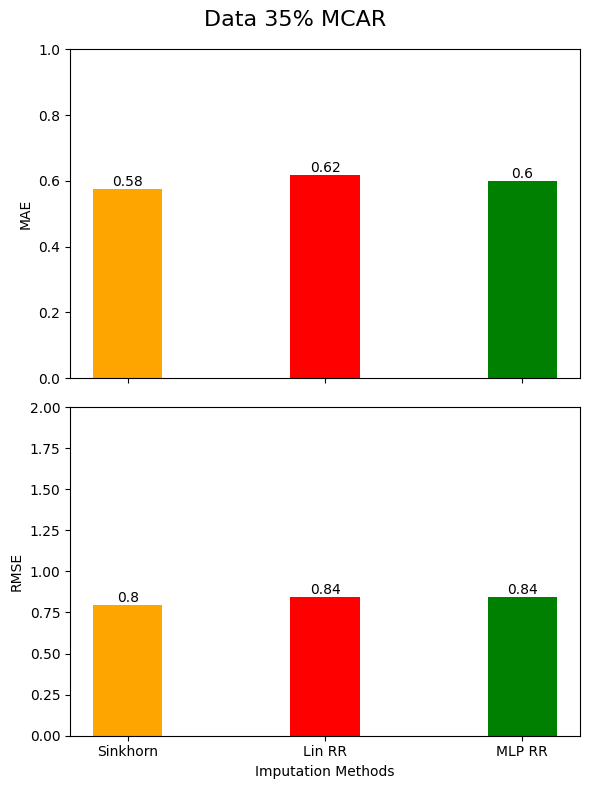

In [ ]:

# Define values and categories
valuesOT_mae_mcar35 = [sk_mae_mcar35,lin_rr_mae_mcar35,mlp_rr_mae_mcar35]
valuesOT_rmse_mcar35 = [sk_rmse_mcar35,lin_rr_rmse_mcar35,mlp_rr_rmse_mcar35]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 35% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar35, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar35, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**40% MCAR**

In [ ]:
#sinkhorn
n_mcar40, d_mcar40 = data_mcar40.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar40 = pick_epsilon(data_mcar40)

print(epsilon_mcar40)

sk_imputer_mcar40 = SinkhornImputation(eps=epsilon_mcar40, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar40, sk_maes40mcar, sk_rmses40mcar = sk_imputer_mcar40.fit_transform(data_mcar40, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar40_numpy = sk_imp_mcar40.detach().cpu().numpy()

sk_mae_mcar40 = MAE(sk_imp_mcar40_numpy,ground_truth_numpy ,mask_mcar40)
sk_rmse_mcar40 = RMSE(sk_imp_mcar40_numpy, ground_truth_numpy,mask_mcar40)
print(sk_mae_mcar40,sk_rmse_mcar40)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.3405
INFO:root:Iteration 0:	 Loss: 2.1543	 Validation MAE: 0.8454	RMSE: 1.0391


0.3404503318822011


INFO:root:Iteration 500:	 Loss: 1.2268	 Validation MAE: 0.5928	RMSE: 0.8209
INFO:root:Iteration 1000:	 Loss: 1.3983	 Validation MAE: 0.5931	RMSE: 0.8206
INFO:root:Iteration 1500:	 Loss: 1.8330	 Validation MAE: 0.6026	RMSE: 0.8348


0.6033838731336393 0.8328575832459458


In [ ]:
#linear Round Robin
dmcar40_ = d_mcar40 - 1
models_liner_mcar40 = {}

for i in range(d_mcar40):
    models_liner_mcar40[i] = nn.Linear(dmcar40_, 1)

#Create the imputer
lin_rr_imputer_mcar40 = RRimputer(models_liner_mcar40, eps=epsilon_mcar40, lr=lr)
lin_rr_mcar40, lin_maesmcar40, lin_rmsesmcar40 = lin_rr_imputer_mcar40.fit_transform(data_mcar40, verbose=True, X_true=ground_truth)
lin_rr_mcar40_numpy = lin_rr_mcar40.detach().cpu().numpy()

lin_rr_mae_mcar40 = MAE(lin_rr_mcar40_numpy,ground_truth_numpy ,mask_mcar40)
lin_rr_rmse_mcar40 = RMSE(lin_rr_mcar40_numpy, ground_truth_numpy,mask_mcar40)
print(lin_rr_mae_mcar40,lin_rr_rmse_mcar40)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.6703	Validation MAE: 0.7351	RMSE:  0.9504
INFO:root:Iteration 1:	 Loss: 1.7763	Validation MAE: 0.6670	RMSE:  0.8919
INFO:root:Iteration 2:	 Loss: 1.7217	Validation MAE: 0.6505	RMSE:  0.8756
INFO:root:Iteration 3:	 Loss: 1.5726	Validation MAE: 0.6471	RMSE:  0.8684
INFO:root:Iteration 4:	 Loss: 1.5890	Validation MAE: 0.6387	RMSE:  0.8632
INFO:root:Iteration 5:	 Loss: 1.5439	Validation MAE: 0.6336	RMSE:  0.8559
INFO:root:Iteration 6:	 Loss: 1.5249	Validation MAE: 0.6320	RMSE:  0.8553
INFO:root:Iteration 7:	 Loss: 1.4791	Validation MAE: 0.6272	RMSE:  0.8519
INFO:root:Iteration 8:	 Loss: 1.6632	Validation MAE: 0.6285	RMSE:  0.8540
INFO:root:Iteration 9:	 Loss: 1.5160	Validation MAE: 0.6321	RMSE:  0.8582
INFO:root:Early stopping criterion not reached


0.6320915259456964 0.8582367447470273


In [ ]:
#MLP Round Robin
dmcar40_ = d_mcar40 - 1
models_mlp_mcar40 = {}


for i in range(d_mcar40):
   models_mlp_mcar40[i] = nn.Sequential(nn.Linear(dmcar40_, 2 * dmcar40_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar40_, dmcar40_),
                              nn.ReLU(),
                              nn.Linear(dmcar40_, 1))

#Create the imputer
mlp_rr_imputer_mcar40 = RRimputer(models_mlp_mcar40, eps=epsilon_mcar40, lr=lr)

mlp_rr_mcar40, mlp_rr_maesmcar40, mlp_rr_rmsesmcar40 = mlp_rr_imputer_mcar40.fit_transform(data_mcar40, verbose=True, X_true=ground_truth)

mlp_rr_mcar40_numpy = mlp_rr_mcar40.detach().cpu().numpy()

mlp_rr_mae_mcar40 = MAE(mlp_rr_mcar40_numpy,ground_truth_numpy ,mask_mcar40)
mlp_rr_rmse_mcar40 = RMSE(mlp_rr_mcar40_numpy, ground_truth_numpy,mask_mcar40)
print(mlp_rr_mae_mcar40, mlp_rr_rmse_mcar40)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.6257	Validation MAE: 0.6379	RMSE:  0.8549
INFO:root:Iteration 1:	 Loss: 1.6798	Validation MAE: 0.6137	RMSE:  0.8412
INFO:root:Iteration 2:	 Loss: 1.6842	Validation MAE: 0.6072	RMSE:  0.8397
INFO:root:Iteration 3:	 Loss: 1.4760	Validation MAE: 0.6009	RMSE:  0.8294
INFO:root:Iteration 4:	 Loss: 1.7169	Validation MAE: 0.6034	RMSE:  0.8315
INFO:root:Iteration 5:	 Loss: 1.5587	Validation MAE: 0.6054	RMSE:  0.8372
INFO:root:Iteration 6:	 Loss: 1.5235	Validation MAE: 0.6018	RMSE:  0.8403
INFO:root:Iteration 7:	 Loss: 1.4885	Validation MAE: 0.6075	RMSE:  0.8487
INFO:root:Iteration 8:	 Loss: 1.3791	Validation MAE: 0.6152	RMSE:  0.8593
INFO:root:Iteration 9:	 Loss: 1.6058	Validation MAE: 0.6203	RMSE:  0.8667
INFO:root:Early stopping criterion not reached


0.6203047456137032 0.8667333245682919


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar40 = SimpleImputer().fit_transform(data_mcar40_numpy)
mean_mae_mcar40 = MAE(mean_imp_mcar40, ground_truth_numpy, mask_mcar40)
mean_rmse_mcar40= RMSE(mean_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(mean_mae_mcar40, mean_rmse_mcar40)

#ICE
ice_imp_mcar40 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar40_numpy)
ice_mae_mcar40 = MAE(ice_imp_mcar40, ground_truth_numpy, mask_mcar40)
ice_rmse_mcar40 = RMSE(ice_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(ice_mae_mcar40,ice_rmse_mcar40)

#SoftImpute
cv_error_mcar40, grid_lambda_mcar40 = cv_softimpute(data_mcar40_numpy, grid_len=15)
lbda_mcar40 = grid_lambda_mcar40[np.argmin(cv_error_mcar40)]
soft_imp_mcar40 = softimpute((data_mcar40_numpy), lbda_mcar40)[1]

soft_mae_mcar40 = MAE(soft_imp_mcar40, ground_truth_numpy, mask_mcar40)
soft_rmse_mcar40 = RMSE(soft_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(soft_mae_mcar40,soft_rmse_mcar40)

0.8395472564955967 1.0324029208694951
0.6825227361630083 0.9064261482586231
0.638350907161685 0.8387585940749349


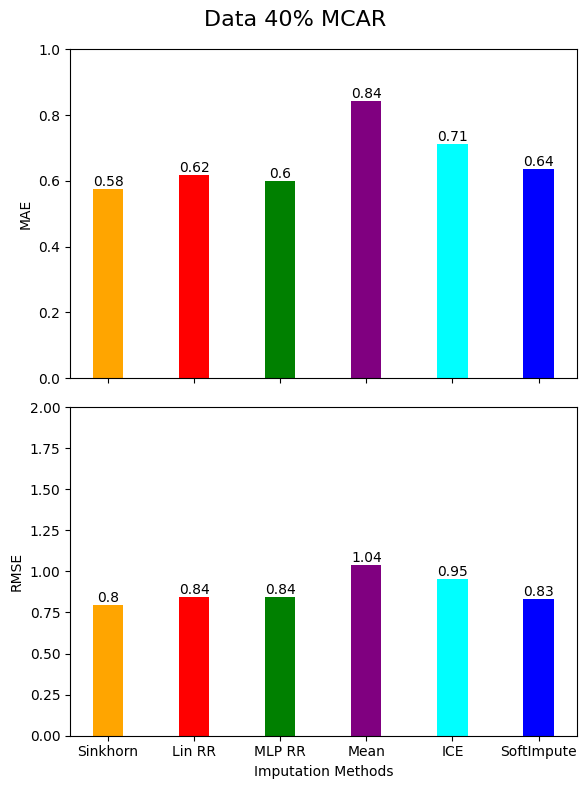

In [ ]:

# Define values and categories
values_mae_mcar40 = [sk_mae_mcar40,lin_rr_mae_mcar40,mlp_rr_mae_mcar40, mean_mae_mcar40, ice_mae_mcar40, soft_mae_mcar40]
values_rmse_mcar40 = [sk_rmse_mcar40, lin_rr_rmse_mcar40, mlp_rr_rmse_mcar40, mean_rmse_mcar40, ice_rmse_mcar40, soft_rmse_mcar40]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 40% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar35, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar35, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


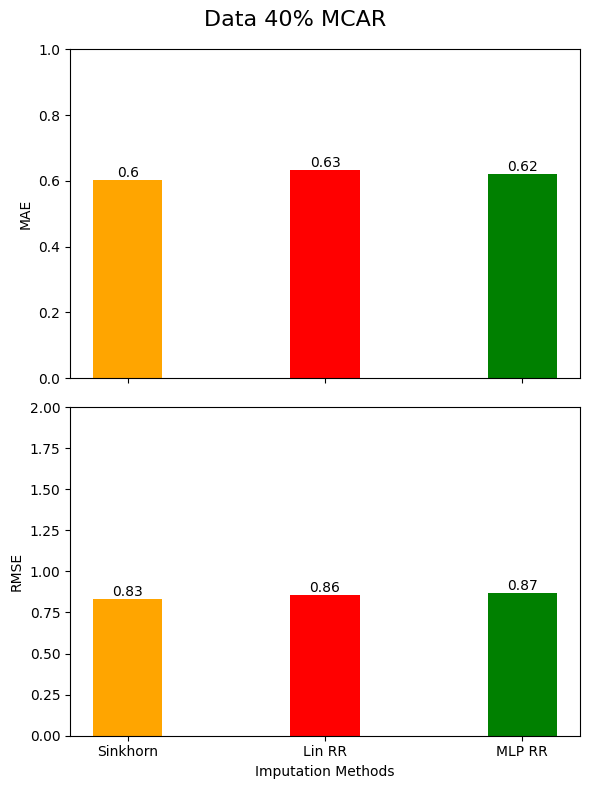

In [ ]:

# Define values and categories
valuesOT_mae_mcar40 = [sk_mae_mcar40,lin_rr_mae_mcar40,mlp_rr_mae_mcar40]
valuesOT_rmse_mcar40 = [sk_rmse_mcar40,lin_rr_rmse_mcar40,mlp_rr_rmse_mcar40]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 40% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar40, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar40, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**45% MCAR**

In [ ]:
#sinkhorn
n_mcar45, d_mcar45 = data_mcar45.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar45 = pick_epsilon(data_mcar45)

print(epsilon_mcar45)

sk_imputer_mcar45 = SinkhornImputation(eps=epsilon_mcar45, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar45, sk_maes45mcar, sk_rmses45mcar = sk_imputer_mcar45.fit_transform(data_mcar45, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar45_numpy = sk_imp_mcar45.detach().cpu().numpy()

sk_mae_mcar45 = MAE(sk_imp_mcar45_numpy,ground_truth_numpy ,mask_mcar45)
sk_rmse_mcar45 = RMSE(sk_imp_mcar45_numpy, ground_truth_numpy,mask_mcar45)
print(sk_mae_mcar45,sk_rmse_mcar45)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.3053
INFO:root:Iteration 0:	 Loss: 1.7423	 Validation MAE: 0.8559	RMSE: 1.0461


0.30531311342976486


INFO:root:Iteration 500:	 Loss: 1.4751	 Validation MAE: 0.6284	RMSE: 0.8616
INFO:root:Iteration 1000:	 Loss: 1.2297	 Validation MAE: 0.6255	RMSE: 0.8608
INFO:root:Iteration 1500:	 Loss: 1.1424	 Validation MAE: 0.6297	RMSE: 0.8672


0.626277330555017 0.8693239856088435


In [ ]:
#linear Round Robin
dmcar45_ = d_mcar45 - 1
models_liner_mcar45 = {}

for i in range(d_mcar45):
    models_liner_mcar45[i] = nn.Linear(dmcar45_, 1)

#Create the imputer
lin_rr_imputer_mcar45 = RRimputer(models_liner_mcar45, eps=epsilon_mcar45, lr=lr)
lin_rr_mcar45, lin_maesmcar45, lin_rmsesmcar45 = lin_rr_imputer_mcar45.fit_transform(data_mcar45, verbose=True, X_true=ground_truth)
lin_rr_mcar45_numpy = lin_rr_mcar45.detach().cpu().numpy()

lin_rr_mae_mcar45 = MAE(lin_rr_mcar45_numpy,ground_truth_numpy ,mask_mcar45)
lin_rr_rmse_mcar45 = RMSE(lin_rr_mcar45_numpy, ground_truth_numpy,mask_mcar45)
print(lin_rr_mae_mcar45,lin_rr_rmse_mcar45)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.8638	Validation MAE: 0.7254	RMSE:  0.9420
INFO:root:Iteration 1:	 Loss: 1.4820	Validation MAE: 0.6716	RMSE:  0.8978
INFO:root:Iteration 2:	 Loss: 1.5704	Validation MAE: 0.6610	RMSE:  0.8928
INFO:root:Iteration 3:	 Loss: 1.8495	Validation MAE: 0.6484	RMSE:  0.8783
INFO:root:Iteration 4:	 Loss: 1.5550	Validation MAE: 0.6452	RMSE:  0.8747
INFO:root:Iteration 5:	 Loss: 1.4249	Validation MAE: 0.6426	RMSE:  0.8725
INFO:root:Iteration 6:	 Loss: 1.3732	Validation MAE: 0.6424	RMSE:  0.8723
INFO:root:Iteration 7:	 Loss: 1.5746	Validation MAE: 0.6441	RMSE:  0.8762
INFO:root:Iteration 8:	 Loss: 1.3494	Validation MAE: 0.6396	RMSE:  0.8707
INFO:root:Iteration 9:	 Loss: 1.4357	Validation MAE: 0.6425	RMSE:  0.8759
INFO:root:Early stopping criterion not reached


0.6425485026685352 0.8758617427928658


In [ ]:
#MLP Round Robin
dmcar45_ = d_mcar45 - 1
models_mlp_mcar45 = {}


for i in range(d_mcar45):
   models_mlp_mcar45[i] = nn.Sequential(nn.Linear(dmcar45_, 2 * dmcar45_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar45_, dmcar45_),
                              nn.ReLU(),
                              nn.Linear(dmcar45_, 1))

#Create the imputer
mlp_rr_imputer_mcar45 = RRimputer(models_mlp_mcar45, eps=epsilon_mcar45, lr=lr)

mlp_rr_mcar45, mlp_rr_maesmcar45, mlp_rr_rmsesmcar45 = mlp_rr_imputer_mcar45.fit_transform(data_mcar45, verbose=True, X_true=ground_truth)

mlp_rr_mcar45_numpy = mlp_rr_mcar45.detach().cpu().numpy()

mlp_rr_mae_mcar45 = MAE(mlp_rr_mcar45_numpy,ground_truth_numpy ,mask_mcar45)
mlp_rr_rmse_mcar45 = RMSE(mlp_rr_mcar45_numpy, ground_truth_numpy,mask_mcar45)
print(mlp_rr_mae_mcar45, mlp_rr_rmse_mcar45)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.4531	Validation MAE: 0.6657	RMSE:  0.8960
INFO:root:Iteration 1:	 Loss: 1.3480	Validation MAE: 0.6352	RMSE:  0.8552
INFO:root:Iteration 2:	 Loss: 1.2803	Validation MAE: 0.6274	RMSE:  0.8594
INFO:root:Iteration 3:	 Loss: 1.3808	Validation MAE: 0.6293	RMSE:  0.8715
INFO:root:Iteration 4:	 Loss: 1.2842	Validation MAE: 0.6335	RMSE:  0.8727
INFO:root:Iteration 5:	 Loss: 1.3248	Validation MAE: 0.6305	RMSE:  0.8750
INFO:root:Iteration 6:	 Loss: 1.4294	Validation MAE: 0.6333	RMSE:  0.8848
INFO:root:Iteration 7:	 Loss: 1.3257	Validation MAE: 0.6370	RMSE:  0.8885
INFO:root:Iteration 8:	 Loss: 1.3974	Validation MAE: 0.6345	RMSE:  0.8822
INFO:root:Iteration 9:	 Loss: 1.6278	Validation MAE: 0.6358	RMSE:  0.8838
INFO:root:Early stopping criterion not reached


0.635793876909329 0.8837898521002309


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar45 = SimpleImputer().fit_transform(data_mcar45_numpy)
mean_mae_mcar45 = MAE(mean_imp_mcar45, ground_truth_numpy, mask_mcar45)
mean_rmse_mcar45= RMSE(mean_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(mean_mae_mcar45, mean_rmse_mcar45)

#ICE
ice_imp_mcar45 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar45_numpy)
ice_mae_mcar45 = MAE(ice_imp_mcar45, ground_truth_numpy, mask_mcar45)
ice_rmse_mcar45 = RMSE(ice_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(ice_mae_mcar45,ice_rmse_mcar45)

#SoftImpute
cv_error_mcar45, grid_lambda_mcar45 = cv_softimpute(data_mcar45_numpy, grid_len=15)
lbda_mcar45 = grid_lambda_mcar45[np.argmin(cv_error_mcar45)]
soft_imp_mcar45 = softimpute((data_mcar45_numpy), lbda_mcar45)[1]

soft_mae_mcar45 = MAE(soft_imp_mcar45, ground_truth_numpy, mask_mcar45)
soft_rmse_mcar45 = RMSE(soft_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(soft_mae_mcar45,soft_rmse_mcar45)

0.8518129262321886 1.043633882738897
0.6981708373069222 0.9102727448946625
0.653255964126088 0.8564712570588483


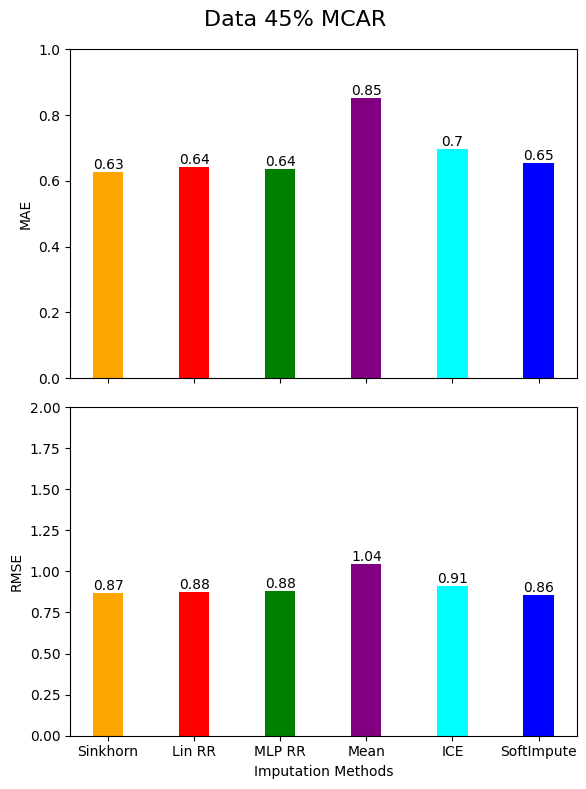

In [ ]:

# Define values and categories
values_mae_mcar45 = [sk_mae_mcar45,lin_rr_mae_mcar45,mlp_rr_mae_mcar45, mean_mae_mcar45, ice_mae_mcar45, soft_mae_mcar45]
values_rmse_mcar45 = [sk_rmse_mcar45, lin_rr_rmse_mcar45, mlp_rr_rmse_mcar45, mean_rmse_mcar45, ice_rmse_mcar45, soft_rmse_mcar45]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 45% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar45, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar45, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


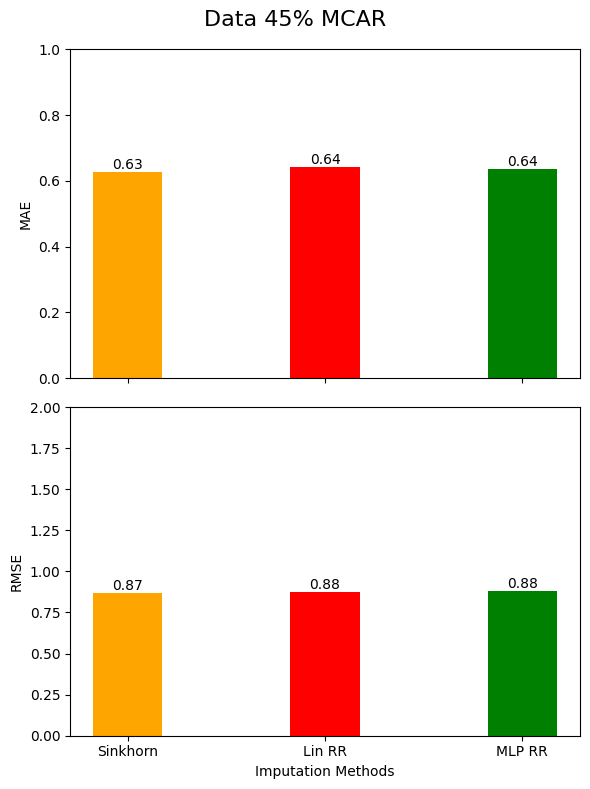

In [ ]:

# Define values and categories
valuesOT_mae_mcar45 = [sk_mae_mcar45,lin_rr_mae_mcar45,mlp_rr_mae_mcar45]
valuesOT_rmse_mcar45 = [sk_rmse_mcar45,lin_rr_rmse_mcar45,mlp_rr_rmse_mcar45]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 45% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar45, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar45, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**50% MCAR**

In [ ]:
#sinkhorn
n_mcar50, d_mcar50 = data_mcar50.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar50 = pick_epsilon(data_mcar50)

print(epsilon_mcar50)

sk_imputer_mcar50 = SinkhornImputation(eps=epsilon_mcar50, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar50, sk_maes50mcar, sk_rmses50mcar = sk_imputer_mcar50.fit_transform(data_mcar50, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar50_numpy = sk_imp_mcar50.detach().cpu().numpy()

sk_mae_mcar50 = MAE(sk_imp_mcar50_numpy,ground_truth_numpy ,mask_mcar50)
sk_rmse_mcar50 = RMSE(sk_imp_mcar50_numpy, ground_truth_numpy,mask_mcar50)
print(sk_mae_mcar50,sk_rmse_mcar50)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.2697
INFO:root:Iteration 0:	 Loss: 1.6171	 Validation MAE: 0.8604	RMSE: 1.0536


0.26968206468630135


INFO:root:Iteration 500:	 Loss: 1.3291	 Validation MAE: 0.6413	RMSE: 0.8743
INFO:root:Iteration 1000:	 Loss: 0.9777	 Validation MAE: 0.6357	RMSE: 0.8766
INFO:root:Iteration 1500:	 Loss: 1.0180	 Validation MAE: 0.6449	RMSE: 0.8897


0.6494309431599918 0.8923193202535389


In [ ]:
#linear Round Robin
dmcar50_ = d_mcar50 - 1
models_liner_mcar50 = {}

for i in range(d_mcar50):
    models_liner_mcar50[i] = nn.Linear(dmcar50_, 1)

#Create the imputer
lin_rr_imputer_mcar50 = RRimputer(models_liner_mcar50, eps=epsilon_mcar50, lr=lr)
lin_rr_mcar50, lin_maesmcar50, lin_rmsesmcar50 = lin_rr_imputer_mcar50.fit_transform(data_mcar50, verbose=True, X_true=ground_truth)
lin_rr_mcar50_numpy = lin_rr_mcar50.detach().cpu().numpy()

lin_rr_mae_mcar50 = MAE(lin_rr_mcar50_numpy,ground_truth_numpy ,mask_mcar50)
lin_rr_rmse_mcar50 = RMSE(lin_rr_mcar50_numpy, ground_truth_numpy,mask_mcar50)
print(lin_rr_mae_mcar50,lin_rr_rmse_mcar50)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.4214	Validation MAE: 0.6918	RMSE:  0.9140
INFO:root:Iteration 1:	 Loss: 1.3513	Validation MAE: 0.6652	RMSE:  0.8903
INFO:root:Iteration 2:	 Loss: 1.7437	Validation MAE: 0.6606	RMSE:  0.8858
INFO:root:Iteration 3:	 Loss: 1.3116	Validation MAE: 0.6539	RMSE:  0.8816
INFO:root:Iteration 4:	 Loss: 1.3424	Validation MAE: 0.6562	RMSE:  0.8859
INFO:root:Iteration 5:	 Loss: 1.5746	Validation MAE: 0.6586	RMSE:  0.8882
INFO:root:Iteration 6:	 Loss: 1.2819	Validation MAE: 0.6633	RMSE:  0.8933
INFO:root:Iteration 7:	 Loss: 1.3512	Validation MAE: 0.6593	RMSE:  0.8873
INFO:root:Iteration 8:	 Loss: 1.2464	Validation MAE: 0.6628	RMSE:  0.8905
INFO:root:Iteration 9:	 Loss: 1.3593	Validation MAE: 0.6639	RMSE:  0.8900
INFO:root:Early stopping criterion not reached


0.663945387337663 0.8899977678440617


In [ ]:
#MLP Round Robin
dmcar50_ = d_mcar50 - 1
models_mlp_mcar50 = {}


for i in range(d_mcar50):
   models_mlp_mcar50[i] = nn.Sequential(nn.Linear(dmcar50_, 2 * dmcar50_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar50_, dmcar50_),
                              nn.ReLU(),
                              nn.Linear(dmcar50_, 1))

#Create the imputer
mlp_rr_imputer_mcar50 = RRimputer(models_mlp_mcar50, eps=epsilon_mcar50, lr=lr)

mlp_rr_mcar50, mlp_rr_maesmcar50, mlp_rr_rmsesmcar50 = mlp_rr_imputer_mcar50.fit_transform(data_mcar50, verbose=True, X_true=ground_truth)

mlp_rr_mcar50_numpy = mlp_rr_mcar50.detach().cpu().numpy()

mlp_rr_mae_mcar50 = MAE(mlp_rr_mcar50_numpy,ground_truth_numpy ,mask_mcar50)
mlp_rr_rmse_mcar50 = RMSE(mlp_rr_mcar50_numpy, ground_truth_numpy,mask_mcar50)
print(mlp_rr_mae_mcar50, mlp_rr_rmse_mcar50)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.3048	Validation MAE: 0.6765	RMSE:  0.8997
INFO:root:Iteration 1:	 Loss: 1.3542	Validation MAE: 0.6380	RMSE:  0.8717
INFO:root:Iteration 2:	 Loss: 1.3579	Validation MAE: 0.6541	RMSE:  0.8849
INFO:root:Iteration 3:	 Loss: 1.2912	Validation MAE: 0.6479	RMSE:  0.8903
INFO:root:Iteration 4:	 Loss: 1.2017	Validation MAE: 0.6548	RMSE:  0.8982
INFO:root:Iteration 5:	 Loss: 1.2514	Validation MAE: 0.6636	RMSE:  0.9104
INFO:root:Iteration 6:	 Loss: 1.1809	Validation MAE: 0.6689	RMSE:  0.9132
INFO:root:Iteration 7:	 Loss: 1.3477	Validation MAE: 0.6819	RMSE:  0.9257
INFO:root:Iteration 8:	 Loss: 1.2822	Validation MAE: 0.6841	RMSE:  0.9245
INFO:root:Iteration 9:	 Loss: 1.5973	Validation MAE: 0.6853	RMSE:  0.9240
INFO:root:Early stopping criterion not reached


0.6853205217418414 0.9240334615848252


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar50 = SimpleImputer().fit_transform(data_mcar50_numpy)
mean_mae_mcar50 = MAE(mean_imp_mcar50, ground_truth_numpy, mask_mcar50)
mean_rmse_mcar50= RMSE(mean_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(mean_mae_mcar50, mean_rmse_mcar50)

#ICE
ice_imp_mcar50 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar50_numpy)
ice_mae_mcar50 = MAE(ice_imp_mcar50, ground_truth_numpy, mask_mcar50)
ice_rmse_mcar50 = RMSE(ice_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(ice_mae_mcar50,ice_rmse_mcar50)

#SoftImpute
cv_error_mcar50, grid_lambda_mcar50 = cv_softimpute(data_mcar50_numpy, grid_len=15)
lbda_mcar50 = grid_lambda_mcar50[np.argmin(cv_error_mcar50)]
soft_imp_mcar50 = softimpute((data_mcar50_numpy), lbda_mcar50)[1]

soft_mae_mcar50 = MAE(soft_imp_mcar50, ground_truth_numpy, mask_mcar50)
soft_rmse_mcar50 = RMSE(soft_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(soft_mae_mcar50,soft_rmse_mcar50)

0.8576462061308137 1.0508945620340129
0.7182849234578299 0.9322036866830374
0.6678373907742787 0.8678216947653806


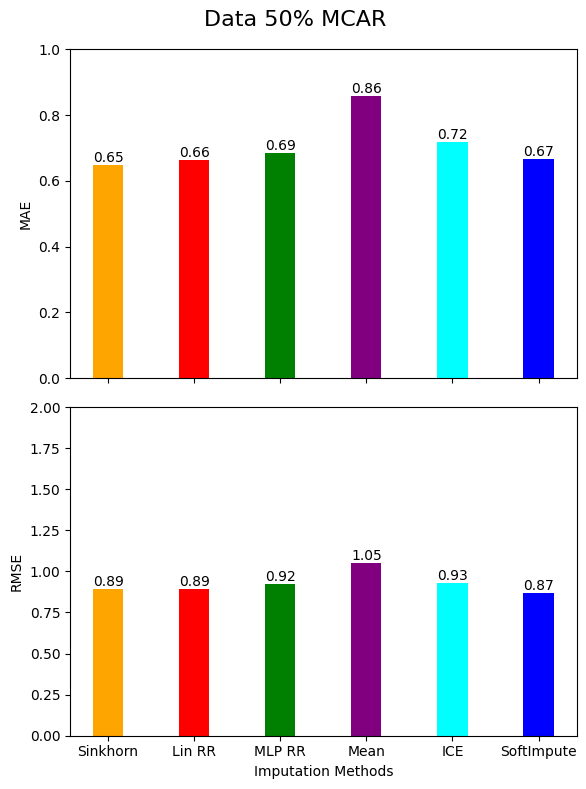

In [ ]:

# Define values and categories
values_mae_mcar50 = [sk_mae_mcar50,lin_rr_mae_mcar50,mlp_rr_mae_mcar50, mean_mae_mcar50, ice_mae_mcar50, soft_mae_mcar50]
values_rmse_mcar50 = [sk_rmse_mcar50, lin_rr_rmse_mcar50, mlp_rr_rmse_mcar50, mean_rmse_mcar50, ice_rmse_mcar50, soft_rmse_mcar50]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 50% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar50, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar50, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


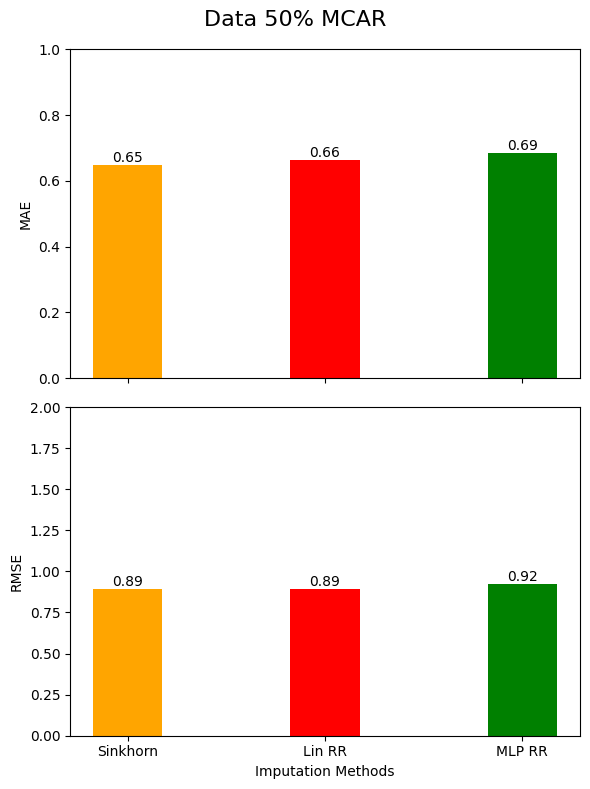

In [ ]:

# Define values and categories
valuesOT_mae_mcar50 = [sk_mae_mcar50,lin_rr_mae_mcar50,mlp_rr_mae_mcar50]
valuesOT_rmse_mcar50 = [sk_rmse_mcar50,lin_rr_rmse_mcar50,mlp_rr_rmse_mcar50]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 50% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar50, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar50, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


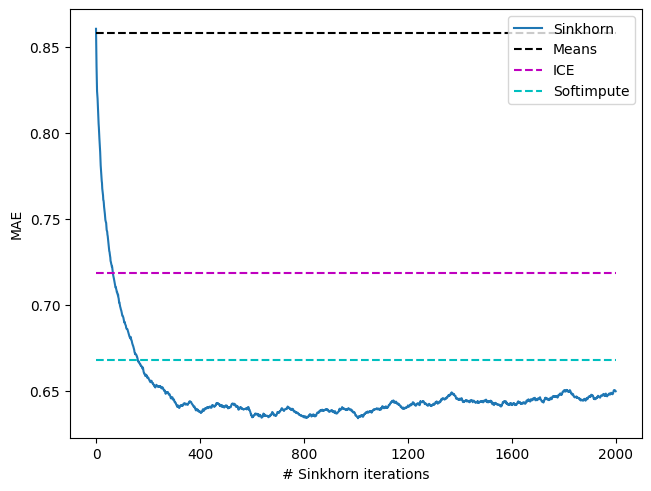

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes50mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes50mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar50, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar50, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar50, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

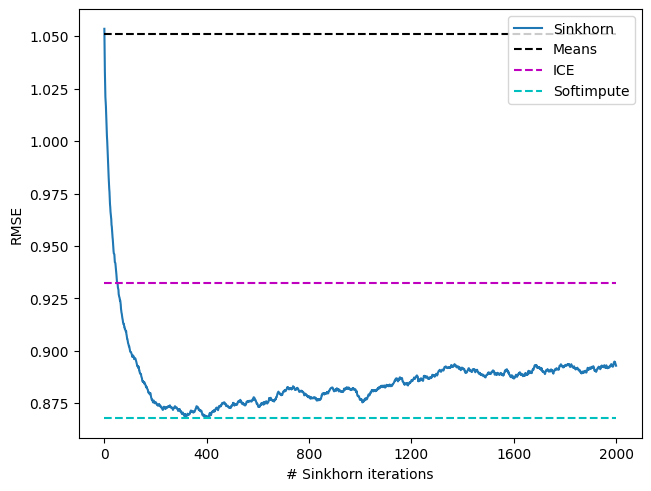

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses50mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses50mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar50, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar50, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar50, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

60% MCAR

In [ ]:
#sinkhorn
n_mcar60, d_mcar60 = data_mcar60.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar60 = pick_epsilon(data_mcar60)

print(epsilon_mcar60)

sk_imputer_mcar60 = SinkhornImputation(eps=epsilon_mcar60, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar60, sk_maes60mcar, sk_rmses60mcar = sk_imputer_mcar60.fit_transform(data_mcar60, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar60_numpy = sk_imp_mcar60.detach().cpu().numpy()

sk_mae_mcar60 = MAE(sk_imp_mcar60_numpy,ground_truth_numpy ,mask_mcar60)
sk_rmse_mcar60 = RMSE(sk_imp_mcar60_numpy, ground_truth_numpy,mask_mcar60)
print(sk_mae_mcar60,sk_rmse_mcar60)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.2113
INFO:root:Iteration 0:	 Loss: 1.3058	 Validation MAE: 0.8615	RMSE: 1.0536


0.21132574129756435


INFO:root:Iteration 500:	 Loss: 0.7993	 Validation MAE: 0.6756	RMSE: 0.8974
INFO:root:Iteration 1000:	 Loss: 0.7300	 Validation MAE: 0.6741	RMSE: 0.9063
INFO:root:Iteration 1500:	 Loss: 0.7269	 Validation MAE: 0.6747	RMSE: 0.9065


0.6773649994421617 0.9067828600790085


In [ ]:
#linear Round Robin
dmcar60_ = d_mcar60 - 1
models_liner_mcar60 = {}

for i in range(d_mcar60):
    models_liner_mcar60[i] = nn.Linear(dmcar60_, 1)

#Create the imputer
lin_rr_imputer_mcar60 = RRimputer(models_liner_mcar60, eps=epsilon_mcar60, lr=lr)
lin_rr_mcar60, lin_maesmcar60, lin_rmsesmcar60 = lin_rr_imputer_mcar60.fit_transform(data_mcar60, verbose=True, X_true=ground_truth)
lin_rr_mcar60_numpy = lin_rr_mcar60.detach().cpu().numpy()

lin_rr_mae_mcar60 = MAE(lin_rr_mcar60_numpy,ground_truth_numpy ,mask_mcar60)
lin_rr_rmse_mcar60 = RMSE(lin_rr_mcar60_numpy, ground_truth_numpy,mask_mcar60)
print(lin_rr_mae_mcar60,lin_rr_rmse_mcar60)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.3607	Validation MAE: 0.7288	RMSE:  0.9348
INFO:root:Iteration 1:	 Loss: 1.2433	Validation MAE: 0.6883	RMSE:  0.9051
INFO:root:Iteration 2:	 Loss: 1.1512	Validation MAE: 0.6813	RMSE:  0.9014
INFO:root:Iteration 3:	 Loss: 1.1293	Validation MAE: 0.6765	RMSE:  0.8965
INFO:root:Iteration 4:	 Loss: 1.1375	Validation MAE: 0.6796	RMSE:  0.9039
INFO:root:Iteration 5:	 Loss: 1.1172	Validation MAE: 0.6823	RMSE:  0.9085
INFO:root:Iteration 6:	 Loss: 1.2028	Validation MAE: 0.6814	RMSE:  0.9066
INFO:root:Iteration 7:	 Loss: 1.5218	Validation MAE: 0.6841	RMSE:  0.9108
INFO:root:Iteration 8:	 Loss: 1.2387	Validation MAE: 0.6880	RMSE:  0.9147
INFO:root:Iteration 9:	 Loss: 1.1233	Validation MAE: 0.6868	RMSE:  0.9131
INFO:root:Early stopping criterion not reached


0.6868378684170438 0.913146941474758


In [ ]:
#MLP Round Robin
dmcar60_ = d_mcar60 - 1
models_mlp_mcar60 = {}


for i in range(d_mcar60):
   models_mlp_mcar60[i] = nn.Sequential(nn.Linear(dmcar60_, 2 * dmcar60_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar60_, dmcar60_),
                              nn.ReLU(),
                              nn.Linear(dmcar60_, 1))

#Create the imputer
mlp_rr_imputer_mcar60 = RRimputer(models_mlp_mcar60, eps=epsilon_mcar60, lr=lr)

mlp_rr_mcar60, mlp_rr_maesmcar60, mlp_rr_rmsesmcar60 = mlp_rr_imputer_mcar60.fit_transform(data_mcar60, verbose=True, X_true=ground_truth)

mlp_rr_mcar60_numpy = mlp_rr_mcar60.detach().cpu().numpy()

mlp_rr_mae_mcar60 = MAE(mlp_rr_mcar60_numpy,ground_truth_numpy ,mask_mcar60)
mlp_rr_rmse_mcar60 = RMSE(mlp_rr_mcar60_numpy, ground_truth_numpy,mask_mcar60)
print(mlp_rr_mae_mcar60, mlp_rr_rmse_mcar60)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.


INFO:root:Iteration 0:	 Loss: 1.1795	Validation MAE: 0.6958	RMSE:  0.9322
INFO:root:Iteration 1:	 Loss: 1.0529	Validation MAE: 0.6525	RMSE:  0.8862
INFO:root:Iteration 2:	 Loss: 1.0614	Validation MAE: 0.6684	RMSE:  0.9042
INFO:root:Iteration 3:	 Loss: 0.9895	Validation MAE: 0.6711	RMSE:  0.9042
INFO:root:Iteration 4:	 Loss: 1.0345	Validation MAE: 0.6797	RMSE:  0.9144
INFO:root:Iteration 5:	 Loss: 1.0588	Validation MAE: 0.6727	RMSE:  0.9067
INFO:root:Iteration 6:	 Loss: 1.0172	Validation MAE: 0.6822	RMSE:  0.9159
INFO:root:Iteration 7:	 Loss: 1.0804	Validation MAE: 0.6787	RMSE:  0.9173
INFO:root:Iteration 8:	 Loss: 1.0140	Validation MAE: 0.6802	RMSE:  0.9196
INFO:root:Iteration 9:	 Loss: 1.0032	Validation MAE: 0.6830	RMSE:  0.9221
INFO:root:Early stopping criterion not reached


0.6830412541046226 0.9221202846419284


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar60 = SimpleImputer().fit_transform(data_mcar60_numpy)
mean_mae_mcar60 = MAE(mean_imp_mcar60, ground_truth_numpy, mask_mcar60)
mean_rmse_mcar60= RMSE(mean_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(mean_mae_mcar60, mean_rmse_mcar60)

#ICE
ice_imp_mcar60 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar60_numpy)
ice_mae_mcar60 = MAE(ice_imp_mcar60, ground_truth_numpy, mask_mcar60)
ice_rmse_mcar60 = RMSE(ice_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(ice_mae_mcar60,ice_rmse_mcar60)

#SoftImpute
cv_error_mcar60, grid_lambda_mcar60 = cv_softimpute(data_mcar60_numpy, grid_len=15)
lbda_mcar60 = grid_lambda_mcar60[np.argmin(cv_error_mcar60)]
soft_imp_mcar60 = softimpute((data_mcar60_numpy), lbda_mcar60)[1]

soft_mae_mcar60 = MAE(soft_imp_mcar60, ground_truth_numpy, mask_mcar60)
soft_rmse_mcar60 = RMSE(soft_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(soft_mae_mcar60,soft_rmse_mcar60)

0.8534856405887116 1.0445645060236497
0.7088288790312616 0.9199657312449192
0.6829769915582787 0.8747976424505858


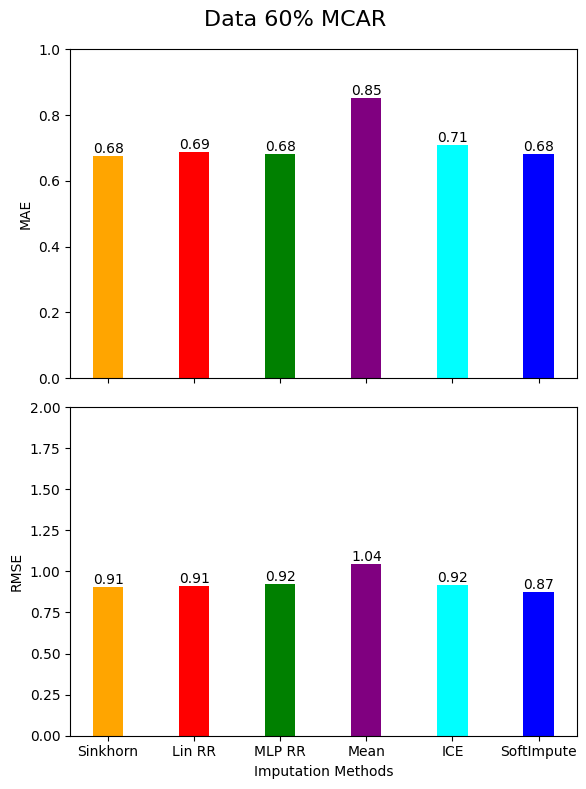

In [ ]:

# Define values and categories
values_mae_mcar60 = [sk_mae_mcar60,lin_rr_mae_mcar60,mlp_rr_mae_mcar60, mean_mae_mcar60, ice_mae_mcar60, soft_mae_mcar60]
values_rmse_mcar60 = [sk_rmse_mcar60, lin_rr_rmse_mcar60, mlp_rr_rmse_mcar60, mean_rmse_mcar60, ice_rmse_mcar60, soft_rmse_mcar60]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 60% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar60, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar60, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


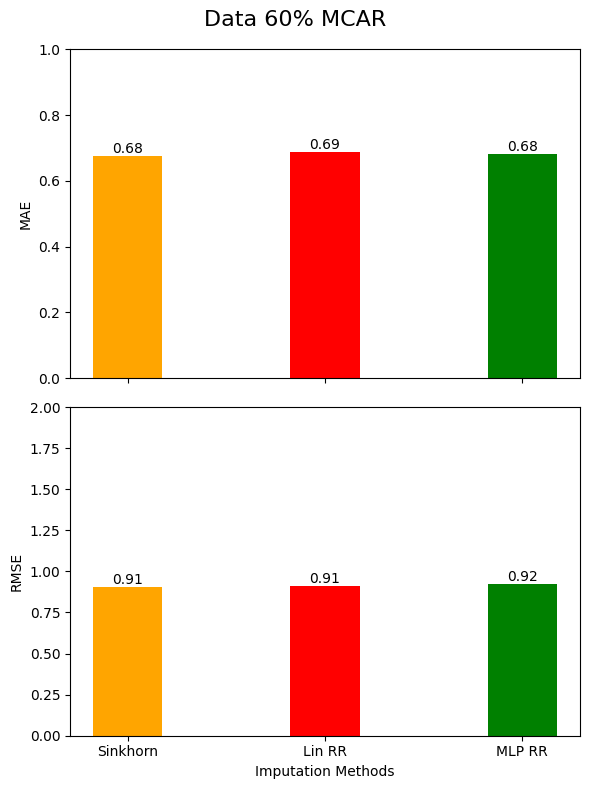

In [ ]:

# Define values and categories
valuesOT_mae_mcar60 = [sk_mae_mcar60,lin_rr_mae_mcar60,mlp_rr_mae_mcar60]
valuesOT_rmse_mcar60 = [sk_rmse_mcar60,lin_rr_rmse_mcar60,mlp_rr_rmse_mcar60]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 60% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar60, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar60, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


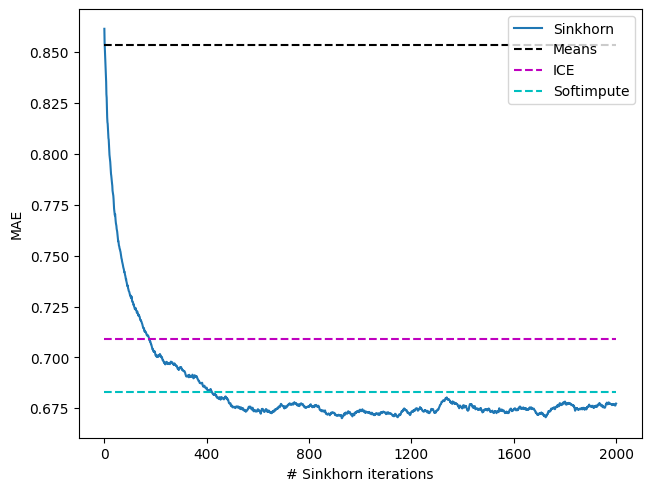

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes60mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes60mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar60, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar60, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar60, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

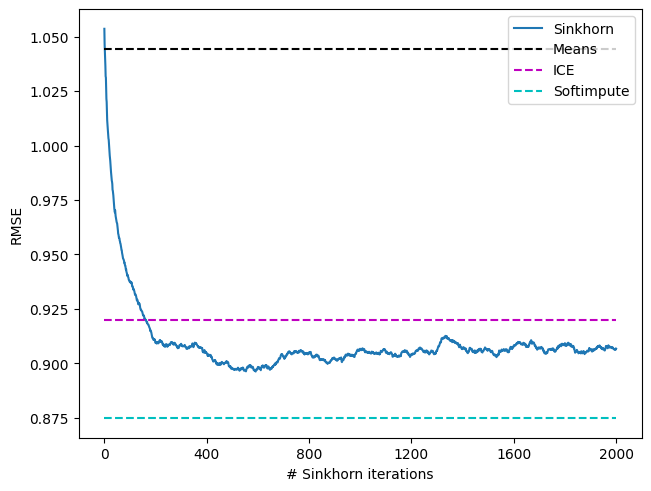

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses60mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses60mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar60, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar60, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar60, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

70% MCAR

In [ ]:
#sinkhorn
n_mcar70, d_mcar70 = data_mcar70.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar70 = pick_epsilon(data_mcar70)

print(epsilon_mcar70)

sk_imputer_mcar70 = SinkhornImputation(eps=epsilon_mcar70, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar70, sk_maes70mcar, sk_rmses70mcar = sk_imputer_mcar70.fit_transform(data_mcar70, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar70_numpy = sk_imp_mcar70.detach().cpu().numpy()

sk_mae_mcar70 = MAE(sk_imp_mcar70_numpy,ground_truth_numpy ,mask_mcar70)
sk_rmse_mcar70 = RMSE(sk_imp_mcar70_numpy, ground_truth_numpy,mask_mcar70)
print(sk_mae_mcar70,sk_rmse_mcar70)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.1537
INFO:root:Iteration 0:	 Loss: 1.0187	 Validation MAE: 0.8414	RMSE: 1.0310


0.15371426516812714


INFO:root:Iteration 500:	 Loss: 0.6693	 Validation MAE: 0.6954	RMSE: 0.9096
INFO:root:Iteration 1000:	 Loss: 0.7798	 Validation MAE: 0.6935	RMSE: 0.9184
INFO:root:Iteration 1500:	 Loss: 0.8228	 Validation MAE: 0.6978	RMSE: 0.9267


0.6970824806072132 0.9276434415184448


In [ ]:
#linear Round Robin
dmcar70_ = d_mcar70 - 1
models_liner_mcar70 = {}

for i in range(d_mcar70):
    models_liner_mcar70[i] = nn.Linear(dmcar70_, 1)

#Create the imputer
lin_rr_imputer_mcar70 = RRimputer(models_liner_mcar70, eps=epsilon_mcar70, lr=lr)
lin_rr_mcar70, lin_maesmcar70, lin_rmsesmcar70 = lin_rr_imputer_mcar70.fit_transform(data_mcar70, verbose=True, X_true=ground_truth)
lin_rr_mcar70_numpy = lin_rr_mcar70.detach().cpu().numpy()

lin_rr_mae_mcar70 = MAE(lin_rr_mcar70_numpy,ground_truth_numpy,mask_mcar70)
lin_rr_rmse_mcar70 = RMSE(lin_rr_mcar70_numpy, ground_truth_numpy,mask_mcar70)
print(lin_rr_mae_mcar70,lin_rr_rmse_mcar70)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.5160	Validation MAE: 0.7802	RMSE:  0.9842
INFO:root:Iteration 1:	 Loss: 1.5027	Validation MAE: 0.7402	RMSE:  0.9554
INFO:root:Iteration 2:	 Loss: 1.5484	Validation MAE: 0.7331	RMSE:  0.9578
INFO:root:Iteration 3:	 Loss: 1.5973	Validation MAE: 0.7317	RMSE:  0.9587
INFO:root:Iteration 4:	 Loss: 1.4310	Validation MAE: 0.7323	RMSE:  0.9566
INFO:root:Iteration 5:	 Loss: 1.4705	Validation MAE: 0.7318	RMSE:  0.9611
INFO:root:Iteration 6:	 Loss: 1.3740	Validation MAE: 0.7324	RMSE:  0.9617
INFO:root:Iteration 7:	 Loss: 1.3941	Validation MAE: 0.7332	RMSE:  0.9629
INFO:root:Iteration 8:	 Loss: 1.6237	Validation MAE: 0.7343	RMSE:  0.9649
INFO:root:Iteration 9:	 Loss: 1.3759	Validation MAE: 0.7346	RMSE:  0.9679
INFO:root:Early stopping criterion not reached


0.7345591634969478 0.9678650738639557


In [ ]:
#MLP Round Robin
dmcar70_ = d_mcar70 - 1
models_mlp_mcar70 = {}


for i in range(d_mcar70):
   models_mlp_mcar70[i] = nn.Sequential(nn.Linear(dmcar70_, 2 * dmcar70_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar70_, dmcar70_),
                              nn.ReLU(),
                              nn.Linear(dmcar70_, 1))

#Create the imputer
mlp_rr_imputer_mcar70 = RRimputer(models_mlp_mcar70, eps=epsilon_mcar70, lr=lr)

mlp_rr_mcar70, mlp_rr_maesmcar70, mlp_rr_rmsesmcar70 = mlp_rr_imputer_mcar70.fit_transform(data_mcar70, verbose=True, X_true=ground_truth)

mlp_rr_mcar70_numpy = mlp_rr_mcar70.detach().cpu().numpy()

mlp_rr_mae_mcar70 = MAE(mlp_rr_mcar70_numpy,ground_truth_numpy ,mask_mcar70)
mlp_rr_rmse_mcar70 = RMSE(mlp_rr_mcar70_numpy, ground_truth_numpy,mask_mcar70)
print(mlp_rr_mae_mcar70, mlp_rr_rmse_mcar70)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.3766	Validation MAE: 0.7153	RMSE:  0.9377
INFO:root:Iteration 1:	 Loss: 1.5341	Validation MAE: 0.7249	RMSE:  0.9615
INFO:root:Iteration 2:	 Loss: 1.4868	Validation MAE: 0.7325	RMSE:  0.9850
INFO:root:Iteration 3:	 Loss: 1.1762	Validation MAE: 0.7499	RMSE:  1.0068
INFO:root:Iteration 4:	 Loss: 1.5693	Validation MAE: 0.7466	RMSE:  1.0004
INFO:root:Iteration 5:	 Loss: 1.3652	Validation MAE: 0.7553	RMSE:  1.0133
INFO:root:Iteration 6:	 Loss: 1.5985	Validation MAE: 0.7553	RMSE:  1.0171
INFO:root:Iteration 7:	 Loss: 1.3659	Validation MAE: 0.7558	RMSE:  1.0175
INFO:root:Iteration 8:	 Loss: 1.2591	Validation MAE: 0.7603	RMSE:  1.0240
INFO:root:Iteration 9:	 Loss: 1.5265	Validation MAE: 0.7644	RMSE:  1.0307
INFO:root:Early stopping criterion not reached


0.7644166335781448 1.030653755165246


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar70 = SimpleImputer().fit_transform(data_mcar70_numpy)
mean_mae_mcar70 = MAE(mean_imp_mcar70, ground_truth_numpy, mask_mcar70)
mean_rmse_mcar70= RMSE(mean_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(mean_mae_mcar70, mean_rmse_mcar70)

#ICE
ice_imp_mcar70 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar70_numpy)
ice_mae_mcar70 = MAE(ice_imp_mcar70, ground_truth_numpy, mask_mcar70)
ice_rmse_mcar70 = RMSE(ice_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(ice_mae_mcar70,ice_rmse_mcar70)

#SoftImpute
cv_error_mcar70, grid_lambda_mcar70 = cv_softimpute(data_mcar70_numpy, grid_len=15)
lbda_mcar70 = grid_lambda_mcar70[np.argmin(cv_error_mcar70)]
soft_imp_mcar70 = softimpute((data_mcar70_numpy), lbda_mcar70)[1]

soft_mae_mcar70 = MAE(soft_imp_mcar70, ground_truth_numpy, mask_mcar70)
soft_rmse_mcar70 = RMSE(soft_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(soft_mae_mcar70,soft_rmse_mcar70)

0.8392276189208744 1.0284877768064147
0.7807363315063238 0.981172710235072
0.7079462783757755 0.9005364039527662


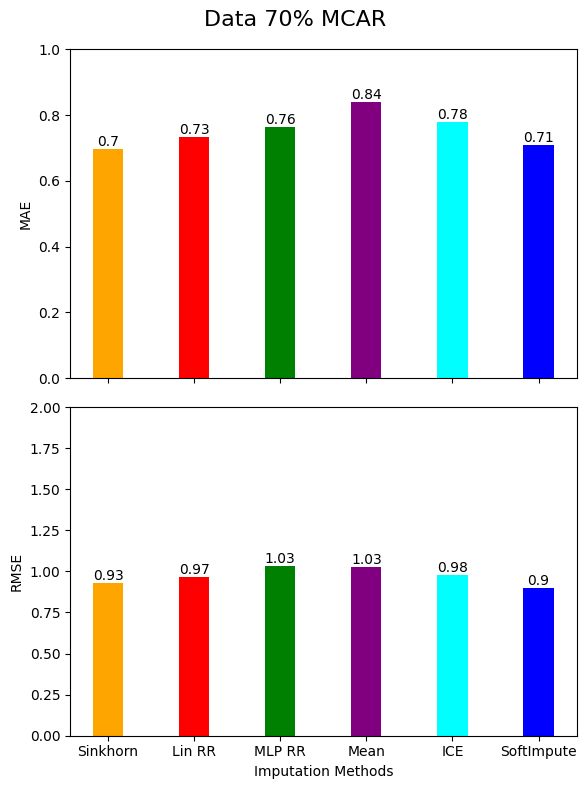

In [ ]:

# Define values and categories
values_mae_mcar70 = [sk_mae_mcar70,lin_rr_mae_mcar70,mlp_rr_mae_mcar70, mean_mae_mcar70, ice_mae_mcar70, soft_mae_mcar70]
values_rmse_mcar70 = [sk_rmse_mcar70, lin_rr_rmse_mcar70, mlp_rr_rmse_mcar70, mean_rmse_mcar70, ice_rmse_mcar70, soft_rmse_mcar70]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 70% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar70, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar70, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


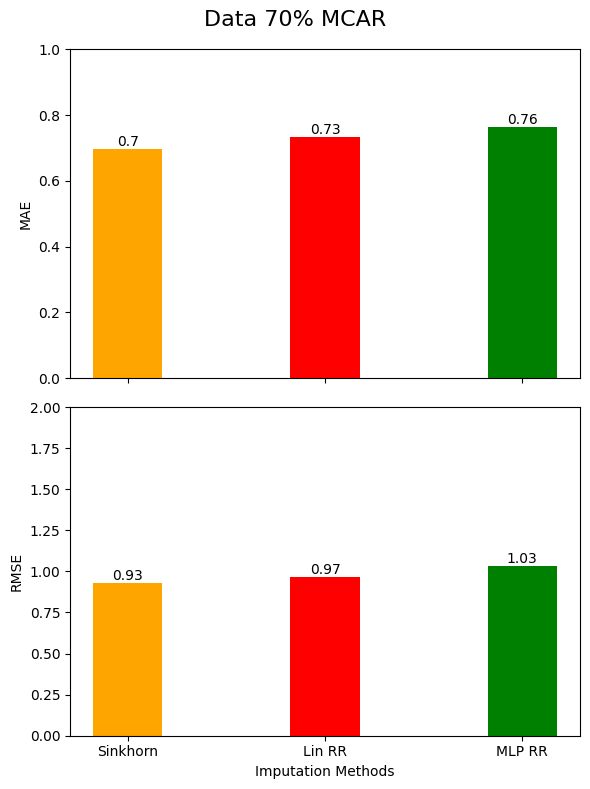

In [ ]:

# Define values and categories
valuesOT_mae_mcar70 = [sk_mae_mcar70,lin_rr_mae_mcar70,mlp_rr_mae_mcar70]
valuesOT_rmse_mcar70 = [sk_rmse_mcar70,lin_rr_rmse_mcar70,mlp_rr_rmse_mcar70]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 70% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar70, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar70, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


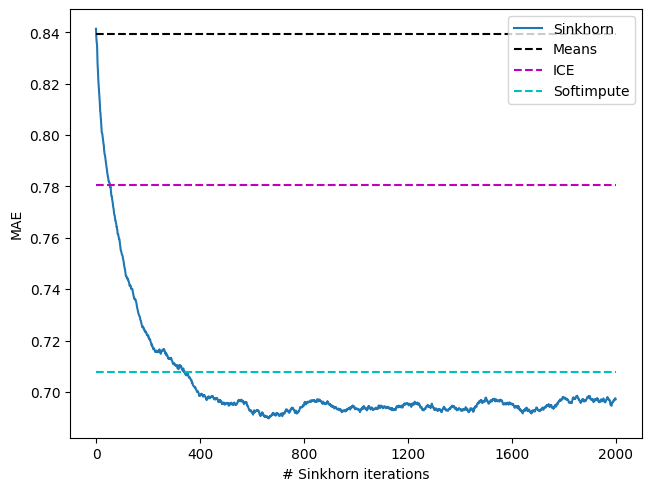

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes70mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes70mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar70, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar70, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar70, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

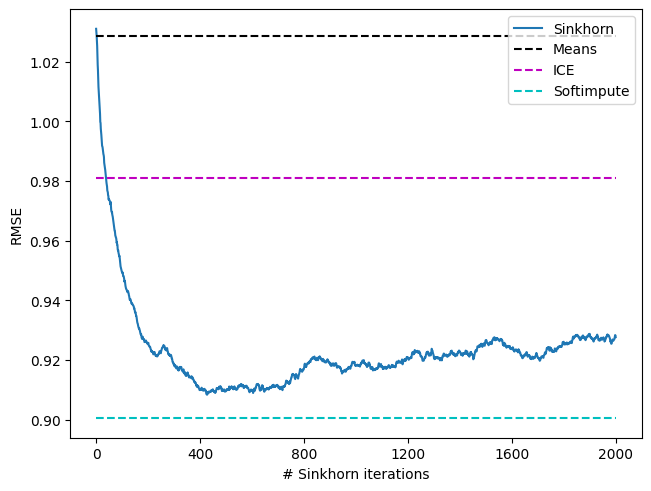

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses70mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses70mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar70, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar70, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar70, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

80% MCAR

In [ ]:
#sinkhorn
n_mcar80, d_mcar80 = data_mcar80.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar80 = pick_epsilon(data_mcar80)

print(epsilon_mcar80)

sk_imputer_mcar80 = SinkhornImputation(eps=epsilon_mcar80, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar80, sk_maes80mcar, sk_rmses80mcar = sk_imputer_mcar80.fit_transform(data_mcar80, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar80_numpy = sk_imp_mcar80.detach().cpu().numpy()

sk_mae_mcar80 = MAE(sk_imp_mcar80_numpy,ground_truth_numpy ,mask_mcar80)
sk_rmse_mcar80 = RMSE(sk_imp_mcar80_numpy, ground_truth_numpy,mask_mcar80)
print(sk_mae_mcar80,sk_rmse_mcar80)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.1007
INFO:root:Iteration 0:	 Loss: 0.9114	 Validation MAE: 0.8330	RMSE: 1.0288


0.10068418342965356


INFO:root:Iteration 500:	 Loss: 0.4882	 Validation MAE: 0.7455	RMSE: 0.9630
INFO:root:Iteration 1000:	 Loss: 0.3062	 Validation MAE: 0.7412	RMSE: 0.9652
INFO:root:Iteration 1500:	 Loss: 0.5324	 Validation MAE: 0.7396	RMSE: 0.9707


0.7469857410484739 0.9791070240955603


In [ ]:
#linear Round Robin
dmcar80_ = d_mcar80 - 1
models_liner_mcar80 = {}

for i in range(d_mcar80):
    models_liner_mcar80[i] = nn.Linear(dmcar80_, 1)

#Create the imputer
lin_rr_imputer_mcar80 = RRimputer(models_liner_mcar80, eps=epsilon_mcar80, lr=lr)
lin_rr_mcar80, lin_maesmcar80, lin_rmsesmcar80 = lin_rr_imputer_mcar80.fit_transform(data_mcar80, verbose=True, X_true=ground_truth)
lin_rr_mcar80_numpy = lin_rr_mcar80.detach().cpu().numpy()

lin_rr_mae_mcar80 = MAE(lin_rr_mcar80_numpy,ground_truth_numpy,mask_mcar80)
lin_rr_rmse_mcar80 = RMSE(lin_rr_mcar80_numpy, ground_truth_numpy,mask_mcar80)
print(lin_rr_mae_mcar80,lin_rr_rmse_mcar80)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.5096	Validation MAE: 0.8064	RMSE:  1.0225
INFO:root:Iteration 1:	 Loss: 1.3392	Validation MAE: 0.8030	RMSE:  1.0352
INFO:root:Iteration 2:	 Loss: 1.7307	Validation MAE: 0.7809	RMSE:  1.0152
INFO:root:Iteration 3:	 Loss: 1.4585	Validation MAE: 0.7902	RMSE:  1.0275
INFO:root:Iteration 4:	 Loss: 1.4855	Validation MAE: 0.7830	RMSE:  1.0172
INFO:root:Iteration 5:	 Loss: 1.4007	Validation MAE: 0.7896	RMSE:  1.0222
INFO:root:Iteration 6:	 Loss: 1.4587	Validation MAE: 0.7909	RMSE:  1.0248
INFO:root:Iteration 7:	 Loss: 1.3670	Validation MAE: 0.7931	RMSE:  1.0277
INFO:root:Iteration 8:	 Loss: 1.5513	Validation MAE: 0.7848	RMSE:  1.0199
INFO:root:Iteration 9:	 Loss: 1.3245	Validation MAE: 0.7907	RMSE:  1.0277
INFO:root:Early stopping criterion not reached


0.7906833453966335 1.0276868251040963


In [ ]:
#MLP Round Robin
dmcar80_ = d_mcar80 - 1
models_mlp_mcar80 = {}


for i in range(d_mcar80):
   models_mlp_mcar80[i] = nn.Sequential(nn.Linear(dmcar80_, 2 * dmcar80_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar80_, dmcar80_),
                              nn.ReLU(),
                              nn.Linear(dmcar80_, 1))

#Create the imputer
mlp_rr_imputer_mcar80 = RRimputer(models_mlp_mcar80, eps=epsilon_mcar80, lr=lr)

mlp_rr_mcar80, mlp_rr_maesmcar80, mlp_rr_rmsesmcar80 = mlp_rr_imputer_mcar80.fit_transform(data_mcar80, verbose=True, X_true=ground_truth)

mlp_rr_mcar80_numpy = mlp_rr_mcar80.detach().cpu().numpy()

mlp_rr_mae_mcar80 = MAE(mlp_rr_mcar80_numpy,ground_truth_numpy,mask_mcar80)
mlp_rr_rmse_mcar80 = RMSE(mlp_rr_mcar80_numpy, ground_truth_numpy,mask_mcar80)
print(mlp_rr_mae_mcar80, mlp_rr_rmse_mcar80)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.5018	Validation MAE: 0.8088	RMSE:  1.0482
INFO:root:Iteration 1:	 Loss: 1.3018	Validation MAE: 0.8009	RMSE:  1.0344
INFO:root:Iteration 2:	 Loss: 1.5827	Validation MAE: 0.7999	RMSE:  1.0469
INFO:root:Iteration 3:	 Loss: 1.4049	Validation MAE: 0.8176	RMSE:  1.0710
INFO:root:Iteration 4:	 Loss: 1.3925	Validation MAE: 0.8171	RMSE:  1.0733
INFO:root:Iteration 5:	 Loss: 1.3045	Validation MAE: 0.8280	RMSE:  1.0892
INFO:root:Iteration 6:	 Loss: 1.4123	Validation MAE: 0.8333	RMSE:  1.0951
INFO:root:Iteration 7:	 Loss: 1.2804	Validation MAE: 0.8412	RMSE:  1.1047
INFO:root:Iteration 8:	 Loss: 1.4190	Validation MAE: 0.8470	RMSE:  1.1094
INFO:root:Iteration 9:	 Loss: 1.2146	Validation MAE: 0.8390	RMSE:  1.1004
INFO:root:Early stopping criterion not reached


0.8390080298367177 1.1004047958807892


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar80 = SimpleImputer().fit_transform(data_mcar80_numpy)
mean_mae_mcar80 = MAE(mean_imp_mcar80, ground_truth_numpy, mask_mcar80)
mean_rmse_mcar80= RMSE(mean_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(mean_mae_mcar80, mean_rmse_mcar80)

#ICE
ice_imp_mcar80 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar80_numpy)
ice_mae_mcar80 = MAE(ice_imp_mcar80, ground_truth_numpy, mask_mcar80)
ice_rmse_mcar80 = RMSE(ice_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(ice_mae_mcar80,ice_rmse_mcar80)

#SoftImpute
cv_error_mcar80, grid_lambda_mcar80 = cv_softimpute(data_mcar80_numpy, grid_len=15)
lbda_mcar80 = grid_lambda_mcar80[np.argmin(cv_error_mcar80)]
soft_imp_mcar80 = softimpute((data_mcar80_numpy), lbda_mcar80)[1]

soft_mae_mcar80 = MAE(soft_imp_mcar80, ground_truth_numpy, mask_mcar80)
soft_rmse_mcar80 = RMSE(soft_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(soft_mae_mcar80,soft_rmse_mcar80)

0.8288578177363132 1.0246886386415008
0.845758457505015 1.0655170121659088
0.7467511584734243 0.9343919300257614


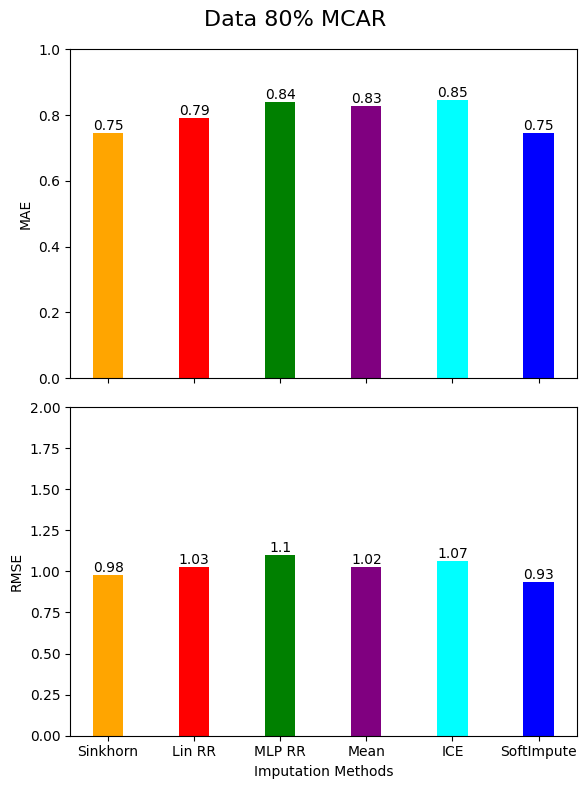

In [ ]:

# Define values and categories
values_mae_mcar80 = [sk_mae_mcar80,lin_rr_mae_mcar80,mlp_rr_mae_mcar80, mean_mae_mcar80, ice_mae_mcar80, soft_mae_mcar80]
values_rmse_mcar80 = [sk_rmse_mcar80, lin_rr_rmse_mcar80, mlp_rr_rmse_mcar80, mean_rmse_mcar80, ice_rmse_mcar80, soft_rmse_mcar80]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 80% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar80, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar80, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


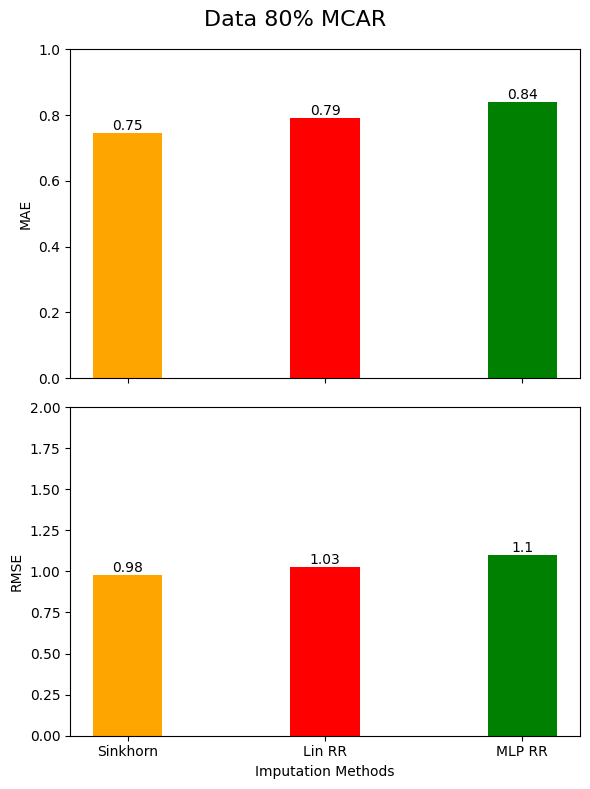

In [ ]:

# Define values and categories
valuesOT_mae_mcar80 = [sk_mae_mcar80,lin_rr_mae_mcar80,mlp_rr_mae_mcar80]
valuesOT_rmse_mcar80 = [sk_rmse_mcar80,lin_rr_rmse_mcar80,mlp_rr_rmse_mcar80]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 80% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar80, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar80, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


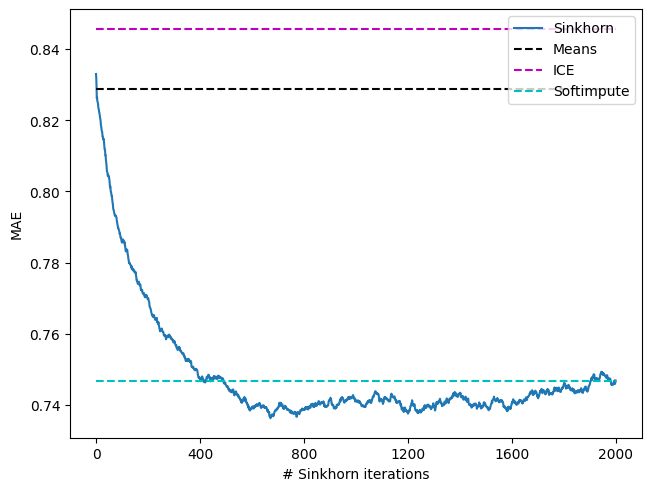

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes80mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes80mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar80, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar80, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar80, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

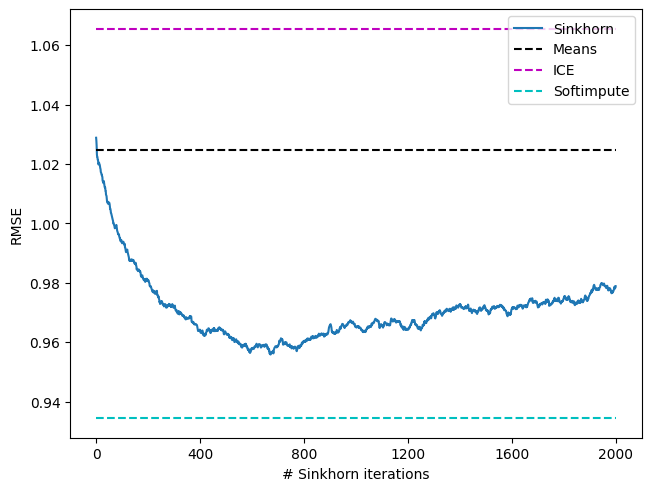

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses80mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses80mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar80, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar80, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar80, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

90% MCAR

In [ ]:
#sinkhorn
n_mcar90, d_mcar90 = data_mcar90.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar90 = pick_epsilon(data_mcar90)

print(epsilon_mcar90)

sk_imputer_mcar90 = SinkhornImputation(eps=epsilon_mcar90, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar90, sk_maes90mcar, sk_rmses90mcar = sk_imputer_mcar90.fit_transform(data_mcar90, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar90_numpy = sk_imp_mcar90.detach().cpu().numpy()

sk_mae_mcar90 = MAE(sk_imp_mcar90_numpy,ground_truth_numpy ,mask_mcar90)
sk_rmse_mcar90 = RMSE(sk_imp_mcar90_numpy, ground_truth_numpy,mask_mcar90)
print(sk_mae_mcar90,sk_rmse_mcar90)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.0483
INFO:root:Iteration 0:	 Loss: 0.4434	 Validation MAE: 0.8298	RMSE: 1.0248


0.04831535796747027


INFO:root:Iteration 500:	 Loss: 0.2017	 Validation MAE: 0.8484	RMSE: 1.0657
INFO:root:Iteration 1000:	 Loss: 0.3672	 Validation MAE: 0.8709	RMSE: 1.0972
INFO:root:Iteration 1500:	 Loss: 0.3598	 Validation MAE: 0.8790	RMSE: 1.1114


0.8901212229798974 1.1257160556409371


In [ ]:
#linear Round Robin
dmcar90_ = d_mcar90 - 1
models_liner_mcar90 = {}

for i in range(d_mcar90):
    models_liner_mcar90[i] = nn.Linear(dmcar90_, 1)

#Create the imputer
lin_rr_imputer_mcar90 = RRimputer(models_liner_mcar90, eps=epsilon_mcar90, lr=lr)
lin_rr_mcar90, lin_maesmcar90, lin_rmsesmcar90 = lin_rr_imputer_mcar90.fit_transform(data_mcar90, verbose=True, X_true=ground_truth)
lin_rr_mcar90_numpy = lin_rr_mcar90.detach().cpu().numpy()

lin_rr_mae_mcar90 = MAE(lin_rr_mcar90_numpy,ground_truth_numpy ,mask_mcar90)
lin_rr_rmse_mcar90 = RMSE(lin_rr_mcar90_numpy, ground_truth_numpy,mask_mcar90)
print(lin_rr_mae_mcar90,lin_rr_rmse_mcar90)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 0.8840	Validation MAE: 0.8136	RMSE:  1.0193
INFO:root:Iteration 1:	 Loss: 1.8820	Validation MAE: 0.8877	RMSE:  1.1291
INFO:root:Iteration 2:	 Loss: 2.2526	Validation MAE: 0.9050	RMSE:  1.1542
INFO:root:Iteration 3:	 Loss: 2.0399	Validation MAE: 0.8979	RMSE:  1.1391
INFO:root:Iteration 4:	 Loss: 1.4884	Validation MAE: 0.9123	RMSE:  1.1626
INFO:root:Iteration 5:	 Loss: 2.1897	Validation MAE: 0.9068	RMSE:  1.1540
INFO:root:Iteration 6:	 Loss: 1.4827	Validation MAE: 0.9095	RMSE:  1.1567
INFO:root:Iteration 7:	 Loss: 1.8423	Validation MAE: 0.9089	RMSE:  1.1568
INFO:root:Iteration 8:	 Loss: 1.9459	Validation MAE: 0.9080	RMSE:  1.1582
INFO:root:Iteration 9:	 Loss: 2.2567	Validation MAE: 0.9099	RMSE:  1.1606
INFO:root:Early stopping criterion not reached


0.9098536967713582 1.1606247981381272


In [ ]:
#MLP Round Robin
dmcar90_ = d_mcar90 - 1
models_mlp_mcar90 = {}


for i in range(d_mcar90):
   models_mlp_mcar90[i] = nn.Sequential(nn.Linear(dmcar90_, 2 * dmcar90_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar90_, dmcar90_),
                              nn.ReLU(),
                              nn.Linear(dmcar90_, 1))

#Create the imputer
mlp_rr_imputer_mcar90 = RRimputer(models_mlp_mcar90, eps=epsilon_mcar90, lr=lr)

mlp_rr_mcar90, mlp_rr_maesmcar90, mlp_rr_rmsesmcar90 = mlp_rr_imputer_mcar90.fit_transform(data_mcar90, verbose=True, X_true=ground_truth)

mlp_rr_mcar90_numpy = mlp_rr_mcar90.detach().cpu().numpy()

mlp_rr_mae_mcar90 = MAE(mlp_rr_mcar90_numpy,ground_truth_numpy ,mask_mcar90)
mlp_rr_rmse_mcar90 = RMSE(mlp_rr_mcar90_numpy, ground_truth_numpy,mask_mcar90)
print(mlp_rr_mae_mcar90, mlp_rr_rmse_mcar90)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.7126	Validation MAE: 1.0002	RMSE:  1.2648
INFO:root:Iteration 1:	 Loss: 0.9433	Validation MAE: 0.9627	RMSE:  1.2246
INFO:root:Iteration 2:	 Loss: 1.1246	Validation MAE: 0.9877	RMSE:  1.2492
INFO:root:Iteration 3:	 Loss: 1.5112	Validation MAE: 1.0059	RMSE:  1.2794
INFO:root:Iteration 4:	 Loss: 1.2659	Validation MAE: 1.0100	RMSE:  1.2808
INFO:root:Iteration 5:	 Loss: 1.5480	Validation MAE: 1.0099	RMSE:  1.2877
INFO:root:Iteration 6:	 Loss: 1.2732	Validation MAE: 1.0157	RMSE:  1.2939
INFO:root:Iteration 7:	 Loss: 1.7425	Validation MAE: 1.0128	RMSE:  1.2863
INFO:root:Iteration 8:	 Loss: 2.1281	Validation MAE: 1.0150	RMSE:  1.2901
INFO:root:Iteration 9:	 Loss: 3.3495	Validation MAE: 1.0239	RMSE:  1.3008
INFO:root:Early stopping criterion not reached


1.0238610324649537 1.3007615631404927


In [ ]:
#mean
#using numpy version of data
mean_imp_mcar90 = SimpleImputer().fit_transform(data_mcar90_numpy)
mean_mae_mcar90 = MAE(mean_imp_mcar90, ground_truth_numpy, mask_mcar90)
mean_rmse_mcar90 = RMSE(mean_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(mean_mae_mcar90, mean_rmse_mcar90)

#ICE
ice_imp_mcar90 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar90_numpy)
ice_mae_mcar90 = MAE(ice_imp_mcar90, ground_truth_numpy, mask_mcar90)
ice_rmse_mcar90 = RMSE(ice_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(ice_mae_mcar90,ice_rmse_mcar90)

#SoftImpute
cv_error_mcar90, grid_lambda_mcar90 = cv_softimpute(data_mcar90_numpy, grid_len=15)
lbda_mcar90 = grid_lambda_mcar90[np.argmin(cv_error_mcar90)]
soft_imp_mcar90 = softimpute((data_mcar90_numpy), lbda_mcar90)[1]

soft_mae_mcar90 = MAE(soft_imp_mcar90, ground_truth_numpy, mask_mcar90)
soft_rmse_mcar90 = RMSE(soft_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(soft_mae_mcar90,soft_rmse_mcar90)

0.8261797460567907 1.0199975719434713


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1.043578131297371 1.8370794091252436
0.8212143679551527 1.0092207991022732


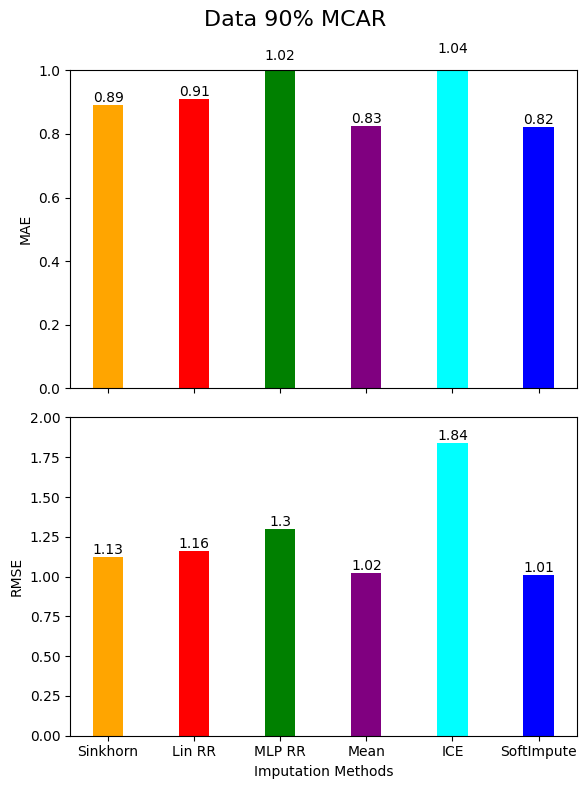

In [ ]:

# Define values and categories
values_mae_mcar90 = [sk_mae_mcar90, lin_rr_mae_mcar90, mlp_rr_mae_mcar90, mean_mae_mcar90, ice_mae_mcar90, soft_mae_mcar90]
values_rmse_mcar90 = [sk_rmse_mcar90, lin_rr_rmse_mcar90, mlp_rr_rmse_mcar90, mean_rmse_mcar90, ice_rmse_mcar90, soft_rmse_mcar90]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 90% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar90, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar90, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


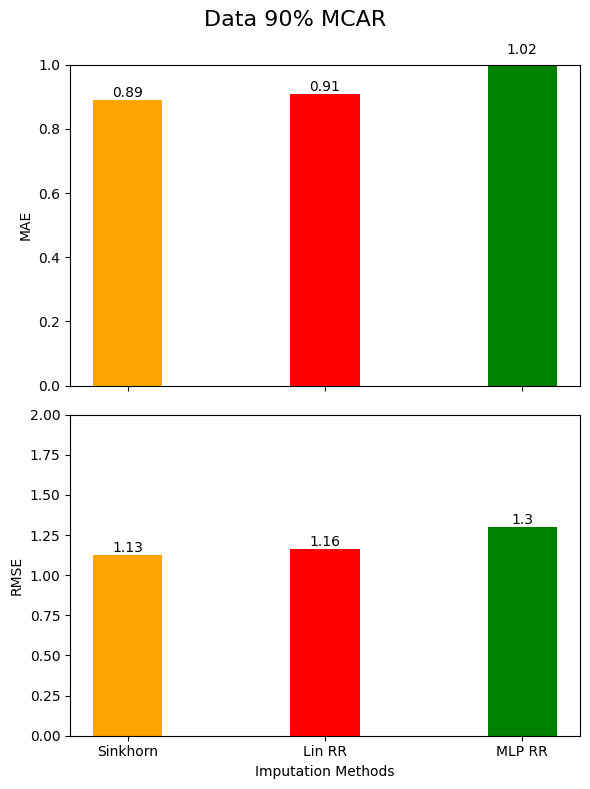

In [ ]:

# Define values and categories
valuesOT_mae_mcar90 = [sk_mae_mcar90,lin_rr_mae_mcar90,mlp_rr_mae_mcar90]
valuesOT_rmse_mcar90 = [sk_rmse_mcar90,lin_rr_rmse_mcar90,mlp_rr_rmse_mcar90]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 90% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar90, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar90, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


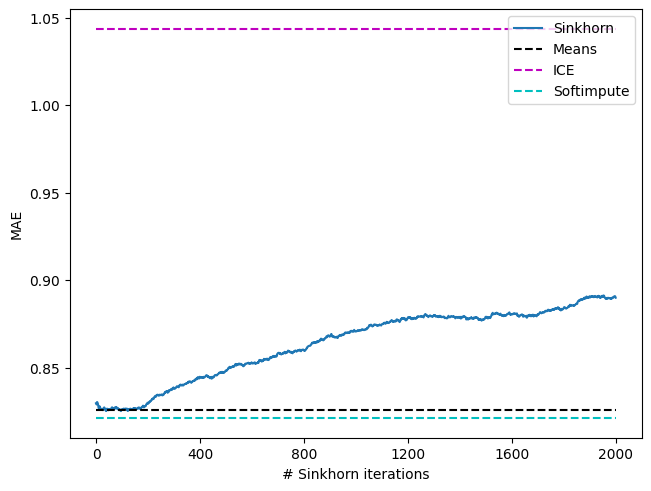

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes90mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes90mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar90, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar90, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar90, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

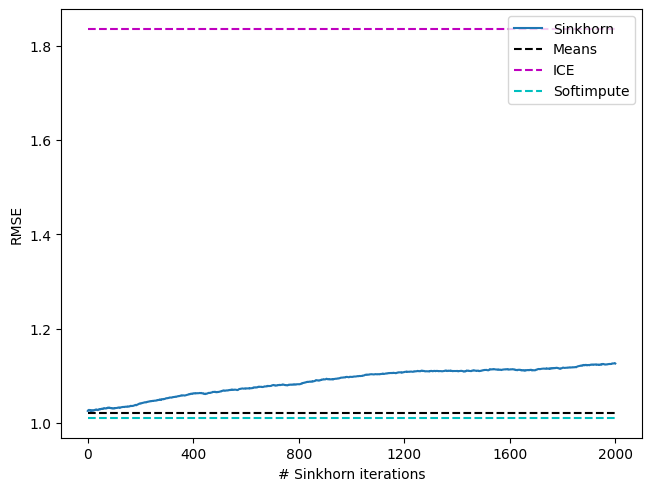

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses90mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses90mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar90, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar90, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar90, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

95% MCAR

In [271]:
#sinkhorn
n_mcar95, d_mcar95 = data_mcar95.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar95 = pick_epsilon(data_mcar95)

print(epsilon_mcar95)

sk_imputer_mcar95 = SinkhornImputation(eps=epsilon_mcar95, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar95, sk_maes95mcar, sk_rmses95mcar = sk_imputer_mcar95.fit_transform(data_mcar95, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar95_numpy = sk_imp_mcar95.detach().cpu().numpy()

sk_mae_mcar95 = MAE(sk_imp_mcar95_numpy,ground_truth_numpy ,mask_mcar95)
sk_rmse_mcar95 = RMSE(sk_imp_mcar95_numpy, ground_truth_numpy,mask_mcar95)
print(sk_mae_mcar95,sk_rmse_mcar95)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.0252
INFO:root:Iteration 0:	 Loss: 0.1927	 Validation MAE: 0.8444	RMSE: 1.0456


0.02521946096612593


INFO:root:Iteration 500:	 Loss: 0.0744	 Validation MAE: 0.8909	RMSE: 1.1078
INFO:root:Iteration 1000:	 Loss: 0.1216	 Validation MAE: 0.9074	RMSE: 1.1240
INFO:root:Iteration 1500:	 Loss: 0.1092	 Validation MAE: 0.9119	RMSE: 1.1290


0.9156528044188598 1.1354343746542253


In [272]:
#linear Round Robin
dmcar95_ = d_mcar95 - 1
models_liner_mcar95 = {}

for i in range(d_mcar95):
    models_liner_mcar95[i] = nn.Linear(dmcar95_, 1)

#Create the imputer
lin_rr_imputer_mcar95 = RRimputer(models_liner_mcar95, eps=epsilon_mcar95, lr=lr)
lin_rr_mcar95, lin_maesmcar95, lin_rmsesmcar95 = lin_rr_imputer_mcar95.fit_transform(data_mcar95, verbose=True, X_true=ground_truth)
lin_rr_mcar95_numpy = lin_rr_mcar95.detach().cpu().numpy()

lin_rr_mae_mcar95 = MAE(lin_rr_mcar95_numpy,ground_truth_numpy ,mask_mcar95)
lin_rr_rmse_mcar95 = RMSE(lin_rr_mcar95_numpy, ground_truth_numpy,mask_mcar95)
print(lin_rr_mae_mcar95,lin_rr_rmse_mcar95)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.0662	Validation MAE: 0.8702	RMSE:  1.0772
INFO:root:Iteration 1:	 Loss: 2.6467	Validation MAE: 0.9263	RMSE:  1.1634
INFO:root:Iteration 2:	 Loss: 1.4915	Validation MAE: 0.9491	RMSE:  1.1958
INFO:root:Iteration 3:	 Loss: 2.1057	Validation MAE: 0.9579	RMSE:  1.1992
INFO:root:Iteration 4:	 Loss: 1.6633	Validation MAE: 0.9613	RMSE:  1.2051
INFO:root:Iteration 5:	 Loss: 1.2435	Validation MAE: 0.9703	RMSE:  1.2171
INFO:root:Iteration 6:	 Loss: 2.1952	Validation MAE: 0.9648	RMSE:  1.2113
INFO:root:Iteration 7:	 Loss: 1.3383	Validation MAE: 0.9701	RMSE:  1.2153
INFO:root:Iteration 8:	 Loss: 1.7543	Validation MAE: 0.9732	RMSE:  1.2181
INFO:root:Iteration 9:	 Loss: 1.5689	Validation MAE: 0.9745	RMSE:  1.2219
INFO:root:Early stopping criterion not reached


0.9744527162518812 1.2218623926744412


In [273]:
#MLP Round Robin
dmcar95_ = d_mcar95 - 1
models_mlp_mcar95 = {}


for i in range(d_mcar95):
   models_mlp_mcar95[i] = nn.Sequential(nn.Linear(dmcar95_, 2 * dmcar95_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar95_, dmcar95_),
                              nn.ReLU(),
                              nn.Linear(dmcar95_, 1))

#Create the imputer
mlp_rr_imputer_mcar95 = RRimputer(models_mlp_mcar95, eps=epsilon_mcar95, lr=lr)

mlp_rr_mcar95, mlp_rr_maesmcar95, mlp_rr_rmsesmcar95 = mlp_rr_imputer_mcar95.fit_transform(data_mcar95, verbose=True, X_true=ground_truth)

mlp_rr_mcar95_numpy = mlp_rr_mcar95.detach().cpu().numpy()

mlp_rr_mae_mcar95 = MAE(mlp_rr_mcar95_numpy,ground_truth_numpy ,mask_mcar95)
mlp_rr_rmse_mcar95 = RMSE(mlp_rr_mcar95_numpy, ground_truth_numpy,mask_mcar95)
print(mlp_rr_mae_mcar95, mlp_rr_rmse_mcar95)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.6371	Validation MAE: 1.0234	RMSE:  1.3123
INFO:root:Iteration 1:	 Loss: 0.7690	Validation MAE: 1.0017	RMSE:  1.2774
INFO:root:Iteration 2:	 Loss: 1.9231	Validation MAE: 1.0243	RMSE:  1.3035
INFO:root:Iteration 3:	 Loss: 2.1610	Validation MAE: 1.0328	RMSE:  1.3141
INFO:root:Iteration 4:	 Loss: 2.8119	Validation MAE: 1.0300	RMSE:  1.3116
INFO:root:Iteration 5:	 Loss: 0.5926	Validation MAE: 1.0281	RMSE:  1.3110
INFO:root:Iteration 6:	 Loss: 0.9503	Validation MAE: 1.0339	RMSE:  1.3181
INFO:root:Iteration 7:	 Loss: 1.4801	Validation MAE: 1.0331	RMSE:  1.3197
INFO:root:Iteration 8:	 Loss: 1.3057	Validation MAE: 1.0354	RMSE:  1.3230
INFO:root:Iteration 9:	 Loss: 1.2378	Validation MAE: 1.0432	RMSE:  1.3312
INFO:root:Early stopping criterion not reached


1.043200784763699 1.33117288257286


In [274]:
#mean
#using numpy version of data
mean_imp_mcar95 = SimpleImputer().fit_transform(data_mcar95_numpy)
mean_mae_mcar95 = MAE(mean_imp_mcar95, ground_truth_numpy, mask_mcar95)
mean_rmse_mcar95 = RMSE(mean_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(mean_mae_mcar95, mean_rmse_mcar95)

#ICE
ice_imp_mcar95 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar95_numpy)
ice_mae_mcar95 = MAE(ice_imp_mcar95, ground_truth_numpy, mask_mcar95)
ice_rmse_mcar95 = RMSE(ice_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(ice_mae_mcar95,ice_rmse_mcar95)

#SoftImpute
cv_error_mcar95, grid_lambda_mcar95 = cv_softimpute(data_mcar95_numpy, grid_len=15)
lbda_mcar95 = grid_lambda_mcar95[np.argmin(cv_error_mcar95)]
soft_imp_mcar95 = softimpute((data_mcar95_numpy), lbda_mcar95)[1]

soft_mae_mcar95 = MAE(soft_imp_mcar95, ground_truth_numpy, mask_mcar95)
soft_rmse_mcar95 = RMSE(soft_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(soft_mae_mcar95,soft_rmse_mcar95)

0.8441986826406204 1.043300187972331


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


95.35660539047034 729.8159908015435
0.8175226298309558 1.000292200975285


In [275]:

# Define values and categories
values_mae_mcar95 = [sk_mae_mcar95,lin_rr_mae_mcar95,mlp_rr_mae_mcar95, mean_mae_mcar95, ice_mae_mcar95, soft_mae_mcar95]
values_rmse_mcar95 = [sk_rmse_mcar95, lin_rr_rmse_mcar95, mlp_rr_rmse_mcar95, mean_rmse_mcar95, ice_rmse_mcar95, soft_rmse_mcar95]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.2 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 95% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar95, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar95, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


C:\Users\zhossai3\AppData\Local\Temp\ipykernel_39844\3259012658.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


ValueError: Image size of 554x102251 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 600x800 with 2 Axes>

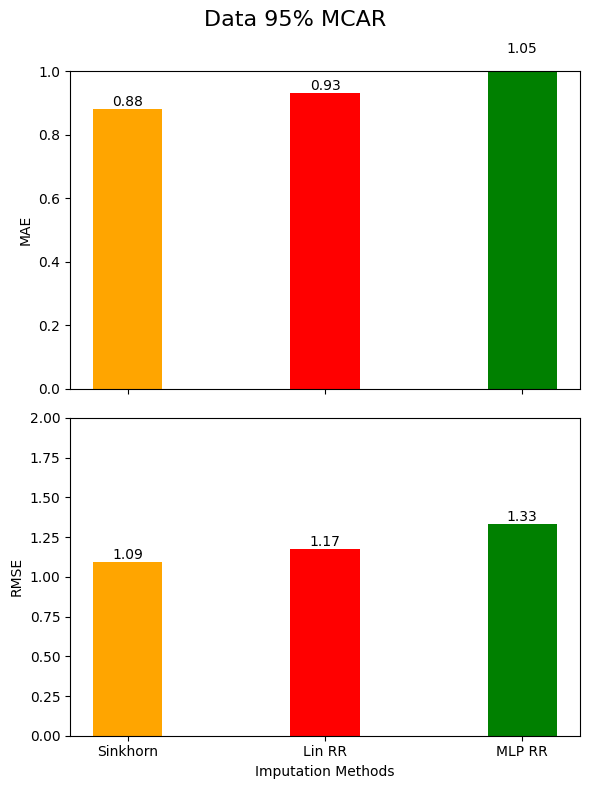

In [ ]:

# Define values and categories
valuesOT_mae_mcar95 = [sk_mae_mcar95,lin_rr_mae_mcar95,mlp_rr_mae_mcar95]
valuesOT_rmse_mcar95 = [sk_rmse_mcar95,lin_rr_rmse_mcar95,mlp_rr_rmse_mcar95]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 95% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar95, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar95, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


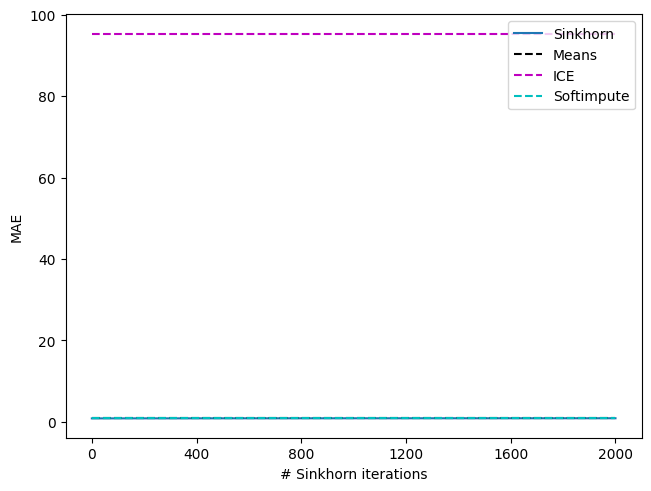

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes95mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes95mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar95, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar95, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar95, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

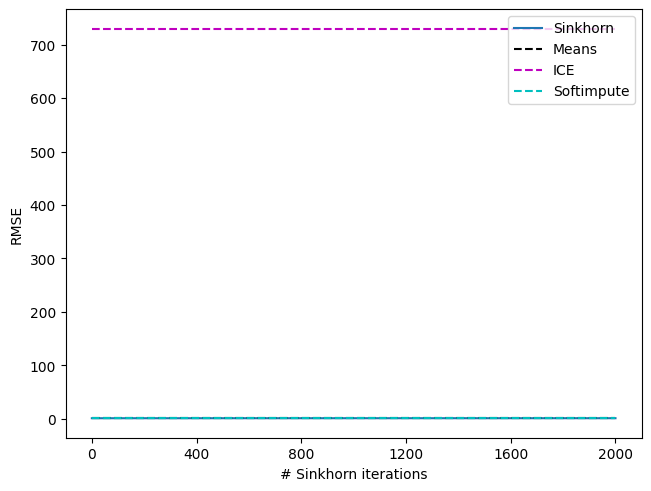

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses95mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses95mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar95, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar95, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar95, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define your MAE and RMSE data
sk_mcar_mae = [sk_mae_mcar10, sk_mae_mcar15, sk_mae_mcar20, sk_mae_mcar25, sk_mae_mcar30,sk_mae_mcar35,sk_mae_mcar40,sk_mae_mcar45,sk_mae_mcar50,sk_mae_mcar60,sk_mae_mcar70,sk_mae_mcar80,sk_mae_mcar90,sk_mae_mcar95]
mean_mcar_mae = [mean_mae_mcar10, mean_mae_mcar15, mean_mae_mcar20, mean_mae_mcar25, mean_mae_mcar30,mean_mae_mcar35,mean_mae_mcar40,mean_mae_mcar45,mean_mae_mcar50,mean_mae_mcar60,mean_mae_mcar70,mean_mae_mcar80,mean_mae_mcar90,mean_mae_mcar95]
ice_mcar_mae = [ice_mae_mcar10, ice_mae_mcar15, ice_mae_mcar20, ice_mae_mcar25, ice_mae_mcar30,ice_mae_mcar35,ice_mae_mcar40,ice_mae_mcar45,ice_mae_mcar50,ice_mae_mcar60,ice_mae_mcar70,ice_mae_mcar80,ice_mae_mcar90,ice_mae_mcar95]
soft_mcar_mae = [soft_mae_mcar10, soft_mae_mcar15, soft_mae_mcar20, soft_mae_mcar25, soft_mae_mcar30,soft_mae_mcar35,soft_mae_mcar40,soft_mae_mcar45,soft_mae_mcar50,soft_mae_mcar60,soft_mae_mcar70,soft_mae_mcar80,soft_mae_mcar90,soft_mae_mcar95]

sk_mcar_rmse = [sk_rmse_mcar10, sk_rmse_mcar15, sk_rmse_mcar20, sk_rmse_mcar25, sk_rmse_mcar30,sk_rmse_mcar35,sk_rmse_mcar40,sk_rmse_mcar45,sk_rmse_mcar50,sk_rmse_mcar60,sk_rmse_mcar70,sk_rmse_mcar80,sk_rmse_mcar90,sk_rmse_mcar95]
mean_mcar_rmse = [mean_rmse_mcar10, mean_rmse_mcar15, mean_rmse_mcar20, mean_rmse_mcar25, mean_rmse_mcar30,mean_rmse_mcar35,mean_rmse_mcar40,mean_rmse_mcar45,mean_rmse_mcar50,mean_rmse_mcar60,mean_rmse_mcar70,mean_rmse_mcar80,mean_rmse_mcar90,mean_rmse_mcar95]
ice_mcar_rmse = [ice_rmse_mcar10, ice_rmse_mcar15, ice_rmse_mcar20, ice_rmse_mcar25, ice_rmse_mcar30,ice_rmse_mcar35,ice_rmse_mcar40,ice_rmse_mcar45,ice_rmse_mcar50,ice_rmse_mcar60,ice_rmse_mcar70,ice_rmse_mcar80,ice_rmse_mcar90,ice_rmse_mcar95]
soft_mcar_rmse = [soft_rmse_mcar10, soft_rmse_mcar15, soft_rmse_mcar20, soft_rmse_mcar25, soft_rmse_mcar30,soft_rmse_mcar35,soft_rmse_mcar40,soft_rmse_mcar45,soft_rmse_mcar50,soft_rmse_mcar60,soft_rmse_mcar70,soft_rmse_mcar80,soft_rmse_mcar90,soft_rmse_mcar95]

# Combine the MAE and RMSE data for each MCAR level
values_mae = [sk_mcar_mae, mean_mcar_mae, ice_mcar_mae, soft_mcar_mae]
values_rmse = [sk_mcar_rmse, mean_mcar_rmse, ice_mcar_rmse, soft_mcar_rmse]

# Define categories, x-axis labels, and colors
categories = ['10%', '15%', '20%', '25%', '30%','35%','40%','45%','50%','60%','70%','80%','90%','95%']
colors = ['orange', 'purple', 'cyan', 'blue']  # Yellow for Sinkhorn, purple for Mean, cyan for ICE, blue for SoftImpute
imputation_models = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
num_methods = len(categories)
bar_width = 0.18  # Width of each bar
x = np.arange(num_methods)  # X locations for the methods

# Create subplots for MAE and RMSE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Comparison of Imputation Methods at Different MCAR Levels of Wine Data', fontsize=10)

# Plot MAE bars for each MCAR level with custom colors
for i, (mcar, mae_values, color) in enumerate(zip(imputation_models, values_mae, colors)):
    ax1.bar(x + i * bar_width, mae_values, bar_width, label=mcar, color=color)

# Customize MAE plot
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1.5)  # Adjust based on your data
ax1.set_xticks(x + bar_width)  # Center x-ticks
ax1.set_xticklabels(categories)
ax1.legend(title="Imputation Models")

# Add values on top of MAE bars
for i, mae_values in enumerate(values_mae):
    for j, value in enumerate(mae_values):
        ax1.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=6.5)

# Plot RMSE bars for each MCAR level with custom colors
for i, (mcar, rmse_values, color) in enumerate(zip(imputation_models, values_rmse, colors)):
    ax2.bar(x + i * bar_width, rmse_values, bar_width, label=mcar, color=color)

# Customize RMSE plot
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
ax2.set_xticks(x + bar_width)  # Center x-ticks
ax2.set_xticklabels(categories)
ax2.legend(title="Imputation Models")

# Add values on top of RMSE bars
for i, rmse_values in enumerate(values_rmse):
    for j, value in enumerate(rmse_values):
        ax2.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=6.5)

# Show the plot
plt.xlabel('MCAR Levels')
plt.tight_layout()
plt.show()


C:\Users\zhossai3\AppData\Local\Temp\ipykernel_39844\1408690855.py:65: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


ValueError: Image size of 855x153333 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x1200 with 2 Axes>

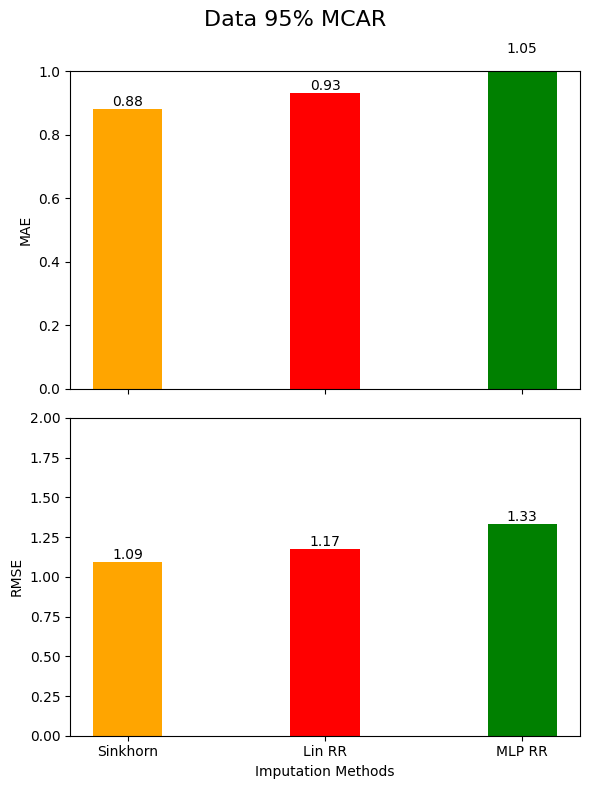

In [260]:

# Define values and categories
valuesOT_mae_mcar95 = [sk_mae_mcar95,lin_rr_mae_mcar95,mlp_rr_mae_mcar95]
valuesOT_rmse_mcar95 = [sk_rmse_mcar95,lin_rr_rmse_mcar95,mlp_rr_rmse_mcar95]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 95% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar95, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar95, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


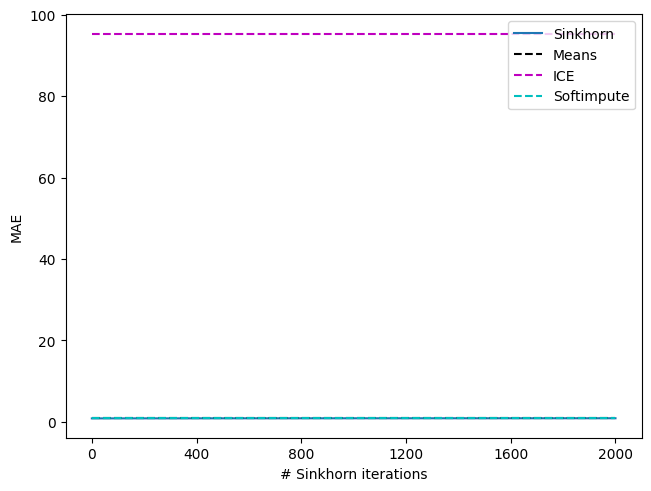

In [261]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes95mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes95mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar95, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar95, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar95, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

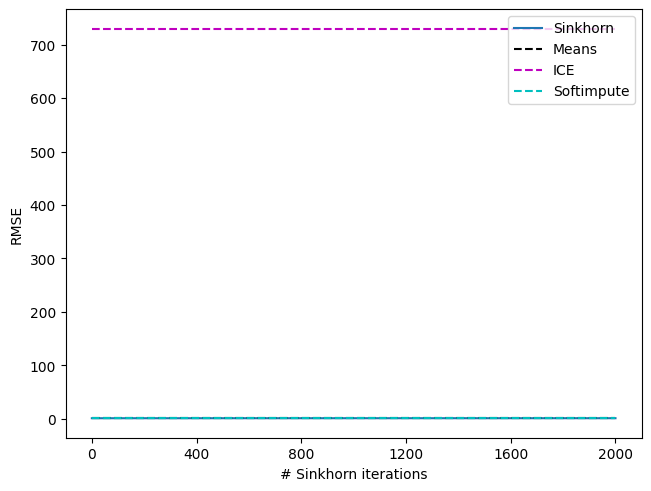

In [262]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses95mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses95mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar95, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar95, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar95, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

In [270]:
import numpy as np
import matplotlib.pyplot as plt

# Define your MAE and RMSE data
sk_mcar_mae = [sk_mae_mcar10, sk_mae_mcar15, sk_mae_mcar20, sk_mae_mcar25, sk_mae_mcar30,sk_mae_mcar35,sk_mae_mcar40,sk_mae_mcar45,sk_mae_mcar50,sk_mae_mcar60,sk_mae_mcar70,sk_mae_mcar80,sk_mae_mcar90,sk_mae_mcar95]
mean_mcar_mae = [mean_mae_mcar10, mean_mae_mcar15, mean_mae_mcar20, mean_mae_mcar25, mean_mae_mcar30,mean_mae_mcar35,mean_mae_mcar40,mean_mae_mcar45,mean_mae_mcar50,mean_mae_mcar60,mean_mae_mcar70,mean_mae_mcar80,mean_mae_mcar90,mean_mae_mcar95]
ice_mcar_mae = [ice_mae_mcar10, ice_mae_mcar15, ice_mae_mcar20, ice_mae_mcar25, ice_mae_mcar30,ice_mae_mcar35,ice_mae_mcar40,ice_mae_mcar45,ice_mae_mcar50,ice_mae_mcar60,ice_mae_mcar70,ice_mae_mcar80,ice_mae_mcar90,ice_mae_mcar95]
soft_mcar_mae = [soft_mae_mcar10, soft_mae_mcar15, soft_mae_mcar20, soft_mae_mcar25, soft_mae_mcar30,soft_mae_mcar35,soft_mae_mcar40,soft_mae_mcar45,soft_mae_mcar50,soft_mae_mcar60,soft_mae_mcar70,soft_mae_mcar80,soft_mae_mcar90,soft_mae_mcar95]

sk_mcar_rmse = [sk_rmse_mcar10, sk_rmse_mcar15, sk_rmse_mcar20, sk_rmse_mcar25, sk_rmse_mcar30,sk_rmse_mcar35,sk_rmse_mcar40,sk_rmse_mcar45,sk_rmse_mcar50,sk_rmse_mcar60,sk_rmse_mcar70,sk_rmse_mcar80,sk_rmse_mcar90,sk_rmse_mcar95]
mean_mcar_rmse = [mean_rmse_mcar10, mean_rmse_mcar15, mean_rmse_mcar20, mean_rmse_mcar25, mean_rmse_mcar30,mean_rmse_mcar35,mean_rmse_mcar40,mean_rmse_mcar45,mean_rmse_mcar50,mean_rmse_mcar60,mean_rmse_mcar70,mean_rmse_mcar80,mean_rmse_mcar90,mean_rmse_mcar95]
ice_mcar_rmse = [ice_rmse_mcar10, ice_rmse_mcar15, ice_rmse_mcar20, ice_rmse_mcar25, ice_rmse_mcar30,ice_rmse_mcar35,ice_rmse_mcar40,ice_rmse_mcar45,ice_rmse_mcar50,ice_rmse_mcar60,ice_rmse_mcar70,ice_rmse_mcar80,ice_rmse_mcar90,ice_rmse_mcar95]
soft_mcar_rmse = [soft_rmse_mcar10, soft_rmse_mcar15, soft_rmse_mcar20, soft_rmse_mcar25, soft_rmse_mcar30,soft_rmse_mcar35,soft_rmse_mcar40,soft_rmse_mcar45,soft_rmse_mcar50,soft_rmse_mcar60,soft_rmse_mcar70,soft_rmse_mcar80,soft_rmse_mcar90,soft_rmse_mcar95]

# Combine the MAE and RMSE data for each MCAR level
values_mae = [sk_mcar_mae, mean_mcar_mae, ice_mcar_mae, soft_mcar_mae]
values_rmse = [sk_mcar_rmse, mean_mcar_rmse, ice_mcar_rmse, soft_mcar_rmse]

# Define categories, x-axis labels, and colors
categories = ['10%', '15%', '20%', '25%', '30%','35%','40%','45%','50%','60%','70%','80%','90%','95%']
colors = ['orange', 'purple', 'cyan', 'blue']  # Yellow for Sinkhorn, purple for Mean, cyan for ICE, blue for SoftImpute
imputation_models = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
num_methods = len(categories)
bar_width = 0.18  # Width of each bar
x = np.arange(num_methods)  # X locations for the methods

# Create subplots for MAE and RMSE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Comparison of Imputation Methods at Different MCAR Levels of Wine Data', fontsize=10)

# Plot MAE bars for each MCAR level with custom colors
for i, (mcar, mae_values, color) in enumerate(zip(imputation_models, values_mae, colors)):
    ax1.bar(x + i * bar_width, mae_values, bar_width, label=mcar, color=color)

# Customize MAE plot
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1.5)  # Adjust based on your data
ax1.set_xticks(x + bar_width)  # Center x-ticks
ax1.set_xticklabels(categories)
ax1.legend(title="Imputation Models")

# Add values on top of MAE bars
for i, mae_values in enumerate(values_mae):
    for j, value in enumerate(mae_values):
        ax1.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=6.5)

# Plot RMSE bars for each MCAR level with custom colors
for i, (mcar, rmse_values, color) in enumerate(zip(imputation_models, values_rmse, colors)):
    ax2.bar(x + i * bar_width, rmse_values, bar_width, label=mcar, color=color)

# Customize RMSE plot
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
ax2.set_xticks(x + bar_width)  # Center x-ticks
ax2.set_xticklabels(categories)
ax2.legend(title="Imputation Models")

# Add values on top of RMSE bars
for i, rmse_values in enumerate(values_rmse):
    for j, value in enumerate(rmse_values):
        ax2.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=6.5)

# Show the plot
plt.xlabel('MCAR Levels')
plt.tight_layout()
plt.show()


C:\Users\zhossai3\AppData\Local\Temp\ipykernel_39844\1408690855.py:65: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


ValueError: Image size of 855x153333 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x1200 with 2 Axes>